## RNN for Human Activity Recognition - 2D Pose Input

This experiment is the classification of human activities using a 2D pose time series dataset and an LSTM RNN.
The idea is to prove the concept that using a series of 2D poses, rather than 3D poses or a raw 2D images, can produce an accurate estimation of the behaviour of a person or animal.
This is a step towards creating a method of classifying an animal's current behaviour state and predicting it's likely next state, allowing for better interaction with an autonomous mobile robot.

## Objectives

The aims of this experiment are:

-  To determine if 2D pose has comparable accuracy to 3D pose for use in activity recognition. This would allow the use of RGB only cameras for human and animal pose estimation, as opposed to RGBD or a large motion capture dataset.


- To determine if  2D pose has comparable accuracy to using raw RGB images for use in activity recognition. This is based on the idea that limiting the input feature vector can help to deal with a limited dataset, as is likely to occur in animal activity recognition, by allowing for a smaller model to be used (citation required).


- To verify the concept for use in future works involving behaviour prediction from motion in 2D images.

The network used in this experiment is based on that of Guillaume Chevalier, 'LSTMs for Human Activity Recognition, 2016'  https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition, available under the MIT License.
Notable changes that have been made (other than accounting for dataset sizes) are:
 - Adapting for use with a large dataset ordered by class, using random sampling without replacement for mini-batch.  
 This allows for use of smaller batch sizes when using a dataset ordered by class. "It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize"  
      _N.S Keskar, D. Mudigere, et al, 'On Large-Batch Training for Deep Learning: Generalization Gap and Sharp 
      Minima', ICLR 2017_ https://arxiv.org/abs/1609.04836
      
 - Exponentially decaying learning rate implemented



## Dataset overview

The dataset consists of pose estimations, made using the software OpenPose (https://github.com/CMU-Perceptual-Computing-Lab/openpose's) on a subset of the Berkeley Multimodal Human Action Database (MHAD) dataset http://tele-immersion.citris-uc.org/berkeley_mhad.

This dataset is comprised of 12 subjects doing the following 6 actions for 5 repetitions, filmed from 4 angles, repeated 5 times each.  

- JUMPING,
- JUMPING_JACKS,
- BOXING,
- WAVING_2HANDS,
- WAVING_1HAND,
- CLAPPING_HANDS.

In total, there are 1438 videos (2 were missing) made up of 211200 individual frames.

The below image is an example of the 4 camera views during the 'boxing' action for subject 1

![alt text](images/boxing_all_views.gif.png "Title")

The input for the LSTM is the 2D position of 18 joints across a timeseries of frames numbering n_steps (window-width), with an associated class label for the frame series.  
A single frame's input (where j refers to a joint) is stored as:

[  j0_x,  j0_y, j1_x, j1_y , j2_x, j2_y, j3_x, j3_y, j4_x, j4_y, j5_x, j5_y, j6_x, j6_y, j7_x, j7_y, j8_x, j8_y, j9_x, j9_y, j10_x, j10_y, j11_x, j11_y, j12_x, j12_y, j13_x, j13_y, j14_x, j14_y, j15_x, j15_y, j16_x, j16_y, j17_x, j17_y ]

For the following experiment, very little preprocessing has been done to the dataset.  
The following steps were taken:
1. openpose run on individual frames, for each subject, action and view, outputting JSON of 18 joint x and y position keypoints and accuracies per frame
2. JSONs converted into txt format, keeping only x and y positions of each frame, action being performed during frame, and order of frames. This is used to create a database of associated activity class number and corresponding series of joint 2D positions
3. No further prepossessing was performed.  

In some cases, multiple people were detected in each frame, in which only the first detection was used.

The data has not been normalised with regards to subject position in the frame, motion across frame (if any), size of the subject, speed of action etc. It is essentially the raw 2D position of each joint viewed from a stationary camera.  
In many cases, individual joints were not located and a position of [0.0,0.0] was given for that joint

A summary of the dataset used for input is:

 - 211200 individual images 
 - n_steps = 32 frames (~=1.5s at 22Hz)
 - Images with noisy pose detection (detection of >=2 people) = 5132  
 - Training_split = 0.8
 - Overlap = 0.8125 (26 / 32) ie 26 frame overlap
   - Length X_train = 22625 * 32 frames
   - Length X_test = 5751 * 32 frames
   
Note that their is no overlap between test and train sets, which were seperated by activity repetition entirely, before creating the 26 of 32 frame overlap.




## Training and Results below: 
Training took approximately 4 mins running on a single GTX1080Ti, and was run for 22,000,000ish iterations with a batch size of 5000  (600 epochs)


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os

## Preparing dataset:

In [2]:
# Useful Constants

# Output classes to learn how to classify
# LABELS = [    
#     "JUMPING",
#     "JUMPING_JACKS",
# #     "BOXING",
#     "WAVING_2HANDS",
#     "WAVING_1HAND",
#     "CLAPPING_HANDS"
# ] 

# LABELS = [    
#     "GO_IN",
#     "GO_OUT",
#     "WALK_LEFT",
#     "WALK_RIGHT"
# ] 

# LABELS = [    
#     "normal", "anomaly"
# ] 

# LABELS = [
#     "jalan_UL", "jalan_DR", "jalan_UR", "jalan_DL",
#     "sapu_UL", "sapu_DR", "sapu_UR", "sapu_DL",
#     # "barang_UL", "barang_DR", "barang_UR", "barang_DL",
#     # "out_door_SE", "out_door_SW", "in_door_SE", "in_door_SW",
#     "idle"
# ]

LABELS = [
    "jalan_UL", "jalan_DR", "jalan_UR", "jalan_DL",
    "barang2_UL", "barang2_DR", "barang2_UR", "barang2_DL",
    "barang1l_UL", "barang1l_DR", "barang1l_UR", "barang1l_DL",
    "barang1r_UL", "barang1r_DR", "barang1r_UR", "barang1r_DL",
    "idle"
]

# LABELS = [    
#     "jalan_NE", "jalan_NW", "jalan_SE", "jalan_SW",
#     "menyapu_NE", "menyapu_NW", "menyapu_SE", "menyapu_SW",
#     "barang_NE", "barang_NW", "barang_SE", "barang_SW",
#     "diam_NE", "diam_NW", "diam_SE", "diam_SW"
# ] 

# DATASET_PATH = "data/HAR_pose_activities/database/"
# DATASET_PATH = "data/HAR_pose_activities/database/Training Default/"

# DATASET_PATH = "data/Overlap_fixed4_separated/"

DATASET_PATH = "data/Direct2/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"
# X_test_path = "utilities/something/something.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

# n_steps = 32 # 32 timesteps per series
# n_steps = 1

n_steps = 5
# n_steps = 8

In [3]:

# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
#print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)
# proof that it actually works for the skeptical: replace labelled classes with random classes to train on
#for i in range(len(y_train)):
#    y_train[i] = randint(0, 5)


## Set Parameters:


In [4]:
# Input Data 

training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = len(X_train[0][0])  # num input parameters per timestep

n_hidden = 36 # Hidden layer num of features
# n_classes = 6 
n_classes = len(LABELS)

#updated for learning-rate decay
# calculated as: decayed_learning_rate = init_learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = True
learning_rate = 0.0025 #used if decaying_learning_rate set to False

init_learning_rate = 0.005
# init_learning_rate = 0.00015

decay_rate = 0.96 #the base of the exponential in the decay
decay_steps = 100000 #used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.0015

# training_iters = training_data_count *300  # Loop 300 times on the dataset, ie 300 epochs
# training_iters = training_data_count *60
# training_iters = training_data_count *120
# training_iters = training_data_count *1
# batch_size = 5
batch_size = 64
# batch_size = 512
display_iter = batch_size*8  # To show test set accuracy during training

print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")




(X shape, y shape, every X's mean, every X's standard deviation)
(4084, 5, 36) (4084, 1) 559.4176 9460.458

The dataset has not been preprocessed, is not normalised etc


## Utility functions for training:

In [5]:
def LSTM_RNN(_X, _weights, _biases):
    # model architecture based on "guillaume-chevalier" and "aymericdamien" under the MIT license.

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input])   
    # Rectifies Linear Unit activation function used
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # A single output is produced, in style of "many to one" classifier, refer to http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for details
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # Fetch a "batch_size" amount of data and labels from "(X|y)_train" data. 
    # Elements of each batch are chosen randomly, without replacement, from X_train with corresponding label from Y_train
    # unsampled_indices keeps track of sampled data ensuring non-replacement. Resets when remaining datapoints < batch_size    
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    for i in range(batch_size):
        # Loop index
        # index = random sample from _unsampled (indices)
        index = random.choice(_unsampled)
        batch_s[i] = _train[index] 
        batch_labels[i] = _labels[index]
        
        _unsampled = list(_unsampled)
        
        _unsampled.remove(index)


    return batch_s, batch_labels, _unsampled


def one_hot(y_):
    # One hot encoding of the network outputs
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS



## Build the network:

In [6]:
# for _ in range(3):
#     tf.reset_default_graph()
#     var = tf.Variable(0)
#     with tf.Session() as session:
#         session.run(tf.global_variables_initializer())
#         print(len(session.graph._nodes_by_name.keys()))

In [7]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)


#decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps) #exponentially decayed learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer

# correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
print(biases)
print(weights['hidden'])

{'hidden': <tf.Variable 'Variable_3:0' shape=(36,) dtype=float32_ref>, 'out': <tf.Variable 'Variable_4:0' shape=(17,) dtype=float32_ref>}
<tf.Variable 'Variable_1:0' shape=(36, 36) dtype=float32_ref>


In [9]:
# if decaying_learning_rate:
#     learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)

## Train the network:

In [10]:
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()

sess.run(init)

In [11]:
# training_iters = training_data_count *120
# training_iters = training_data_count *5120
# training_iters = training_data_count *2560

# training_iters = training_data_count *512
# training_iters = training_data_count *1024
training_iters = training_data_count *2048
# training_iters = training_data_count *5120

#create saver before training
# saver = tf.train.Saver()
saver = tf.train.Saver(var_list={'wh':weights['hidden'], 'wo':weights['out'], 'bh':biases['hidden'], 'bo':biases['out']})
load = False
train = True
update = True

#check if you want to retrain or import a saved model
if load:
    saver.restore(sess, DATASET_PATH + "model.ckpt")
    print("Model restored.")

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [12]:
# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train, 
# restarting when remaining datapoints < batch_size
step = 1
time_start = time.time()
unsampled_indices = range(0,len(X_train))

if not train:
    
    # only perform testing - on training set
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_train,
            y: one_hot(y_train)
        }
    )
    
    print("PERFORMANCE ON TRAIN SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))
    
    # only perform testing - on test set
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )
    
    print("PERFORMANCE ON TEST SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))

while train and (step * batch_size <= training_iters):
    #print (sess.run(learning_rate)) #decaying learning rate
    #print (sess.run(global_step)) # global number of iterations
    if len(unsampled_indices) < batch_size:
        unsampled_indices = range(0,len(X_train)) 
    batch_xs, raw_labels, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    # check that encoded output is same length as num_classes, if not, pad it 
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
       
    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Iter #" + str(step*batch_size) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET:             " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy_fin, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy_fin)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy_fin))
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

Iter #64:  Learning rate = 0.005000:   Batch Loss = 6.037169, Accuracy = 0.078125
PERFORMANCE ON TEST SET:             Batch Loss = 5.64183235168457, Accuracy = 0.047747306525707245
Iter #512:  Learning rate = 0.005000:   Batch Loss = 4.896027, Accuracy = 0.140625
PERFORMANCE ON TEST SET:             Batch Loss = 4.855302810668945, Accuracy = 0.1153281107544899
Iter #1024:  Learning rate = 0.005000:   Batch Loss = 4.570182, Accuracy = 0.171875
PERFORMANCE ON TEST SET:             Batch Loss = 4.604344844818115, Accuracy = 0.20004896819591522
Iter #1536:  Learning rate = 0.005000:   Batch Loss = 4.423553, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 4.486330509185791, Accuracy = 0.19417238235473633
Iter #2048:  Learning rate = 0.005000:   Batch Loss = 4.331698, Accuracy = 0.203125
PERFORMANCE ON TEST SET:             Batch Loss = 4.454916000366211, Accuracy = 0.20837414264678955
Iter #2560:  Learning rate = 0.005000:   Batch Loss = 4.391168, Accuracy = 0.25
PERF

Iter #23040:  Learning rate = 0.005000:   Batch Loss = 3.556543, Accuracy = 0.21875
PERFORMANCE ON TEST SET:             Batch Loss = 3.629699230194092, Accuracy = 0.22967678308486938
Iter #23552:  Learning rate = 0.005000:   Batch Loss = 3.581581, Accuracy = 0.21875
PERFORMANCE ON TEST SET:             Batch Loss = 3.5614137649536133, Accuracy = 0.24608227610588074
Iter #24064:  Learning rate = 0.005000:   Batch Loss = 3.425689, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 3.5873842239379883, Accuracy = 0.2504897117614746
Iter #24576:  Learning rate = 0.005000:   Batch Loss = 3.686206, Accuracy = 0.21875
PERFORMANCE ON TEST SET:             Batch Loss = 3.509566307067871, Accuracy = 0.2806072533130646
Iter #25088:  Learning rate = 0.005000:   Batch Loss = 3.329556, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 3.5060997009277344, Accuracy = 0.27766895294189453
Iter #25600:  Learning rate = 0.005000:   Batch Loss = 3.264750, Accuracy = 0.3

Iter #46080:  Learning rate = 0.005000:   Batch Loss = 2.874124, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 3.083711624145508, Accuracy = 0.27130264043807983
Iter #46592:  Learning rate = 0.005000:   Batch Loss = 2.912649, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 3.021609306335449, Accuracy = 0.32419195771217346
Iter #47104:  Learning rate = 0.005000:   Batch Loss = 2.870530, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 3.0045065879821777, Accuracy = 0.33080312609672546
Iter #47616:  Learning rate = 0.005000:   Batch Loss = 3.059439, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 3.001739025115967, Accuracy = 0.32443681359291077
Iter #48128:  Learning rate = 0.005000:   Batch Loss = 3.003913, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 3.037121295928955, Accuracy = 0.3266405463218689
Iter #48640:  Learning rate = 0.005000:   Batch Loss = 2.953537, Accuracy = 0.4

Iter #69120:  Learning rate = 0.005000:   Batch Loss = 3.102326, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 2.977430820465088, Accuracy = 0.3283545672893524
Iter #69632:  Learning rate = 0.005000:   Batch Loss = 2.734725, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 3.0060067176818848, Accuracy = 0.2886875569820404
Iter #70144:  Learning rate = 0.005000:   Batch Loss = 2.904385, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.9646053314208984, Accuracy = 0.3334965705871582
Iter #70656:  Learning rate = 0.005000:   Batch Loss = 3.076800, Accuracy = 0.21875
PERFORMANCE ON TEST SET:             Batch Loss = 2.9729583263397217, Accuracy = 0.3271302580833435
Iter #71168:  Learning rate = 0.005000:   Batch Loss = 3.064747, Accuracy = 0.21875
PERFORMANCE ON TEST SET:             Batch Loss = 3.051758289337158, Accuracy = 0.30386877059936523
Iter #71680:  Learning rate = 0.005000:   Batch Loss = 2.985555, Accuracy = 0.3

Iter #92160:  Learning rate = 0.005000:   Batch Loss = 2.894248, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.9625563621520996, Accuracy = 0.295788437128067
Iter #92672:  Learning rate = 0.005000:   Batch Loss = 3.013071, Accuracy = 0.265625
PERFORMANCE ON TEST SET:             Batch Loss = 2.919184923171997, Accuracy = 0.32296767830848694
Iter #93184:  Learning rate = 0.005000:   Batch Loss = 2.924088, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 2.8723788261413574, Accuracy = 0.3266405463218689
Iter #93696:  Learning rate = 0.005000:   Batch Loss = 3.095722, Accuracy = 0.265625
PERFORMANCE ON TEST SET:             Batch Loss = 2.909769058227539, Accuracy = 0.31831538677215576
Iter #94208:  Learning rate = 0.005000:   Batch Loss = 2.735952, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.8794784545898438, Accuracy = 0.3332517147064209
Iter #94720:  Learning rate = 0.005000:   Batch Loss = 2.830494, Accuracy = 0.4

Iter #114688:  Learning rate = 0.004800:   Batch Loss = 2.876267, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 2.782850503921509, Accuracy = 0.34231147170066833
Iter #115200:  Learning rate = 0.004800:   Batch Loss = 2.809513, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.7508392333984375, Accuracy = 0.345739483833313
Iter #115712:  Learning rate = 0.004800:   Batch Loss = 2.825435, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 2.7204692363739014, Accuracy = 0.36141037940979004
Iter #116224:  Learning rate = 0.004800:   Batch Loss = 2.651487, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.6906356811523438, Accuracy = 0.3768364489078522
Iter #116736:  Learning rate = 0.004800:   Batch Loss = 2.893200, Accuracy = 0.265625
PERFORMANCE ON TEST SET:             Batch Loss = 2.714238166809082, Accuracy = 0.36802154779434204
Iter #117248:  Learning rate = 0.004800:   Batch Loss = 2.890653, Accuracy 

Iter #138240:  Learning rate = 0.004800:   Batch Loss = 2.763551, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.712953567504883, Accuracy = 0.38197845220565796
Iter #138752:  Learning rate = 0.004800:   Batch Loss = 2.853505, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.717341423034668, Accuracy = 0.34255632758140564
Iter #139264:  Learning rate = 0.004800:   Batch Loss = 2.720668, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.701883316040039, Accuracy = 0.35039177536964417
Iter #139776:  Learning rate = 0.004800:   Batch Loss = 2.660851, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.7151355743408203, Accuracy = 0.3596963882446289
Iter #140288:  Learning rate = 0.004800:   Batch Loss = 2.823947, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.7397656440734863, Accuracy = 0.3450048863887787
Iter #140800:  Learning rate = 0.004800:   Batch Loss = 2.591723, Accuracy = 

Iter #161792:  Learning rate = 0.004800:   Batch Loss = 2.468155, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.540287971496582, Accuracy = 0.4057296812534332
Iter #162304:  Learning rate = 0.004800:   Batch Loss = 2.515244, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.555304527282715, Accuracy = 0.39495593309402466
Iter #162816:  Learning rate = 0.004800:   Batch Loss = 2.402827, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.5659499168395996, Accuracy = 0.39348676800727844
Iter #163328:  Learning rate = 0.004800:   Batch Loss = 2.596254, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.6018993854522705, Accuracy = 0.35479921102523804
Iter #163840:  Learning rate = 0.004800:   Batch Loss = 2.660712, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.5904009342193604, Accuracy = 0.38638588786125183
Iter #164352:  Learning rate = 0.004800:   Batch Loss = 2.773832, Ac

Iter #184832:  Learning rate = 0.004800:   Batch Loss = 2.891056, Accuracy = 0.171875
PERFORMANCE ON TEST SET:             Batch Loss = 2.823667526245117, Accuracy = 0.3001958727836609
Iter #185344:  Learning rate = 0.004800:   Batch Loss = 2.887296, Accuracy = 0.25
PERFORMANCE ON TEST SET:             Batch Loss = 2.7867465019226074, Accuracy = 0.3019098937511444
Iter #185856:  Learning rate = 0.004800:   Batch Loss = 2.909176, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 2.7514214515686035, Accuracy = 0.3207639455795288
Iter #186368:  Learning rate = 0.004800:   Batch Loss = 2.697971, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.720508337020874, Accuracy = 0.3327620029449463
Iter #186880:  Learning rate = 0.004800:   Batch Loss = 2.807664, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 2.7445502281188965, Accuracy = 0.33643487095832825
Iter #187392:  Learning rate = 0.004800:   Batch Loss = 2.608893, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 2.5955419540405273, Accuracy = 0.3697355389595032
Iter #208384:  Learning rate = 0.004608:   Batch Loss = 2.508021, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.5365772247314453, Accuracy = 0.3905484676361084
Iter #208896:  Learning rate = 0.004608:   Batch Loss = 2.418116, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.538689136505127, Accuracy = 0.3829578757286072
Iter #209408:  Learning rate = 0.004608:   Batch Loss = 2.615010, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.569880962371826, Accuracy = 0.3790401518344879
Iter #209920:  Learning rate = 0.004608:   Batch Loss = 2.437894, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.565568208694458, Accuracy = 0.384916752576828
Iter #210432:  Learning rate = 0.004608:   Batch Loss = 2.667830, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.6041457653045654, Accur

Iter #230912:  Learning rate = 0.004608:   Batch Loss = 2.459033, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.5063445568084717, Accuracy = 0.398139089345932
Iter #231424:  Learning rate = 0.004608:   Batch Loss = 2.399857, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.5041451454162598, Accuracy = 0.40205681324005127
Iter #231936:  Learning rate = 0.004608:   Batch Loss = 2.620124, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.483689308166504, Accuracy = 0.3991185128688812
Iter #232448:  Learning rate = 0.004608:   Batch Loss = 2.818603, Accuracy = 0.21875
PERFORMANCE ON TEST SET:             Batch Loss = 2.4840798377990723, Accuracy = 0.40058764815330505
Iter #232960:  Learning rate = 0.004608:   Batch Loss = 2.506639, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.473292112350464, Accuracy = 0.4057296812534332
Iter #233472:  Learning rate = 0.004608:   Batch Loss = 2.462010, Accuracy = 

PERFORMANCE ON TEST SET:             Batch Loss = 2.3945021629333496, Accuracy = 0.42752203345298767
Iter #254464:  Learning rate = 0.004608:   Batch Loss = 2.286011, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.4164698123931885, Accuracy = 0.42752203345298767
Iter #254976:  Learning rate = 0.004608:   Batch Loss = 2.458862, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.410588264465332, Accuracy = 0.43217432498931885
Iter #255488:  Learning rate = 0.004608:   Batch Loss = 2.413248, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.449342966079712, Accuracy = 0.4216454327106476
Iter #256000:  Learning rate = 0.004608:   Batch Loss = 2.481045, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.4318222999572754, Accuracy = 0.42507344484329224
Iter #256512:  Learning rate = 0.004608:   Batch Loss = 2.569736, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.478627920150757, 

Iter #277504:  Learning rate = 0.004608:   Batch Loss = 2.292610, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.314225196838379, Accuracy = 0.45249754190444946
Iter #278016:  Learning rate = 0.004608:   Batch Loss = 2.388281, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.3243567943573, Accuracy = 0.45347699522972107
Iter #278528:  Learning rate = 0.004608:   Batch Loss = 2.305233, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.417771339416504, Accuracy = 0.42605289816856384
Iter #279040:  Learning rate = 0.004608:   Batch Loss = 2.261737, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.380063533782959, Accuracy = 0.43829578161239624
Iter #279552:  Learning rate = 0.004608:   Batch Loss = 2.495895, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.434122085571289, Accuracy = 0.42066600918769836
Iter #280064:  Learning rate = 0.004608:   Batch Loss = 2.527101, Accurac

Iter #300544:  Learning rate = 0.004424:   Batch Loss = 2.254201, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.350809335708618, Accuracy = 0.4493143856525421
Iter #301056:  Learning rate = 0.004424:   Batch Loss = 2.458320, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.363842487335205, Accuracy = 0.4564152657985687
Iter #301568:  Learning rate = 0.004424:   Batch Loss = 2.422821, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.4138071537017822, Accuracy = 0.4280117452144623
Iter #302080:  Learning rate = 0.004424:   Batch Loss = 2.407548, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.42099666595459, Accuracy = 0.4221351742744446
Iter #302592:  Learning rate = 0.004424:   Batch Loss = 2.427252, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.3940858840942383, Accuracy = 0.42752203345298767
Iter #303104:  Learning rate = 0.004424:   Batch Loss = 2.224046, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 2.3994734287261963, Accuracy = 0.4167482852935791
Iter #324096:  Learning rate = 0.004424:   Batch Loss = 2.479774, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.402513265609741, Accuracy = 0.4223800301551819
Iter #324608:  Learning rate = 0.004424:   Batch Loss = 2.105965, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.3887457847595215, Accuracy = 0.41968658566474915
Iter #325120:  Learning rate = 0.004424:   Batch Loss = 2.493131, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.384155750274658, Accuracy = 0.4187071621417999
Iter #325632:  Learning rate = 0.004424:   Batch Loss = 2.327695, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.434296131134033, Accuracy = 0.42605289816856384
Iter #326144:  Learning rate = 0.004424:   Batch Loss = 2.353476, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.4290621280670166, Accuracy = 0

Iter #347136:  Learning rate = 0.004424:   Batch Loss = 2.206320, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.328059673309326, Accuracy = 0.44539666175842285
Iter #347648:  Learning rate = 0.004424:   Batch Loss = 2.402022, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.3672842979431152, Accuracy = 0.4297257661819458
Iter #348160:  Learning rate = 0.004424:   Batch Loss = 2.282621, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.324230194091797, Accuracy = 0.4299706220626831
Iter #348672:  Learning rate = 0.004424:   Batch Loss = 2.460673, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 2.357597589492798, Accuracy = 0.40768852829933167
Iter #349184:  Learning rate = 0.004424:   Batch Loss = 2.411141, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.354365587234497, Accuracy = 0.42091086506843567
Iter #349696:  Learning rate = 0.004424:   Batch Loss = 2.323179, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 2.4109463691711426, Accuracy = 0.39324191212654114
Iter #371200:  Learning rate = 0.004424:   Batch Loss = 2.362301, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.408885955810547, Accuracy = 0.4116062819957733
Iter #371712:  Learning rate = 0.004424:   Batch Loss = 2.695633, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.442248582839966, Accuracy = 0.40083250403404236
Iter #372224:  Learning rate = 0.004424:   Batch Loss = 2.581600, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 2.504446506500244, Accuracy = 0.3917727768421173
Iter #372736:  Learning rate = 0.004424:   Batch Loss = 2.460259, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.523221969604492, Accuracy = 0.3579823672771454
Iter #373248:  Learning rate = 0.004424:   Batch Loss = 2.594572, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.4763355255126953, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 2.363121271133423, Accuracy = 0.41503429412841797
Iter #394240:  Learning rate = 0.004424:   Batch Loss = 2.374497, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.442060947418213, Accuracy = 0.3971596360206604
Iter #394752:  Learning rate = 0.004424:   Batch Loss = 2.375071, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.373847246170044, Accuracy = 0.4341332018375397
Iter #395264:  Learning rate = 0.004424:   Batch Loss = 2.593621, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.3791637420654297, Accuracy = 0.4116062819957733
Iter #395776:  Learning rate = 0.004424:   Batch Loss = 2.313041, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.3528685569763184, Accuracy = 0.434378057718277
Iter #396288:  Learning rate = 0.004424:   Batch Loss = 2.299777, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.3773577213287354, Accu

Iter #416768:  Learning rate = 0.004247:   Batch Loss = 2.370127, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.3053700923919678, Accuracy = 0.44490694999694824
Iter #417280:  Learning rate = 0.004247:   Batch Loss = 2.194984, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.300579071044922, Accuracy = 0.4417237937450409
Iter #417792:  Learning rate = 0.004247:   Batch Loss = 2.166507, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 2.3096957206726074, Accuracy = 0.4302154779434204
Iter #418304:  Learning rate = 0.004247:   Batch Loss = 2.118989, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2955737113952637, Accuracy = 0.4353574812412262
Iter #418816:  Learning rate = 0.004247:   Batch Loss = 2.314672, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.2737882137298584, Accuracy = 0.45347699522972107
Iter #419328:  Learning rate = 0.004247:   Batch Loss = 2.217172, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 2.4095325469970703, Accuracy = 0.4096474051475525
Iter #440320:  Learning rate = 0.004247:   Batch Loss = 2.293545, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.339982509613037, Accuracy = 0.4238491654396057
Iter #440832:  Learning rate = 0.004247:   Batch Loss = 2.458058, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.327012062072754, Accuracy = 0.4223800301551819
Iter #441344:  Learning rate = 0.004247:   Batch Loss = 2.454798, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.3251442909240723, Accuracy = 0.4218903183937073
Iter #441856:  Learning rate = 0.004247:   Batch Loss = 2.406046, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.346308708190918, Accuracy = 0.41405484080314636
Iter #442368:  Learning rate = 0.004247:   Batch Loss = 2.286125, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.366645336151123, Accur

Iter #463360:  Learning rate = 0.004247:   Batch Loss = 2.698087, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.478254556655884, Accuracy = 0.40793338418006897
Iter #463872:  Learning rate = 0.004247:   Batch Loss = 2.232681, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 2.494475841522217, Accuracy = 0.3851616084575653
Iter #464384:  Learning rate = 0.004247:   Batch Loss = 2.422862, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.4278512001037598, Accuracy = 0.38638588786125183
Iter #464896:  Learning rate = 0.004247:   Batch Loss = 2.529853, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 2.4062533378601074, Accuracy = 0.40695396065711975
Iter #465408:  Learning rate = 0.004247:   Batch Loss = 2.350797, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.3897416591644287, Accuracy = 0.4245837330818176
Iter #465920:  Learning rate = 0.004247:   Batch Loss = 2.373384, Accur

Iter #486400:  Learning rate = 0.004247:   Batch Loss = 2.232950, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.2880194187164307, Accuracy = 0.4294809103012085
Iter #486912:  Learning rate = 0.004247:   Batch Loss = 2.128989, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2791941165924072, Accuracy = 0.43388834595680237
Iter #487424:  Learning rate = 0.004247:   Batch Loss = 2.280061, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.235405921936035, Accuracy = 0.45176297426223755
Iter #487936:  Learning rate = 0.004247:   Batch Loss = 2.311268, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.2559945583343506, Accuracy = 0.4287463128566742
Iter #488448:  Learning rate = 0.004247:   Batch Loss = 2.252173, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.2579004764556885, Accuracy = 0.44711068272590637
Iter #488960:  Learning rate = 0.004247:   Batch Loss = 2.171519, Accuracy

Iter #509952:  Learning rate = 0.004077:   Batch Loss = 2.030509, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 2.2044119834899902, Accuracy = 0.4662095904350281
Iter #510464:  Learning rate = 0.004077:   Batch Loss = 2.188421, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.2450413703918457, Accuracy = 0.4544564187526703
Iter #510976:  Learning rate = 0.004077:   Batch Loss = 2.068696, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.2186546325683594, Accuracy = 0.4693927466869354
Iter #511488:  Learning rate = 0.004077:   Batch Loss = 2.324799, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.2236173152923584, Accuracy = 0.46498531103134155
Iter #512000:  Learning rate = 0.004077:   Batch Loss = 2.322162, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.209254741668701, Accuracy = 0.46400588750839233
Iter #512512:  Learning rate = 0.004077:   Batch Loss = 2.503366, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 2.2376012802124023, Accuracy = 0.4485798180103302
Iter #532992:  Learning rate = 0.004077:   Batch Loss = 2.224721, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 2.21281099319458, Accuracy = 0.44049951434135437
Iter #533504:  Learning rate = 0.004077:   Batch Loss = 2.173984, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 2.2450578212738037, Accuracy = 0.44637611508369446
Iter #534016:  Learning rate = 0.004077:   Batch Loss = 2.180334, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.3091583251953125, Accuracy = 0.43364349007606506
Iter #534528:  Learning rate = 0.004077:   Batch Loss = 2.135283, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2458584308624268, Accuracy = 0.44441723823547363
Iter #535040:  Learning rate = 0.004077:   Batch Loss = 2.388241, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.2667582035064697,

Iter #556544:  Learning rate = 0.004077:   Batch Loss = 2.404838, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 2.311790943145752, Accuracy = 0.4309500455856323
Iter #557056:  Learning rate = 0.004077:   Batch Loss = 2.276394, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.298199415206909, Accuracy = 0.42605289816856384
Iter #557568:  Learning rate = 0.004077:   Batch Loss = 2.564428, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 2.2865638732910156, Accuracy = 0.4231145977973938
Iter #558080:  Learning rate = 0.004077:   Batch Loss = 2.215601, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.28163480758667, Accuracy = 0.4243388772010803
Iter #558592:  Learning rate = 0.004077:   Batch Loss = 2.341561, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.414992570877075, Accuracy = 0.40034279227256775
Iter #559104:  Learning rate = 0.004077:   Batch Loss = 2.263113, Accuracy = 0

Iter #579584:  Learning rate = 0.004077:   Batch Loss = 2.593128, Accuracy = 0.25
PERFORMANCE ON TEST SET:             Batch Loss = 2.4186339378356934, Accuracy = 0.3986288011074066
Iter #580096:  Learning rate = 0.004077:   Batch Loss = 2.267755, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 2.3426592350006104, Accuracy = 0.4184623062610626
Iter #580608:  Learning rate = 0.004077:   Batch Loss = 2.233117, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.3411333560943604, Accuracy = 0.41454455256462097
Iter #581120:  Learning rate = 0.004077:   Batch Loss = 2.380678, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.314401626586914, Accuracy = 0.4167482852935791
Iter #581632:  Learning rate = 0.004077:   Batch Loss = 2.327965, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.276388168334961, Accuracy = 0.42091086506843567
Iter #582144:  Learning rate = 0.004077:   Batch Loss = 2.219830, Accuracy = 

Iter #602624:  Learning rate = 0.003914:   Batch Loss = 2.263213, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.271106243133545, Accuracy = 0.4412340819835663
Iter #603136:  Learning rate = 0.003914:   Batch Loss = 2.449473, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.2755982875823975, Accuracy = 0.43119490146636963
Iter #603648:  Learning rate = 0.003914:   Batch Loss = 2.330079, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.3161263465881348, Accuracy = 0.4341332018375397
Iter #604160:  Learning rate = 0.003914:   Batch Loss = 2.301966, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.2933311462402344, Accuracy = 0.42507344484329224
Iter #604672:  Learning rate = 0.003914:   Batch Loss = 2.358860, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.2846453189849854, Accuracy = 0.4375612139701843
Iter #605184:  Learning rate = 0.003914:   Batch Loss = 2.261033, Accu

Iter #626176:  Learning rate = 0.003914:   Batch Loss = 2.170870, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.263439893722534, Accuracy = 0.44613122940063477
Iter #626688:  Learning rate = 0.003914:   Batch Loss = 2.098758, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.237051010131836, Accuracy = 0.4424583613872528
Iter #627200:  Learning rate = 0.003914:   Batch Loss = 2.236397, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.241818904876709, Accuracy = 0.44564151763916016
Iter #627712:  Learning rate = 0.003914:   Batch Loss = 2.162374, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 2.221548080444336, Accuracy = 0.4436826705932617
Iter #628224:  Learning rate = 0.003914:   Batch Loss = 2.225199, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2235593795776367, Accuracy = 0.44025465846061707
Iter #628736:  Learning rate = 0.003914:   Batch Loss = 2.195871, Accurac

Iter #649728:  Learning rate = 0.003914:   Batch Loss = 2.663591, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.6001343727111816, Accuracy = 0.33594515919685364
Iter #650240:  Learning rate = 0.003914:   Batch Loss = 2.708784, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 2.5120437145233154, Accuracy = 0.3528403639793396
Iter #650752:  Learning rate = 0.003914:   Batch Loss = 2.588817, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.4700498580932617, Accuracy = 0.34867775440216064
Iter #651264:  Learning rate = 0.003914:   Batch Loss = 2.439081, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.4183976650238037, Accuracy = 0.3785504400730133
Iter #651776:  Learning rate = 0.003914:   Batch Loss = 2.155057, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 2.4939699172973633, Accuracy = 0.3587169349193573
Iter #652288:  Learning rate = 0.003914:   Batch Loss = 2.508100, Accurac

Iter #673280:  Learning rate = 0.003914:   Batch Loss = 2.216320, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.2287206649780273, Accuracy = 0.45127326250076294
Iter #673792:  Learning rate = 0.003914:   Batch Loss = 2.293774, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.235316038131714, Accuracy = 0.4480901062488556
Iter #674304:  Learning rate = 0.003914:   Batch Loss = 2.218856, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.24080753326416, Accuracy = 0.4414789378643036
Iter #674816:  Learning rate = 0.003914:   Batch Loss = 2.274585, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.238180160522461, Accuracy = 0.44417238235473633
Iter #675328:  Learning rate = 0.003914:   Batch Loss = 2.329690, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.2392783164978027, Accuracy = 0.44417238235473633
Iter #675840:  Learning rate = 0.003914:   Batch Loss = 2.313656, Accurac

Iter #696832:  Learning rate = 0.003914:   Batch Loss = 2.188423, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 2.155064582824707, Accuracy = 0.4693927466869354
Iter #697344:  Learning rate = 0.003914:   Batch Loss = 2.113033, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.150449752807617, Accuracy = 0.4728207588195801
Iter #697856:  Learning rate = 0.003914:   Batch Loss = 2.182965, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.161282777786255, Accuracy = 0.46008816361427307
Iter #698368:  Learning rate = 0.003914:   Batch Loss = 2.185304, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.1910080909729004, Accuracy = 0.4613124430179596
Iter #698880:  Learning rate = 0.003914:   Batch Loss = 2.273890, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2189736366271973, Accuracy = 0.44025465846061707
Iter #699392:  Learning rate = 0.003914:   Batch Loss = 2.243198, Accuracy = 0.

Iter #720384:  Learning rate = 0.003757:   Batch Loss = 2.238919, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.2302086353302, Accuracy = 0.443927526473999
Iter #720896:  Learning rate = 0.003757:   Batch Loss = 2.485477, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.218980073928833, Accuracy = 0.4498041272163391
Iter #721408:  Learning rate = 0.003757:   Batch Loss = 2.066240, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 2.200559616088867, Accuracy = 0.457149863243103
Iter #721920:  Learning rate = 0.003757:   Batch Loss = 2.068141, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 2.2034566402435303, Accuracy = 0.4485798180103302
Iter #722432:  Learning rate = 0.003757:   Batch Loss = 2.183199, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1599128246307373, Accuracy = 0.4725759029388428
Iter #722944:  Learning rate = 0.003757:   Batch Loss = 2.171155, Accuracy = 0.421

Iter #743424:  Learning rate = 0.003757:   Batch Loss = 2.174454, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1110119819641113, Accuracy = 0.47869735956192017
Iter #743936:  Learning rate = 0.003757:   Batch Loss = 2.295925, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1315574645996094, Accuracy = 0.46449559926986694
Iter #744448:  Learning rate = 0.003757:   Batch Loss = 2.246705, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1796326637268066, Accuracy = 0.4424583613872528
Iter #744960:  Learning rate = 0.003757:   Batch Loss = 2.273171, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.154271125793457, Accuracy = 0.4676787555217743
Iter #745472:  Learning rate = 0.003757:   Batch Loss = 2.062446, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.1728742122650146, Accuracy = 0.46400588750839233
Iter #745984:  Learning rate = 0.003757:   Batch Loss = 2.191716, Accuracy =

Iter #766976:  Learning rate = 0.003757:   Batch Loss = 2.464400, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2546145915985107, Accuracy = 0.44049951434135437
Iter #767488:  Learning rate = 0.003757:   Batch Loss = 2.284711, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.2496564388275146, Accuracy = 0.43952009081840515
Iter #768000:  Learning rate = 0.003757:   Batch Loss = 2.078541, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.304111957550049, Accuracy = 0.4233594536781311
Iter #768512:  Learning rate = 0.003757:   Batch Loss = 2.393594, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.3117547035217285, Accuracy = 0.42605289816856384
Iter #769024:  Learning rate = 0.003757:   Batch Loss = 2.264066, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.3130359649658203, Accuracy = 0.41429969668388367
Iter #769536:  Learning rate = 0.003757:   Batch Loss = 2.294161, Accuracy = 

PERFORMANCE ON TEST SET:             Batch Loss = 2.192650318145752, Accuracy = 0.434378057718277
Iter #790016:  Learning rate = 0.003757:   Batch Loss = 2.204846, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1656579971313477, Accuracy = 0.45886385440826416
Iter #790528:  Learning rate = 0.003757:   Batch Loss = 2.225204, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1788294315338135, Accuracy = 0.44539666175842285
Iter #791040:  Learning rate = 0.003757:   Batch Loss = 2.291297, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.184147596359253, Accuracy = 0.45176297426223755
Iter #791552:  Learning rate = 0.003757:   Batch Loss = 2.313631, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.164067268371582, Accuracy = 0.4625367224216461
Iter #792064:  Learning rate = 0.003757:   Batch Loss = 2.059834, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1807668209075928, Acc

Iter #812544:  Learning rate = 0.003607:   Batch Loss = 2.317856, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1438968181610107, Accuracy = 0.454211562871933
Iter #813056:  Learning rate = 0.003607:   Batch Loss = 2.155942, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1806321144104004, Accuracy = 0.45200783014297485
Iter #813568:  Learning rate = 0.003607:   Batch Loss = 2.202723, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.185451030731201, Accuracy = 0.43143975734710693
Iter #814080:  Learning rate = 0.003607:   Batch Loss = 2.524913, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 2.178820848464966, Accuracy = 0.44441723823547363
Iter #814592:  Learning rate = 0.003607:   Batch Loss = 2.176080, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.2122113704681396, Accuracy = 0.43976494669914246
Iter #815104:  Learning rate = 0.003607:   Batch Loss = 2.405243, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 2.24237060546875, Accuracy = 0.4417237937450409
Iter #836096:  Learning rate = 0.003607:   Batch Loss = 2.491800, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2244479656219482, Accuracy = 0.45274239778518677
Iter #836608:  Learning rate = 0.003607:   Batch Loss = 2.247219, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1850295066833496, Accuracy = 0.45200783014297485
Iter #837120:  Learning rate = 0.003607:   Batch Loss = 2.205140, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.186077117919922, Accuracy = 0.43854063749313354
Iter #837632:  Learning rate = 0.003607:   Batch Loss = 2.261273, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.2563533782958984, Accuracy = 0.42091086506843567
Iter #838144:  Learning rate = 0.003607:   Batch Loss = 2.423166, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.2485768795013428, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 2.2421305179595947, Accuracy = 0.421155720949173
Iter #858624:  Learning rate = 0.003607:   Batch Loss = 2.137997, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.2034974098205566, Accuracy = 0.45127326250076294
Iter #859136:  Learning rate = 0.003607:   Batch Loss = 2.231889, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2140939235687256, Accuracy = 0.45102840662002563
Iter #859648:  Learning rate = 0.003607:   Batch Loss = 2.222084, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.2023653984069824, Accuracy = 0.43143975734710693
Iter #860160:  Learning rate = 0.003607:   Batch Loss = 2.061492, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1951122283935547, Accuracy = 0.43927523493766785
Iter #860672:  Learning rate = 0.003607:   Batch Loss = 2.104983, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.153993844985962, A

Iter #881664:  Learning rate = 0.003607:   Batch Loss = 2.292207, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1819283962249756, Accuracy = 0.4498041272163391
Iter #882176:  Learning rate = 0.003607:   Batch Loss = 2.151083, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.166449785232544, Accuracy = 0.45861899852752686
Iter #882688:  Learning rate = 0.003607:   Batch Loss = 2.009552, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.166672706604004, Accuracy = 0.4569050073623657
Iter #883200:  Learning rate = 0.003607:   Batch Loss = 2.204833, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.1759297847747803, Accuracy = 0.44539666175842285
Iter #883712:  Learning rate = 0.003607:   Batch Loss = 2.077503, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.1586856842041016, Accuracy = 0.4554358422756195
Iter #884224:  Learning rate = 0.003607:   Batch Loss = 2.038069, Accura

Iter #905216:  Learning rate = 0.003463:   Batch Loss = 2.266897, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.194639205932617, Accuracy = 0.4473555386066437
Iter #905728:  Learning rate = 0.003463:   Batch Loss = 1.975133, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.1819190979003906, Accuracy = 0.43927523493766785
Iter #906240:  Learning rate = 0.003463:   Batch Loss = 2.280424, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1888129711151123, Accuracy = 0.45102840662002563
Iter #906752:  Learning rate = 0.003463:   Batch Loss = 2.314637, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1432864665985107, Accuracy = 0.460822731256485
Iter #907264:  Learning rate = 0.003463:   Batch Loss = 1.910222, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 2.151487350463867, Accuracy = 0.4595984220504761
Iter #907776:  Learning rate = 0.003463:   Batch Loss = 2.080814, Accuracy 

Iter #927744:  Learning rate = 0.003463:   Batch Loss = 2.258879, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.114142417907715, Accuracy = 0.4664544463157654
Iter #928256:  Learning rate = 0.003463:   Batch Loss = 2.061174, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.1204047203063965, Accuracy = 0.4544564187526703
Iter #928768:  Learning rate = 0.003463:   Batch Loss = 2.177294, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.101349353790283, Accuracy = 0.46547502279281616
Iter #929280:  Learning rate = 0.003463:   Batch Loss = 2.173245, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1028246879577637, Accuracy = 0.46963760256767273
Iter #929792:  Learning rate = 0.003463:   Batch Loss = 1.980134, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.089428186416626, Accuracy = 0.47135162353515625
Iter #930304:  Learning rate = 0.003463:   Batch Loss = 2.081990, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 2.1669838428497314, Accuracy = 0.43829578161239624
Iter #950784:  Learning rate = 0.003463:   Batch Loss = 2.021767, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 2.169796943664551, Accuracy = 0.4417237937450409
Iter #951296:  Learning rate = 0.003463:   Batch Loss = 2.290519, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.254793167114258, Accuracy = 0.4111165404319763
Iter #951808:  Learning rate = 0.003463:   Batch Loss = 2.168908, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.1925055980682373, Accuracy = 0.44711068272590637
Iter #952320:  Learning rate = 0.003463:   Batch Loss = 2.358476, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.152172803878784, Accuracy = 0.45249754190444946
Iter #952832:  Learning rate = 0.003463:   Batch Loss = 2.039201, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.1064906120300293, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 2.0957884788513184, Accuracy = 0.4760039150714874
Iter #973824:  Learning rate = 0.003463:   Batch Loss = 1.926769, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.073413848876953, Accuracy = 0.4747796356678009
Iter #974336:  Learning rate = 0.003463:   Batch Loss = 2.109194, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.049722194671631, Accuracy = 0.486777663230896
Iter #974848:  Learning rate = 0.003463:   Batch Loss = 2.079492, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.049968719482422, Accuracy = 0.4809010624885559
Iter #975360:  Learning rate = 0.003463:   Batch Loss = 2.196355, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1283578872680664, Accuracy = 0.4566601514816284
Iter #975872:  Learning rate = 0.003463:   Batch Loss = 1.961787, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.125582695007324, Accuracy 

Iter #997376:  Learning rate = 0.003463:   Batch Loss = 2.241945, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 2.092970848083496, Accuracy = 0.4750244915485382
Iter #997888:  Learning rate = 0.003463:   Batch Loss = 2.273569, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.1135330200195312, Accuracy = 0.46425074338912964
Iter #998400:  Learning rate = 0.003463:   Batch Loss = 1.885665, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 2.153404951095581, Accuracy = 0.45886385440826416
Iter #998912:  Learning rate = 0.003463:   Batch Loss = 2.043981, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.187333345413208, Accuracy = 0.43266406655311584
Iter #999424:  Learning rate = 0.003463:   Batch Loss = 2.246214, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.1239466667175293, Accuracy = 0.4551909863948822
Iter #999936:  Learning rate = 0.003463:   Batch Loss = 2.273584, Accuracy 

Iter #1020928:  Learning rate = 0.003324:   Batch Loss = 2.076081, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.090451240539551, Accuracy = 0.4733104705810547
Iter #1021440:  Learning rate = 0.003324:   Batch Loss = 2.006402, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 2.035074234008789, Accuracy = 0.48530852794647217
Iter #1021952:  Learning rate = 0.003324:   Batch Loss = 2.139040, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.0264735221862793, Accuracy = 0.493388831615448
Iter #1022464:  Learning rate = 0.003324:   Batch Loss = 1.955798, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 2.0612480640411377, Accuracy = 0.4676787555217743
Iter #1022976:  Learning rate = 0.003324:   Batch Loss = 2.090856, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.02913761138916, Accuracy = 0.4823702275753021
Iter #1023488:  Learning rate = 0.003324:   Batch Loss = 1.829625, Acc

Iter #1043968:  Learning rate = 0.003324:   Batch Loss = 1.825177, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9637553691864014, Accuracy = 0.5034279823303223
Iter #1044480:  Learning rate = 0.003324:   Batch Loss = 1.812330, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9571363925933838, Accuracy = 0.5154260396957397
Iter #1044992:  Learning rate = 0.003324:   Batch Loss = 2.015731, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.0014967918395996, Accuracy = 0.5007345676422119
Iter #1045504:  Learning rate = 0.003324:   Batch Loss = 1.941756, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9992036819458008, Accuracy = 0.4884916841983795
Iter #1046016:  Learning rate = 0.003324:   Batch Loss = 1.954824, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 2.0046186447143555, Accuracy = 0.48947110772132874
Iter #1046528:  Learning rate = 0.003324:   Batch Loss = 2.104497

Iter #1066496:  Learning rate = 0.003324:   Batch Loss = 2.086519, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9658937454223633, Accuracy = 0.5039177536964417
Iter #1067008:  Learning rate = 0.003324:   Batch Loss = 1.899117, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.967869758605957, Accuracy = 0.5019588470458984
Iter #1067520:  Learning rate = 0.003324:   Batch Loss = 1.885327, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9659409523010254, Accuracy = 0.5036728978157043
Iter #1068032:  Learning rate = 0.003324:   Batch Loss = 2.013515, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9654994010925293, Accuracy = 0.5026934146881104
Iter #1068544:  Learning rate = 0.003324:   Batch Loss = 1.915953, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9619147777557373, Accuracy = 0.510773777961731
Iter #1069056:  Learning rate = 0.003324:   Batch Loss = 1.843483, Acc

Iter #1090048:  Learning rate = 0.003324:   Batch Loss = 2.126267, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9809677600860596, Accuracy = 0.506611168384552
Iter #1090560:  Learning rate = 0.003324:   Batch Loss = 1.943847, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.9900455474853516, Accuracy = 0.4946131110191345
Iter #1091072:  Learning rate = 0.003324:   Batch Loss = 2.002966, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.966580867767334, Accuracy = 0.5036728978157043
Iter #1091584:  Learning rate = 0.003324:   Batch Loss = 1.920659, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9768860340118408, Accuracy = 0.5088148713111877
Iter #1092096:  Learning rate = 0.003324:   Batch Loss = 1.777779, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9914240837097168, Accuracy = 0.49681684374809265
Iter #1092608:  Learning rate = 0.003324:   Batch Loss = 1.942225, Accur

Iter #1113088:  Learning rate = 0.003191:   Batch Loss = 2.193061, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9712284803390503, Accuracy = 0.5093045830726624
Iter #1113600:  Learning rate = 0.003191:   Batch Loss = 1.927976, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.990278959274292, Accuracy = 0.49632713198661804
Iter #1114112:  Learning rate = 0.003191:   Batch Loss = 2.006008, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.019596815109253, Accuracy = 0.5014691352844238
Iter #1114624:  Learning rate = 0.003191:   Batch Loss = 1.826523, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.038541078567505, Accuracy = 0.48922625184059143
Iter #1115136:  Learning rate = 0.003191:   Batch Loss = 1.992741, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.0181384086608887, Accuracy = 0.49559256434440613
Iter #1115648:  Learning rate = 0.003191:   Batch Loss = 1.618088, A

PERFORMANCE ON TEST SET:             Batch Loss = 2.3885746002197266, Accuracy = 0.37463271617889404
Iter #1136640:  Learning rate = 0.003191:   Batch Loss = 2.442836, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.370169162750244, Accuracy = 0.3655729591846466
Iter #1137152:  Learning rate = 0.003191:   Batch Loss = 2.201498, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.2562360763549805, Accuracy = 0.4113613963127136
Iter #1137664:  Learning rate = 0.003191:   Batch Loss = 2.213697, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.2065858840942383, Accuracy = 0.4280117452144623
Iter #1138176:  Learning rate = 0.003191:   Batch Loss = 2.244509, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1542632579803467, Accuracy = 0.44711068272590637
Iter #1138688:  Learning rate = 0.003191:   Batch Loss = 2.104181, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.158317089080810

Iter #1159680:  Learning rate = 0.003191:   Batch Loss = 1.937948, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.95815110206604, Accuracy = 0.515670895576477
Iter #1160192:  Learning rate = 0.003191:   Batch Loss = 2.044956, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.969099998474121, Accuracy = 0.5075905919075012
Iter #1160704:  Learning rate = 0.003191:   Batch Loss = 2.009656, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9985096454620361, Accuracy = 0.49632713198661804
Iter #1161216:  Learning rate = 0.003191:   Batch Loss = 1.887831, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9921064376831055, Accuracy = 0.493388831615448
Iter #1161728:  Learning rate = 0.003191:   Batch Loss = 2.006183, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.0491995811462402, Accuracy = 0.47624877095222473
Iter #1162240:  Learning rate = 0.003191:   Batch Loss = 2.145222, Acc

Iter #1182720:  Learning rate = 0.003191:   Batch Loss = 2.335996, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.0925662517547607, Accuracy = 0.46351614594459534
Iter #1183232:  Learning rate = 0.003191:   Batch Loss = 2.355719, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1343817710876465, Accuracy = 0.4605778753757477
Iter #1183744:  Learning rate = 0.003191:   Batch Loss = 2.074549, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.118762493133545, Accuracy = 0.4564152657985687
Iter #1184256:  Learning rate = 0.003191:   Batch Loss = 2.024944, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.128495216369629, Accuracy = 0.45763957500457764
Iter #1184768:  Learning rate = 0.003191:   Batch Loss = 2.159718, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.097411870956421, Accuracy = 0.46449559926986694
Iter #1185280:  Learning rate = 0.003191:   Batch Loss = 1.949693, Accu

Iter #1205760:  Learning rate = 0.003064:   Batch Loss = 1.894688, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.045042037963867, Accuracy = 0.46988245844841003
Iter #1206272:  Learning rate = 0.003064:   Batch Loss = 2.287694, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.0310237407684326, Accuracy = 0.4747796356678009
Iter #1206784:  Learning rate = 0.003064:   Batch Loss = 2.010946, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.070080280303955, Accuracy = 0.47012731432914734
Iter #1207296:  Learning rate = 0.003064:   Batch Loss = 2.017975, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 2.061023712158203, Accuracy = 0.4618021547794342
Iter #1207808:  Learning rate = 0.003064:   Batch Loss = 2.192060, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.1100502014160156, Accuracy = 0.44564151763916016
Iter #1208320:  Learning rate = 0.003064:   Batch Loss = 2.029383, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 2.0505013465881348, Accuracy = 0.45812928676605225
Iter #1229312:  Learning rate = 0.003064:   Batch Loss = 2.086762, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.0445690155029297, Accuracy = 0.46376103162765503
Iter #1229824:  Learning rate = 0.003064:   Batch Loss = 1.896731, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 2.034146547317505, Accuracy = 0.4760039150714874
Iter #1230336:  Learning rate = 0.003064:   Batch Loss = 2.031195, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.0073864459991455, Accuracy = 0.48285993933677673
Iter #1230848:  Learning rate = 0.003064:   Batch Loss = 2.371151, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.0276875495910645, Accuracy = 0.473555326461792
Iter #1231360:  Learning rate = 0.003064:   Batch Loss = 1.985286, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 2.0181517601013

PERFORMANCE ON TEST SET:             Batch Loss = 2.0041520595550537, Accuracy = 0.48261508345603943
Iter #1252864:  Learning rate = 0.003064:   Batch Loss = 2.144193, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9863436222076416, Accuracy = 0.4860430955886841
Iter #1253376:  Learning rate = 0.003064:   Batch Loss = 1.996520, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9974935054779053, Accuracy = 0.48432907462120056
Iter #1253888:  Learning rate = 0.003064:   Batch Loss = 1.953909, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.0223989486694336, Accuracy = 0.47159647941589355
Iter #1254400:  Learning rate = 0.003064:   Batch Loss = 2.079331, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.028857707977295, Accuracy = 0.46963760256767273
Iter #1254912:  Learning rate = 0.003064:   Batch Loss = 2.157625, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.033468723297119

Iter #1275392:  Learning rate = 0.003064:   Batch Loss = 1.888097, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 2.031484842300415, Accuracy = 0.4855533838272095
Iter #1275904:  Learning rate = 0.003064:   Batch Loss = 2.092950, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9610722064971924, Accuracy = 0.48922625184059143
Iter #1276416:  Learning rate = 0.003064:   Batch Loss = 2.143317, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9710174798965454, Accuracy = 0.49583742022514343
Iter #1276928:  Learning rate = 0.003064:   Batch Loss = 1.888973, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.994571566581726, Accuracy = 0.49583742022514343
Iter #1277440:  Learning rate = 0.003064:   Batch Loss = 1.975419, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.0030970573425293, Accuracy = 0.4870225191116333
Iter #1277952:  Learning rate = 0.003064:   Batch Loss = 1.837573, 

Iter #1297920:  Learning rate = 0.003064:   Batch Loss = 1.970573, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.0093350410461426, Accuracy = 0.48922625184059143
Iter #1298432:  Learning rate = 0.003064:   Batch Loss = 2.051532, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9855406284332275, Accuracy = 0.4872673749923706
Iter #1298944:  Learning rate = 0.003064:   Batch Loss = 1.966557, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9598076343536377, Accuracy = 0.5056317448616028
Iter #1299456:  Learning rate = 0.003064:   Batch Loss = 1.976476, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9464894533157349, Accuracy = 0.5190989375114441
Iter #1299968:  Learning rate = 0.003064:   Batch Loss = 1.834435, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9463512897491455, Accuracy = 0.5117532014846802
Iter #1300480:  Learning rate = 0.002941:   Batch Loss = 1.995804, Accur

Iter #1320960:  Learning rate = 0.002941:   Batch Loss = 2.066402, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.977388858795166, Accuracy = 0.49069538712501526
Iter #1321472:  Learning rate = 0.002941:   Batch Loss = 1.922425, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9760119915008545, Accuracy = 0.48971596360206604
Iter #1321984:  Learning rate = 0.002941:   Batch Loss = 1.941938, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9494602680206299, Accuracy = 0.5046523213386536
Iter #1322496:  Learning rate = 0.002941:   Batch Loss = 1.998251, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9360626935958862, Accuracy = 0.5190989375114441
Iter #1323008:  Learning rate = 0.002941:   Batch Loss = 1.926923, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.928858995437622, Accuracy = 0.506611168384552
Iter #1323520:  Learning rate = 0.002941:   Batch Loss = 1.858484, Accuracy 

Iter #1344000:  Learning rate = 0.002941:   Batch Loss = 1.862888, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9478039741516113, Accuracy = 0.5100391507148743
Iter #1344512:  Learning rate = 0.002941:   Batch Loss = 2.144847, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9446170330047607, Accuracy = 0.5075905919075012
Iter #1345024:  Learning rate = 0.002941:   Batch Loss = 1.907224, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9582394361495972, Accuracy = 0.5056317448616028
Iter #1345536:  Learning rate = 0.002941:   Batch Loss = 2.093865, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9593039751052856, Accuracy = 0.5122429132461548
Iter #1346048:  Learning rate = 0.002941:   Batch Loss = 2.061966, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.953230381011963, Accuracy = 0.5051420331001282
Iter #1346560:  Learning rate = 0.002941:   Batch Loss = 1.830559, Ac

Iter #1367040:  Learning rate = 0.002941:   Batch Loss = 2.015621, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.029571294784546, Accuracy = 0.4870225191116333
Iter #1367552:  Learning rate = 0.002941:   Batch Loss = 2.100991, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.0370688438415527, Accuracy = 0.48432907462120056
Iter #1368064:  Learning rate = 0.002941:   Batch Loss = 2.067644, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.020388126373291, Accuracy = 0.4860430955886841
Iter #1368576:  Learning rate = 0.002941:   Batch Loss = 2.121294, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9963016510009766, Accuracy = 0.502448558807373
Iter #1369088:  Learning rate = 0.002941:   Batch Loss = 2.211471, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9996455907821655, Accuracy = 0.5063663125038147
Iter #1369600:  Learning rate = 0.002941:   Batch Loss = 2.188124, Ac

Iter #1390592:  Learning rate = 0.002941:   Batch Loss = 1.910456, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9643011093139648, Accuracy = 0.4924094080924988
Iter #1391104:  Learning rate = 0.002941:   Batch Loss = 1.972684, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.9842357635498047, Accuracy = 0.48481881618499756
Iter #1391616:  Learning rate = 0.002941:   Batch Loss = 1.868855, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9713364839553833, Accuracy = 0.49730655550956726
Iter #1392128:  Learning rate = 0.002941:   Batch Loss = 1.950783, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.9802290201187134, Accuracy = 0.5058766007423401
Iter #1392640:  Learning rate = 0.002941:   Batch Loss = 1.935710, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9834387302398682, Accuracy = 0.5056317448616028
Iter #1393152:  Learning rate = 0.002941:   Batch Loss = 1.836129, Accura

Iter #1413632:  Learning rate = 0.002823:   Batch Loss = 1.834641, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9742398262023926, Accuracy = 0.5036728978157043
Iter #1414144:  Learning rate = 0.002823:   Batch Loss = 1.839842, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.962146282196045, Accuracy = 0.5017139911651611
Iter #1414656:  Learning rate = 0.002823:   Batch Loss = 1.858068, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.953725814819336, Accuracy = 0.5115083456039429
Iter #1415168:  Learning rate = 0.002823:   Batch Loss = 1.757532, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9683771133422852, Accuracy = 0.5026934146881104
Iter #1415680:  Learning rate = 0.002823:   Batch Loss = 1.809913, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.965311050415039, Accuracy = 0.5051420331001282
Iter #1416192:  Learning rate = 0.002823:   Batch Loss = 1.977887, Ac

Iter #1437184:  Learning rate = 0.002823:   Batch Loss = 1.874243, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9386069774627686, Accuracy = 0.5110186338424683
Iter #1437696:  Learning rate = 0.002823:   Batch Loss = 2.041287, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9613786935806274, Accuracy = 0.49608227610588074
Iter #1438208:  Learning rate = 0.002823:   Batch Loss = 1.793905, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9665944576263428, Accuracy = 0.4995102882385254
Iter #1438720:  Learning rate = 0.002823:   Batch Loss = 1.992858, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9808634519577026, Accuracy = 0.5053868889808655
Iter #1439232:  Learning rate = 0.002823:   Batch Loss = 2.008888, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.983078956604004, Accuracy = 0.4946131110191345
Iter #1439744:  Learning rate = 0.002823:   Batch Loss = 2.108780, Ac

Iter #1460736:  Learning rate = 0.002823:   Batch Loss = 2.062842, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.965492844581604, Accuracy = 0.49191969633102417
Iter #1461248:  Learning rate = 0.002823:   Batch Loss = 1.830760, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9822981357574463, Accuracy = 0.4811459481716156
Iter #1461760:  Learning rate = 0.002823:   Batch Loss = 1.943060, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 2.0107264518737793, Accuracy = 0.4855533838272095
Iter #1462272:  Learning rate = 0.002823:   Batch Loss = 1.992262, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.982234239578247, Accuracy = 0.4742899239063263
Iter #1462784:  Learning rate = 0.002823:   Batch Loss = 2.046260, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.940291166305542, Accuracy = 0.4995102882385254
Iter #1463296:  Learning rate = 0.002823:   Batch Loss = 2.100689, Acc

Iter #1483776:  Learning rate = 0.002823:   Batch Loss = 2.170234, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9869697093963623, Accuracy = 0.4980411231517792
Iter #1484288:  Learning rate = 0.002823:   Batch Loss = 1.876200, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9892802238464355, Accuracy = 0.5017139911651611
Iter #1484800:  Learning rate = 0.002823:   Batch Loss = 1.998507, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9805734157562256, Accuracy = 0.49657198786735535
Iter #1485312:  Learning rate = 0.002823:   Batch Loss = 2.038345, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.977835774421692, Accuracy = 0.4931439757347107
Iter #1485824:  Learning rate = 0.002823:   Batch Loss = 2.136550, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.005708932876587, Accuracy = 0.4880019724369049
Iter #1486336:  Learning rate = 0.002823:   Batch Loss = 2.083440, Accurac

Iter #1507328:  Learning rate = 0.002710:   Batch Loss = 1.913263, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8840370178222656, Accuracy = 0.5183643698692322
Iter #1507840:  Learning rate = 0.002710:   Batch Loss = 1.718569, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8901758193969727, Accuracy = 0.5171400308609009
Iter #1508352:  Learning rate = 0.002710:   Batch Loss = 2.001916, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8828425407409668, Accuracy = 0.5244858264923096
Iter #1508864:  Learning rate = 0.002710:   Batch Loss = 1.902997, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8555141687393188, Accuracy = 0.5281586647033691
Iter #1509376:  Learning rate = 0.002710:   Batch Loss = 2.083102, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.851729154586792, Accuracy = 0.53305584192276
Iter #1509888:  Learning rate = 0.002710:   Batch Loss = 1.954308, Acc

Iter #1530880:  Learning rate = 0.002710:   Batch Loss = 2.048929, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.957870364189148, Accuracy = 0.5034279823303223
Iter #1531392:  Learning rate = 0.002710:   Batch Loss = 2.032335, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9359817504882812, Accuracy = 0.5053868889808655
Iter #1531904:  Learning rate = 0.002710:   Batch Loss = 1.949621, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.921457052230835, Accuracy = 0.5210577845573425
Iter #1532416:  Learning rate = 0.002710:   Batch Loss = 1.854253, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9025917053222656, Accuracy = 0.5195886492729187
Iter #1532928:  Learning rate = 0.002710:   Batch Loss = 2.017378, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9438306093215942, Accuracy = 0.5080803036689758
Iter #1533440:  Learning rate = 0.002710:   Batch Loss = 2.068841, Acc

Iter #1554432:  Learning rate = 0.002710:   Batch Loss = 2.224928, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.141477584838867, Accuracy = 0.4370715022087097
Iter #1554944:  Learning rate = 0.002710:   Batch Loss = 1.969524, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 2.162740707397461, Accuracy = 0.42605289816856384
Iter #1555456:  Learning rate = 0.002710:   Batch Loss = 2.090560, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.1322989463806152, Accuracy = 0.43780606985092163
Iter #1555968:  Learning rate = 0.002710:   Batch Loss = 2.011954, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.0965731143951416, Accuracy = 0.4495592415332794
Iter #1556480:  Learning rate = 0.002710:   Batch Loss = 2.200112, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.0965423583984375, Accuracy = 0.44613122940063477
Iter #1556992:  Learning rate = 0.002710:   Batch Loss = 2.125074, Accu

Iter #1577472:  Learning rate = 0.002710:   Batch Loss = 2.057244, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.083249568939209, Accuracy = 0.45861899852752686
Iter #1577984:  Learning rate = 0.002710:   Batch Loss = 2.256569, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.082169532775879, Accuracy = 0.4539667069911957
Iter #1578496:  Learning rate = 0.002710:   Batch Loss = 2.138757, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.073880434036255, Accuracy = 0.4610675871372223
Iter #1579008:  Learning rate = 0.002710:   Batch Loss = 2.182714, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1107177734375, Accuracy = 0.4488246738910675
Iter #1579520:  Learning rate = 0.002710:   Batch Loss = 2.003039, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1211049556732178, Accuracy = 0.43976494669914246
Iter #1580032:  Learning rate = 0.002710:   Batch Loss = 2.045622, Accura

Iter #1600512:  Learning rate = 0.002602:   Batch Loss = 1.993968, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.039576530456543, Accuracy = 0.47208619117736816
Iter #1601024:  Learning rate = 0.002602:   Batch Loss = 2.275460, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.0227866172790527, Accuracy = 0.47771793603897095
Iter #1601536:  Learning rate = 0.002602:   Batch Loss = 1.986860, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.049293279647827, Accuracy = 0.4424583613872528
Iter #1602048:  Learning rate = 0.002602:   Batch Loss = 2.043669, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.051072120666504, Accuracy = 0.44441723823547363
Iter #1602560:  Learning rate = 0.002602:   Batch Loss = 2.014846, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.0388708114624023, Accuracy = 0.4618021547794342
Iter #1603072:  Learning rate = 0.002602:   Batch Loss = 2.047263, Accuracy = 0.

Iter #1623552:  Learning rate = 0.002602:   Batch Loss = 2.066170, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.959537386894226, Accuracy = 0.4872673749923706
Iter #1624064:  Learning rate = 0.002602:   Batch Loss = 2.255233, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.975517749786377, Accuracy = 0.47624877095222473
Iter #1624576:  Learning rate = 0.002602:   Batch Loss = 1.957115, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9791693687438965, Accuracy = 0.47894221544265747
Iter #1625088:  Learning rate = 0.002602:   Batch Loss = 2.025566, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.004492998123169, Accuracy = 0.4691478908061981
Iter #1625600:  Learning rate = 0.002602:   Batch Loss = 1.999814, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.005032539367676, Accuracy = 0.4671890437602997
Iter #1626112:  Learning rate = 0.002602:   Batch Loss = 2.044132, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 1.974107027053833, Accuracy = 0.4738001823425293
Iter #1646592:  Learning rate = 0.002602:   Batch Loss = 2.145223, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9937703609466553, Accuracy = 0.49069538712501526
Iter #1647104:  Learning rate = 0.002602:   Batch Loss = 1.803125, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9728071689605713, Accuracy = 0.486777663230896
Iter #1647616:  Learning rate = 0.002602:   Batch Loss = 1.877027, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9853026866912842, Accuracy = 0.4681684672832489
Iter #1648128:  Learning rate = 0.002602:   Batch Loss = 1.959902, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.0215377807617188, Accuracy = 0.47037217020988464
Iter #1648640:  Learning rate = 0.002602:   Batch Loss = 1.862492, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.02906012535095

PERFORMANCE ON TEST SET:             Batch Loss = 1.9849308729171753, Accuracy = 0.474045068025589
Iter #1669632:  Learning rate = 0.002602:   Batch Loss = 1.895406, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9726531505584717, Accuracy = 0.47894221544265747
Iter #1670144:  Learning rate = 0.002602:   Batch Loss = 2.188389, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.0181825160980225, Accuracy = 0.4625367224216461
Iter #1670656:  Learning rate = 0.002602:   Batch Loss = 2.023752, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.964200735092163, Accuracy = 0.49118509888648987
Iter #1671168:  Learning rate = 0.002602:   Batch Loss = 1.972523, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9861958026885986, Accuracy = 0.4733104705810547
Iter #1671680:  Learning rate = 0.002602:   Batch Loss = 2.159772, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.952959775924682

Iter #1692672:  Learning rate = 0.002602:   Batch Loss = 1.870378, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.970517873764038, Accuracy = 0.47037217020988464
Iter #1693184:  Learning rate = 0.002602:   Batch Loss = 2.059464, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9614715576171875, Accuracy = 0.4813908040523529
Iter #1693696:  Learning rate = 0.002602:   Batch Loss = 1.895314, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9935998916625977, Accuracy = 0.48359450697898865
Iter #1694208:  Learning rate = 0.002602:   Batch Loss = 1.860839, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 2.0040218830108643, Accuracy = 0.49167484045028687
Iter #1694720:  Learning rate = 0.002602:   Batch Loss = 2.122309, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.936583161354065, Accuracy = 0.49094024300575256
Iter #1695232:  Learning rate = 0.002602:   Batch Loss = 1.850020

Iter #1715712:  Learning rate = 0.002498:   Batch Loss = 1.825413, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9712257385253906, Accuracy = 0.48506367206573486
Iter #1716224:  Learning rate = 0.002498:   Batch Loss = 1.933978, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9979382753372192, Accuracy = 0.4738001823425293
Iter #1716736:  Learning rate = 0.002498:   Batch Loss = 1.934613, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9592149257659912, Accuracy = 0.4884916841983795
Iter #1717248:  Learning rate = 0.002498:   Batch Loss = 1.883547, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9725823402404785, Accuracy = 0.48506367206573486
Iter #1717760:  Learning rate = 0.002498:   Batch Loss = 2.031828, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.047029733657837, Accuracy = 0.4809010624885559
Iter #1718272:  Learning rate = 0.002498:   Batch Loss = 2.093709

Iter #1738752:  Learning rate = 0.002498:   Batch Loss = 1.881848, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9458093643188477, Accuracy = 0.4862879514694214
Iter #1739264:  Learning rate = 0.002498:   Batch Loss = 2.053718, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.0038537979125977, Accuracy = 0.47184133529663086
Iter #1739776:  Learning rate = 0.002498:   Batch Loss = 2.099596, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.0224766731262207, Accuracy = 0.4684133231639862
Iter #1740288:  Learning rate = 0.002498:   Batch Loss = 1.986136, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.9958467483520508, Accuracy = 0.47037217020988464
Iter #1740800:  Learning rate = 0.002498:   Batch Loss = 2.089115, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.0087413787841797, Accuracy = 0.4742899239063263
Iter #1741312:  Learning rate = 0.002498:   Batch Loss = 1.999474, Acc

Iter #1762304:  Learning rate = 0.002498:   Batch Loss = 1.965437, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9601757526397705, Accuracy = 0.4796767830848694
Iter #1762816:  Learning rate = 0.002498:   Batch Loss = 2.117306, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.980820655822754, Accuracy = 0.47771793603897095
Iter #1763328:  Learning rate = 0.002498:   Batch Loss = 1.901018, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9658567905426025, Accuracy = 0.46963760256767273
Iter #1763840:  Learning rate = 0.002498:   Batch Loss = 1.917433, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9658327102661133, Accuracy = 0.48285993933677673
Iter #1764352:  Learning rate = 0.002498:   Batch Loss = 1.995869, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.986696481704712, Accuracy = 0.4821253716945648
Iter #1764864:  Learning rate = 0.002498:   Batch Loss = 1.784629, Ac

Iter #1785856:  Learning rate = 0.002498:   Batch Loss = 1.752317, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8888111114501953, Accuracy = 0.4980411231517792
Iter #1786368:  Learning rate = 0.002498:   Batch Loss = 1.893107, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9141443967819214, Accuracy = 0.49020567536354065
Iter #1786880:  Learning rate = 0.002498:   Batch Loss = 2.001245, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9173362255096436, Accuracy = 0.4875122308731079
Iter #1787392:  Learning rate = 0.002498:   Batch Loss = 1.908588, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9214544296264648, Accuracy = 0.4951028525829315
Iter #1787904:  Learning rate = 0.002498:   Batch Loss = 1.989675, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8719161748886108, Accuracy = 0.5100391507148743
Iter #1788416:  Learning rate = 0.002498:   Batch Loss = 2.002146, Ac

Iter #1809408:  Learning rate = 0.002398:   Batch Loss = 2.039863, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9607484340667725, Accuracy = 0.4813908040523529
Iter #1809920:  Learning rate = 0.002398:   Batch Loss = 1.754273, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.9398330450057983, Accuracy = 0.486777663230896
Iter #1810432:  Learning rate = 0.002398:   Batch Loss = 1.984847, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.9393889904022217, Accuracy = 0.4987757205963135
Iter #1810944:  Learning rate = 0.002398:   Batch Loss = 2.081283, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.972379207611084, Accuracy = 0.4821253716945648
Iter #1811456:  Learning rate = 0.002398:   Batch Loss = 2.293681, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9583072662353516, Accuracy = 0.49608227610588074
Iter #1811968:  Learning rate = 0.002398:   Batch Loss = 2.115994, Accuracy = 

Iter #1832448:  Learning rate = 0.002398:   Batch Loss = 1.970510, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.0178627967834473, Accuracy = 0.4809010624885559
Iter #1832960:  Learning rate = 0.002398:   Batch Loss = 1.845830, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 2.016883373260498, Accuracy = 0.4728207588195801
Iter #1833472:  Learning rate = 0.002398:   Batch Loss = 1.845408, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9884262084960938, Accuracy = 0.48285993933677673
Iter #1833984:  Learning rate = 0.002398:   Batch Loss = 1.930865, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9849767684936523, Accuracy = 0.47673848271369934
Iter #1834496:  Learning rate = 0.002398:   Batch Loss = 1.758365, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 2.009369134902954, Accuracy = 0.46963760256767273
Iter #1835008:  Learning rate = 0.002398:   Batch Loss = 2.077314, 

Iter #1855488:  Learning rate = 0.002398:   Batch Loss = 1.894388, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.8569979667663574, Accuracy = 0.5276689529418945
Iter #1856000:  Learning rate = 0.002398:   Batch Loss = 2.009972, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8583035469055176, Accuracy = 0.5149363279342651
Iter #1856512:  Learning rate = 0.002398:   Batch Loss = 1.931405, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8605945110321045, Accuracy = 0.5127326250076294
Iter #1857024:  Learning rate = 0.002398:   Batch Loss = 1.722017, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9803953170776367, Accuracy = 0.49191969633102417
Iter #1857536:  Learning rate = 0.002398:   Batch Loss = 1.850105, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8733220100402832, Accuracy = 0.5134671926498413
Iter #1858048:  Learning rate = 0.002398:   Batch Loss = 1.841582, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 2.014556407928467, Accuracy = 0.467433899641037
Iter #1879040:  Learning rate = 0.002398:   Batch Loss = 1.884918, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.024305820465088, Accuracy = 0.46449559926986694
Iter #1879552:  Learning rate = 0.002398:   Batch Loss = 2.140688, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.005354404449463, Accuracy = 0.47012731432914734
Iter #1880064:  Learning rate = 0.002398:   Batch Loss = 1.979478, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 2.0057594776153564, Accuracy = 0.47649362683296204
Iter #1880576:  Learning rate = 0.002398:   Batch Loss = 2.075885, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9750961065292358, Accuracy = 0.47184133529663086
Iter #1881088:  Learning rate = 0.002398:   Batch Loss = 2.191543, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.938866376876831

Iter #1901568:  Learning rate = 0.002302:   Batch Loss = 1.793365, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.898193597793579, Accuracy = 0.5239960551261902
Iter #1902080:  Learning rate = 0.002302:   Batch Loss = 1.987696, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9145557880401611, Accuracy = 0.516405463218689
Iter #1902592:  Learning rate = 0.002302:   Batch Loss = 1.830973, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9042470455169678, Accuracy = 0.5151811838150024
Iter #1903104:  Learning rate = 0.002302:   Batch Loss = 1.882171, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9150846004486084, Accuracy = 0.4997551441192627
Iter #1903616:  Learning rate = 0.002302:   Batch Loss = 1.721227, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9390796422958374, Accuracy = 0.49779626727104187
Iter #1904128:  Learning rate = 0.002302:   Batch Loss = 1.830081, Acc

Iter #1924608:  Learning rate = 0.002302:   Batch Loss = 1.822372, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9197429418563843, Accuracy = 0.5127326250076294
Iter #1925120:  Learning rate = 0.002302:   Batch Loss = 1.955555, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9205968379974365, Accuracy = 0.5146914720535278
Iter #1925632:  Learning rate = 0.002302:   Batch Loss = 2.020515, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.898019552230835, Accuracy = 0.5142017602920532
Iter #1926144:  Learning rate = 0.002302:   Batch Loss = 1.673028, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9116390943527222, Accuracy = 0.5061214566230774
Iter #1926656:  Learning rate = 0.002302:   Batch Loss = 2.062803, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8921208381652832, Accuracy = 0.517384946346283
Iter #1927168:  Learning rate = 0.002302:   Batch Loss = 1.699425, Accur

Iter #1948160:  Learning rate = 0.002302:   Batch Loss = 1.726722, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9151451587677002, Accuracy = 0.5068560242652893
Iter #1948672:  Learning rate = 0.002302:   Batch Loss = 1.872267, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9016985893249512, Accuracy = 0.5036728978157043
Iter #1949184:  Learning rate = 0.002302:   Batch Loss = 1.824333, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8740581274032593, Accuracy = 0.5115083456039429
Iter #1949696:  Learning rate = 0.002302:   Batch Loss = 1.943269, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.873258113861084, Accuracy = 0.5190989375114441
Iter #1950208:  Learning rate = 0.002302:   Batch Loss = 1.982297, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9457857608795166, Accuracy = 0.49632713198661804
Iter #1950720:  Learning rate = 0.002302:   Batch Loss = 1.911669, 

Iter #1971200:  Learning rate = 0.002302:   Batch Loss = 1.903083, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.858572244644165, Accuracy = 0.5237511992454529
Iter #1971712:  Learning rate = 0.002302:   Batch Loss = 1.674330, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.865316390991211, Accuracy = 0.5303623676300049
Iter #1972224:  Learning rate = 0.002302:   Batch Loss = 1.779976, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8634684085845947, Accuracy = 0.5269343852996826
Iter #1972736:  Learning rate = 0.002302:   Batch Loss = 2.021139, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8566681146621704, Accuracy = 0.5293829441070557
Iter #1973248:  Learning rate = 0.002302:   Batch Loss = 2.126243, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8568205833435059, Accuracy = 0.5259549617767334
Iter #1973760:  Learning rate = 0.002302:   Batch Loss = 1.912084, Accu

Iter #1994752:  Learning rate = 0.002302:   Batch Loss = 1.887013, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9593108892440796, Accuracy = 0.4728207588195801
Iter #1995264:  Learning rate = 0.002302:   Batch Loss = 1.950585, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.9712767601013184, Accuracy = 0.47208619117736816
Iter #1995776:  Learning rate = 0.002302:   Batch Loss = 1.893216, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9557456970214844, Accuracy = 0.4738001823425293
Iter #1996288:  Learning rate = 0.002302:   Batch Loss = 1.983582, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9699733257293701, Accuracy = 0.47747308015823364
Iter #1996800:  Learning rate = 0.002302:   Batch Loss = 2.155040, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9395620822906494, Accuracy = 0.4924094080924988
Iter #1997312:  Learning rate = 0.002302:   Batch Loss = 1.897343, Ac

Iter #2017280:  Learning rate = 0.002210:   Batch Loss = 1.769126, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8442330360412598, Accuracy = 0.5168951749801636
Iter #2017792:  Learning rate = 0.002210:   Batch Loss = 1.986011, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.869643211364746, Accuracy = 0.5046523213386536
Iter #2018304:  Learning rate = 0.002210:   Batch Loss = 1.876585, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8568894863128662, Accuracy = 0.5061214566230774
Iter #2018816:  Learning rate = 0.002210:   Batch Loss = 2.046096, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8922450542449951, Accuracy = 0.49730655550956726
Iter #2019328:  Learning rate = 0.002210:   Batch Loss = 1.946833, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9009976387023926, Accuracy = 0.5017139911651611
Iter #2019840:  Learning rate = 0.002210:   Batch Loss = 1.814014, Ac

Iter #2040832:  Learning rate = 0.002210:   Batch Loss = 1.830139, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.876294732093811, Accuracy = 0.5146914720535278
Iter #2041344:  Learning rate = 0.002210:   Batch Loss = 1.666783, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8531370162963867, Accuracy = 0.5220372080802917
Iter #2041856:  Learning rate = 0.002210:   Batch Loss = 1.941034, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8484282493591309, Accuracy = 0.5142017602920532
Iter #2042368:  Learning rate = 0.002210:   Batch Loss = 1.786405, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8528380393981934, Accuracy = 0.5151811838150024
Iter #2042880:  Learning rate = 0.002210:   Batch Loss = 2.063087, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8370696306228638, Accuracy = 0.5244858264923096
Iter #2043392:  Learning rate = 0.002210:   Batch Loss = 1.947055, Accur

Iter #2063872:  Learning rate = 0.002210:   Batch Loss = 1.823919, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7840821743011475, Accuracy = 0.5377081036567688
Iter #2064384:  Learning rate = 0.002210:   Batch Loss = 1.861920, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.7793328762054443, Accuracy = 0.5381978750228882
Iter #2064896:  Learning rate = 0.002210:   Batch Loss = 1.667900, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7754552364349365, Accuracy = 0.5477473139762878
Iter #2065408:  Learning rate = 0.002210:   Batch Loss = 1.711212, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7979176044464111, Accuracy = 0.5364838242530823
Iter #2065920:  Learning rate = 0.002210:   Batch Loss = 1.655104, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7752563953399658, Accuracy = 0.5408912897109985
Iter #2066432:  Learning rate = 0.002210:   Batch Loss = 1.822200, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 1.8244998455047607, Accuracy = 0.5252203941345215
Iter #2086912:  Learning rate = 0.002210:   Batch Loss = 2.001086, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.8543082475662231, Accuracy = 0.5195886492729187
Iter #2087424:  Learning rate = 0.002210:   Batch Loss = 1.748007, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8350261449813843, Accuracy = 0.5112634897232056
Iter #2087936:  Learning rate = 0.002210:   Batch Loss = 1.811028, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8345725536346436, Accuracy = 0.5110186338424683
Iter #2088448:  Learning rate = 0.002210:   Batch Loss = 1.880979, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8313393592834473, Accuracy = 0.5266895294189453
Iter #2088960:  Learning rate = 0.002210:   Batch Loss = 1.944847, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7997589111328125, Acc

Iter #2109440:  Learning rate = 0.002122:   Batch Loss = 1.679719, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8438066244125366, Accuracy = 0.5213026404380798
Iter #2109952:  Learning rate = 0.002122:   Batch Loss = 1.959635, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8210846185684204, Accuracy = 0.5286483764648438
Iter #2110464:  Learning rate = 0.002122:   Batch Loss = 1.709106, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8290576934814453, Accuracy = 0.5186092257499695
Iter #2110976:  Learning rate = 0.002122:   Batch Loss = 1.679663, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8017460107803345, Accuracy = 0.5347698330879211
Iter #2111488:  Learning rate = 0.002122:   Batch Loss = 1.843274, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7852928638458252, Accuracy = 0.5377081036567688
Iter #2112000:  Learning rate = 0.002122:   Batch Loss = 1.906641, Ac

Iter #2132992:  Learning rate = 0.002122:   Batch Loss = 1.727378, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7576091289520264, Accuracy = 0.5475024580955505
Iter #2133504:  Learning rate = 0.002122:   Batch Loss = 1.646927, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7399603128433228, Accuracy = 0.5550930500030518
Iter #2134016:  Learning rate = 0.002122:   Batch Loss = 1.857149, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7465754747390747, Accuracy = 0.558521032333374
Iter #2134528:  Learning rate = 0.002122:   Batch Loss = 1.801686, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.7712934017181396, Accuracy = 0.5472576022148132
Iter #2135040:  Learning rate = 0.002122:   Batch Loss = 1.814216, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.752157211303711, Accuracy = 0.5580313205718994
Iter #2135552:  Learning rate = 0.002122:   Batch Loss = 1.764285, Accuracy 

Iter #2156544:  Learning rate = 0.002122:   Batch Loss = 2.077979, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7995024919509888, Accuracy = 0.5421155691146851
Iter #2157056:  Learning rate = 0.002122:   Batch Loss = 1.752823, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7783681154251099, Accuracy = 0.5641527771949768
Iter #2157568:  Learning rate = 0.002122:   Batch Loss = 1.724357, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7848753929138184, Accuracy = 0.5457884669303894
Iter #2158080:  Learning rate = 0.002122:   Batch Loss = 2.032672, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9210689067840576, Accuracy = 0.5019588470458984
Iter #2158592:  Learning rate = 0.002122:   Batch Loss = 2.074143, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9732351303100586, Accuracy = 0.4816356599330902
Iter #2159104:  Learning rate = 0.002122:   Batch Loss = 1.779404, Ac

Iter #2179584:  Learning rate = 0.002122:   Batch Loss = 2.019909, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8191049098968506, Accuracy = 0.5286483764648438
Iter #2180096:  Learning rate = 0.002122:   Batch Loss = 1.904345, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8446636199951172, Accuracy = 0.5190989375114441
Iter #2180608:  Learning rate = 0.002122:   Batch Loss = 1.899802, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.8326739072799683, Accuracy = 0.5235063433647156
Iter #2181120:  Learning rate = 0.002122:   Batch Loss = 1.828025, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8220466375350952, Accuracy = 0.5205680727958679
Iter #2181632:  Learning rate = 0.002122:   Batch Loss = 1.957308, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8136240243911743, Accuracy = 0.5293829441070557
Iter #2182144:  Learning rate = 0.002122:   Batch Loss = 1.781933, Accur

Iter #2203136:  Learning rate = 0.002037:   Batch Loss = 1.848406, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8252328634262085, Accuracy = 0.5134671926498413
Iter #2203648:  Learning rate = 0.002037:   Batch Loss = 1.891324, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8475333452224731, Accuracy = 0.5134671926498413
Iter #2204160:  Learning rate = 0.002037:   Batch Loss = 1.768404, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.8257725238800049, Accuracy = 0.513222336769104
Iter #2204672:  Learning rate = 0.002037:   Batch Loss = 1.796600, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8071153163909912, Accuracy = 0.5225269198417664
Iter #2205184:  Learning rate = 0.002037:   Batch Loss = 2.033856, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8080521821975708, Accuracy = 0.5276689529418945
Iter #2205696:  Learning rate = 0.002037:   Batch Loss = 1.789865, Accura

Iter #2226176:  Learning rate = 0.002037:   Batch Loss = 2.362916, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.0712904930114746, Accuracy = 0.44049951434135437
Iter #2226688:  Learning rate = 0.002037:   Batch Loss = 2.130254, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 2.000628709793091, Accuracy = 0.45176297426223755
Iter #2227200:  Learning rate = 0.002037:   Batch Loss = 2.052856, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9558334350585938, Accuracy = 0.47649362683296204
Iter #2227712:  Learning rate = 0.002037:   Batch Loss = 1.850658, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9201295375823975, Accuracy = 0.4948579967021942
Iter #2228224:  Learning rate = 0.002037:   Batch Loss = 1.947847, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.8893921375274658, Accuracy = 0.5039177536964417
Iter #2228736:  Learning rate = 0.002037:   Batch Loss = 1.865558, Accurac

Iter #2249216:  Learning rate = 0.002037:   Batch Loss = 1.947120, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7496283054351807, Accuracy = 0.5484818816184998
Iter #2249728:  Learning rate = 0.002037:   Batch Loss = 1.660177, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.766399621963501, Accuracy = 0.5372183918952942
Iter #2250240:  Learning rate = 0.002037:   Batch Loss = 1.825334, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.76913321018219, Accuracy = 0.536238968372345
Iter #2250752:  Learning rate = 0.002037:   Batch Loss = 1.622741, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7462619543075562, Accuracy = 0.5452987551689148
Iter #2251264:  Learning rate = 0.002037:   Batch Loss = 1.739995, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7355456352233887, Accuracy = 0.5553379058837891
Iter #2251776:  Learning rate = 0.002037:   Batch Loss = 1.507932, Accuracy

Iter #2271744:  Learning rate = 0.002037:   Batch Loss = 1.874592, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8156909942626953, Accuracy = 0.515670895576477
Iter #2272256:  Learning rate = 0.002037:   Batch Loss = 1.798440, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8146365880966187, Accuracy = 0.5129774808883667
Iter #2272768:  Learning rate = 0.002037:   Batch Loss = 1.767263, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.807133674621582, Accuracy = 0.5122429132461548
Iter #2273280:  Learning rate = 0.002037:   Batch Loss = 1.638061, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8284353017807007, Accuracy = 0.5122429132461548
Iter #2273792:  Learning rate = 0.002037:   Batch Loss = 1.812869, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.809638500213623, Accuracy = 0.5205680727958679
Iter #2274304:  Learning rate = 0.002037:   Batch Loss = 1.775849, Acc

Iter #2295296:  Learning rate = 0.002037:   Batch Loss = 1.705282, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.84266197681427, Accuracy = 0.5019588470458984
Iter #2295808:  Learning rate = 0.002037:   Batch Loss = 2.041186, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8446670770645142, Accuracy = 0.5004897117614746
Iter #2296320:  Learning rate = 0.002037:   Batch Loss = 2.032382, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.8427181243896484, Accuracy = 0.5075905919075012
Iter #2296832:  Learning rate = 0.002037:   Batch Loss = 2.117105, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.876055359840393, Accuracy = 0.49730655550956726
Iter #2297344:  Learning rate = 0.002037:   Batch Loss = 2.112966, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.871466875076294, Accuracy = 0.5
Iter #2297856:  Learning rate = 0.002037:   Batch Loss = 1.898352, Accuracy = 0.515625
PERFORMAN

Iter #2318848:  Learning rate = 0.001955:   Batch Loss = 1.515218, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7928491830825806, Accuracy = 0.5276689529418945
Iter #2319360:  Learning rate = 0.001955:   Batch Loss = 1.830022, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.8096204996109009, Accuracy = 0.5176298022270203
Iter #2319872:  Learning rate = 0.001955:   Batch Loss = 1.798418, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.782504916191101, Accuracy = 0.5426052808761597
Iter #2320384:  Learning rate = 0.001955:   Batch Loss = 1.701232, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7740974426269531, Accuracy = 0.5384427309036255
Iter #2320896:  Learning rate = 0.001955:   Batch Loss = 2.054212, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.78629469871521, Accuracy = 0.5384427309036255
Iter #2321408:  Learning rate = 0.001955:   Batch Loss = 1.732363, Accuracy =

Iter #2342400:  Learning rate = 0.001955:   Batch Loss = 1.891329, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7919509410858154, Accuracy = 0.5188540816307068
Iter #2342912:  Learning rate = 0.001955:   Batch Loss = 1.795257, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.790320873260498, Accuracy = 0.5244858264923096
Iter #2343424:  Learning rate = 0.001955:   Batch Loss = 1.762268, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8039617538452148, Accuracy = 0.5249755382537842
Iter #2343936:  Learning rate = 0.001955:   Batch Loss = 1.700355, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7810359001159668, Accuracy = 0.5266895294189453
Iter #2344448:  Learning rate = 0.001955:   Batch Loss = 1.719036, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.7726640701293945, Accuracy = 0.529627799987793
Iter #2344960:  Learning rate = 0.001955:   Batch Loss = 1.863070, Accura

Iter #2365952:  Learning rate = 0.001955:   Batch Loss = 2.077661, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7487616539001465, Accuracy = 0.5479921698570251
Iter #2366464:  Learning rate = 0.001955:   Batch Loss = 1.964722, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7433974742889404, Accuracy = 0.5558276176452637
Iter #2366976:  Learning rate = 0.001955:   Batch Loss = 1.699676, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7611714601516724, Accuracy = 0.546278178691864
Iter #2367488:  Learning rate = 0.001955:   Batch Loss = 1.811149, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7509527206420898, Accuracy = 0.5408912897109985
Iter #2368000:  Learning rate = 0.001955:   Batch Loss = 1.858096, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.754852294921875, Accuracy = 0.546278178691864
Iter #2368512:  Learning rate = 0.001955:   Batch Loss = 1.740872, Accu

Iter #2388992:  Learning rate = 0.001955:   Batch Loss = 1.688524, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7427802085876465, Accuracy = 0.5475024580955505
Iter #2389504:  Learning rate = 0.001955:   Batch Loss = 1.865903, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7320884466171265, Accuracy = 0.5472576022148132
Iter #2390016:  Learning rate = 0.001955:   Batch Loss = 1.769991, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.7317872047424316, Accuracy = 0.551909863948822
Iter #2390528:  Learning rate = 0.001955:   Batch Loss = 1.675664, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7087301015853882, Accuracy = 0.5523996353149414
Iter #2391040:  Learning rate = 0.001955:   Batch Loss = 1.973610, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.723496675491333, Accuracy = 0.5553379058837891
Iter #2391552:  Learning rate = 0.001955:   Batch Loss = 1.674086, Accuracy 

Iter #2412032:  Learning rate = 0.001877:   Batch Loss = 1.784561, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6804673671722412, Accuracy = 0.5624387860298157
Iter #2412544:  Learning rate = 0.001877:   Batch Loss = 1.610938, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6823698282241821, Accuracy = 0.5670911073684692
Iter #2413056:  Learning rate = 0.001877:   Batch Loss = 1.639552, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.713890790939331, Accuracy = 0.5418707132339478
Iter #2413568:  Learning rate = 0.001877:   Batch Loss = 1.871262, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.721544623374939, Accuracy = 0.5487267374992371
Iter #2414080:  Learning rate = 0.001877:   Batch Loss = 1.851691, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7158151865005493, Accuracy = 0.5575416088104248
Iter #2414592:  Learning rate = 0.001877:   Batch Loss = 2.040161, Acc

Iter #2435072:  Learning rate = 0.001877:   Batch Loss = 1.448730, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.674281358718872, Accuracy = 0.5808031558990479
Iter #2435584:  Learning rate = 0.001877:   Batch Loss = 1.563313, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6730706691741943, Accuracy = 0.5697845220565796
Iter #2436096:  Learning rate = 0.001877:   Batch Loss = 1.562735, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.667493224143982, Accuracy = 0.5685602426528931
Iter #2436608:  Learning rate = 0.001877:   Batch Loss = 1.661903, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.702812910079956, Accuracy = 0.5575416088104248
Iter #2437120:  Learning rate = 0.001877:   Batch Loss = 1.766119, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6994948387145996, Accuracy = 0.5629284977912903
Iter #2437632:  Learning rate = 0.001877:   Batch Loss = 1.696131, Accura

Iter #2458112:  Learning rate = 0.001877:   Batch Loss = 1.646276, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.768351674079895, Accuracy = 0.5443192720413208
Iter #2458624:  Learning rate = 0.001877:   Batch Loss = 1.850061, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.765645146369934, Accuracy = 0.5479921698570251
Iter #2459136:  Learning rate = 0.001877:   Batch Loss = 1.855126, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.863051414489746, Accuracy = 0.5053868889808655
Iter #2459648:  Learning rate = 0.001877:   Batch Loss = 1.865676, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.8598361015319824, Accuracy = 0.49583742022514343
Iter #2460160:  Learning rate = 0.001877:   Batch Loss = 1.552606, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8451061248779297, Accuracy = 0.5144466161727905
Iter #2460672:  Learning rate = 0.001877:   Batch Loss = 1.819601, Accur

Iter #2481152:  Learning rate = 0.001877:   Batch Loss = 1.668098, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7473161220550537, Accuracy = 0.5426052808761597
Iter #2481664:  Learning rate = 0.001877:   Batch Loss = 1.663621, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.742368221282959, Accuracy = 0.5448089838027954
Iter #2482176:  Learning rate = 0.001877:   Batch Loss = 1.680146, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.753867745399475, Accuracy = 0.5347698330879211
Iter #2482688:  Learning rate = 0.001877:   Batch Loss = 1.699147, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7380638122558594, Accuracy = 0.5421155691146851
Iter #2483200:  Learning rate = 0.001877:   Batch Loss = 1.653243, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.737907886505127, Accuracy = 0.5470127463340759
Iter #2483712:  Learning rate = 0.001877:   Batch Loss = 1.628739, Accuracy

Iter #2504704:  Learning rate = 0.001802:   Batch Loss = 1.731992, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6997222900390625, Accuracy = 0.5729677081108093
Iter #2505216:  Learning rate = 0.001802:   Batch Loss = 1.710607, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7113059759140015, Accuracy = 0.5636630654335022
Iter #2505728:  Learning rate = 0.001802:   Batch Loss = 1.612894, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6956746578216553, Accuracy = 0.5668462514877319
Iter #2506240:  Learning rate = 0.001802:   Batch Loss = 1.934275, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7112908363342285, Accuracy = 0.5568070411682129
Iter #2506752:  Learning rate = 0.001802:   Batch Loss = 1.561458, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6868908405303955, Accuracy = 0.5688050985336304
Iter #2507264:  Learning rate = 0.001802:   Batch Loss = 1.738142,

Iter #2527744:  Learning rate = 0.001802:   Batch Loss = 1.462084, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6630043983459473, Accuracy = 0.5668462514877319
Iter #2528256:  Learning rate = 0.001802:   Batch Loss = 1.678783, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6739150285720825, Accuracy = 0.5773751139640808
Iter #2528768:  Learning rate = 0.001802:   Batch Loss = 1.840086, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6665337085723877, Accuracy = 0.5744368433952332
Iter #2529280:  Learning rate = 0.001802:   Batch Loss = 1.579209, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6711039543151855, Accuracy = 0.5631733536720276
Iter #2529792:  Learning rate = 0.001802:   Batch Loss = 1.946073, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6713687181472778, Accuracy = 0.5683153867721558
Iter #2530304:  Learning rate = 0.001802:   Batch Loss = 1.882390,

PERFORMANCE ON TEST SET:             Batch Loss = 1.623716115951538, Accuracy = 0.5879040360450745
Iter #2551296:  Learning rate = 0.001802:   Batch Loss = 1.592535, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6247339248657227, Accuracy = 0.598922610282898
Iter #2551808:  Learning rate = 0.001802:   Batch Loss = 1.747155, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6034129858016968, Accuracy = 0.6062683463096619
Iter #2552320:  Learning rate = 0.001802:   Batch Loss = 1.576182, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6073424816131592, Accuracy = 0.5932908654212952
Iter #2552832:  Learning rate = 0.001802:   Batch Loss = 1.633715, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6183775663375854, Accuracy = 0.5954946279525757
Iter #2553344:  Learning rate = 0.001802:   Batch Loss = 1.615205, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6029185056686401

Iter #2574336:  Learning rate = 0.001802:   Batch Loss = 1.599070, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7083218097686768, Accuracy = 0.5778648257255554
Iter #2574848:  Learning rate = 0.001802:   Batch Loss = 1.646220, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.700451374053955, Accuracy = 0.5678256750106812
Iter #2575360:  Learning rate = 0.001802:   Batch Loss = 1.711069, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7299715280532837, Accuracy = 0.5506855845451355
Iter #2575872:  Learning rate = 0.001802:   Batch Loss = 1.567746, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6839896440505981, Accuracy = 0.56611168384552
Iter #2576384:  Learning rate = 0.001802:   Batch Loss = 1.682603, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6870784759521484, Accuracy = 0.56611168384552
Iter #2576896:  Learning rate = 0.001802:   Batch Loss = 1.765981, Accuracy =

Iter #2597376:  Learning rate = 0.001802:   Batch Loss = 1.951348, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6779847145080566, Accuracy = 0.5710088014602661
Iter #2597888:  Learning rate = 0.001802:   Batch Loss = 1.521561, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6610031127929688, Accuracy = 0.5697845220565796
Iter #2598400:  Learning rate = 0.001802:   Batch Loss = 1.730266, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6637324094772339, Accuracy = 0.5724779367446899
Iter #2598912:  Learning rate = 0.001802:   Batch Loss = 1.611983, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.65647554397583, Accuracy = 0.5707639455795288
Iter #2599424:  Learning rate = 0.001802:   Batch Loss = 1.672773, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6496646404266357, Accuracy = 0.5732125639915466
Iter #2599936:  Learning rate = 0.001802:   Batch Loss = 1.774570, 

Iter #2619904:  Learning rate = 0.001730:   Batch Loss = 1.430008, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.619425892829895, Accuracy = 0.5918217301368713
Iter #2620416:  Learning rate = 0.001730:   Batch Loss = 1.675891, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6158688068389893, Accuracy = 0.6001468896865845
Iter #2620928:  Learning rate = 0.001730:   Batch Loss = 1.643453, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.613553762435913, Accuracy = 0.5905974507331848
Iter #2621440:  Learning rate = 0.001730:   Batch Loss = 1.713878, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6382339000701904, Accuracy = 0.5866796970367432
Iter #2621952:  Learning rate = 0.001730:   Batch Loss = 1.514678, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6249959468841553, Accuracy = 0.584965705871582
Iter #2622464:  Learning rate = 0.001730:   Batch Loss = 1.587808, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 1.591815710067749, Accuracy = 0.5994123220443726
Iter #2642944:  Learning rate = 0.001730:   Batch Loss = 1.823382, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.5984294414520264, Accuracy = 0.6003917455673218
Iter #2643456:  Learning rate = 0.001730:   Batch Loss = 1.565500, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.59200918674469, Accuracy = 0.6065132021903992
Iter #2643968:  Learning rate = 0.001730:   Batch Loss = 1.477653, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5912730693817139, Accuracy = 0.6035749316215515
Iter #2644480:  Learning rate = 0.001730:   Batch Loss = 1.659564, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5999237298965454, Accuracy = 0.5979431867599487
Iter #2644992:  Learning rate = 0.001730:   Batch Loss = 1.557354, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5903762578964233, Accuracy =

Iter #2665472:  Learning rate = 0.001730:   Batch Loss = 1.773793, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.701132893562317, Accuracy = 0.5570518970489502
Iter #2665984:  Learning rate = 0.001730:   Batch Loss = 1.613251, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6959939002990723, Accuracy = 0.5548481941223145
Iter #2666496:  Learning rate = 0.001730:   Batch Loss = 1.724668, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7350568771362305, Accuracy = 0.5394221544265747
Iter #2667008:  Learning rate = 0.001730:   Batch Loss = 1.696550, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7251311540603638, Accuracy = 0.5399118661880493
Iter #2667520:  Learning rate = 0.001730:   Batch Loss = 1.692277, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7158637046813965, Accuracy = 0.5497061610221863
Iter #2668032:  Learning rate = 0.001730:   Batch Loss = 1.733002, Accuracy

Iter #2688512:  Learning rate = 0.001730:   Batch Loss = 1.880880, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7191262245178223, Accuracy = 0.5587658882141113
Iter #2689024:  Learning rate = 0.001730:   Batch Loss = 1.714735, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7211618423461914, Accuracy = 0.5587658882141113
Iter #2689536:  Learning rate = 0.001730:   Batch Loss = 1.930812, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7217422723770142, Accuracy = 0.5538687705993652
Iter #2690048:  Learning rate = 0.001730:   Batch Loss = 1.733025, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7203025817871094, Accuracy = 0.5580313205718994
Iter #2690560:  Learning rate = 0.001730:   Batch Loss = 1.694754, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7094190120697021, Accuracy = 0.5712536573410034
Iter #2691072:  Learning rate = 0.001730:   Batch Loss = 1.672871, Ac

Iter #2711552:  Learning rate = 0.001661:   Batch Loss = 2.012161, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6481958627700806, Accuracy = 0.57835453748703
Iter #2712064:  Learning rate = 0.001661:   Batch Loss = 1.759510, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6557844877243042, Accuracy = 0.5793339610099792
Iter #2712576:  Learning rate = 0.001661:   Batch Loss = 1.690527, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.654705286026001, Accuracy = 0.5793339610099792
Iter #2713088:  Learning rate = 0.001661:   Batch Loss = 1.844284, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.634743094444275, Accuracy = 0.5859451293945312
Iter #2713600:  Learning rate = 0.001661:   Batch Loss = 1.453145, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6288779973983765, Accuracy = 0.5874143242835999
Iter #2714112:  Learning rate = 0.001661:   Batch Loss = 1.679559, Accuracy

Iter #2734592:  Learning rate = 0.001661:   Batch Loss = 1.832351, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.6161255836486816, Accuracy = 0.5847208499908447
Iter #2735104:  Learning rate = 0.001661:   Batch Loss = 1.680099, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.615805983543396, Accuracy = 0.5869246125221252
Iter #2735616:  Learning rate = 0.001661:   Batch Loss = 1.735580, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.626892328262329, Accuracy = 0.5827620029449463
Iter #2736128:  Learning rate = 0.001661:   Batch Loss = 1.528748, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6188015937805176, Accuracy = 0.5883937478065491
Iter #2736640:  Learning rate = 0.001661:   Batch Loss = 1.340542, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6233069896697998, Accuracy = 0.5905974507331848
Iter #2737152:  Learning rate = 0.001661:   Batch Loss = 1.563807, Accuracy = 0

Iter #2757632:  Learning rate = 0.001661:   Batch Loss = 1.847917, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6273350715637207, Accuracy = 0.5800685882568359
Iter #2758144:  Learning rate = 0.001661:   Batch Loss = 1.379600, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.635402798652649, Accuracy = 0.5756611227989197
Iter #2758656:  Learning rate = 0.001661:   Batch Loss = 1.420741, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6468933820724487, Accuracy = 0.5734574198722839
Iter #2759168:  Learning rate = 0.001661:   Batch Loss = 1.706334, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6430714130401611, Accuracy = 0.57835453748703
Iter #2759680:  Learning rate = 0.001661:   Batch Loss = 1.539713, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6390964984893799, Accuracy = 0.5805583000183105
Iter #2760192:  Learning rate = 0.001661:   Batch Loss = 1.537439, Accura

Iter #2781184:  Learning rate = 0.001661:   Batch Loss = 1.617139, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6486815214157104, Accuracy = 0.5756611227989197
Iter #2781696:  Learning rate = 0.001661:   Batch Loss = 1.589095, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.654742956161499, Accuracy = 0.5785993933677673
Iter #2782208:  Learning rate = 0.001661:   Batch Loss = 1.625536, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6430120468139648, Accuracy = 0.5847208499908447
Iter #2782720:  Learning rate = 0.001661:   Batch Loss = 1.807612, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.6446154117584229, Accuracy = 0.5768854022026062
Iter #2783232:  Learning rate = 0.001661:   Batch Loss = 1.549068, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6614141464233398, Accuracy = 0.5678256750106812
Iter #2783744:  Learning rate = 0.001661:   Batch Loss = 1.565605, Accurac

Iter #2804736:  Learning rate = 0.001594:   Batch Loss = 1.708535, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6788442134857178, Accuracy = 0.5673359632492065
Iter #2805248:  Learning rate = 0.001594:   Batch Loss = 1.616894, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6761348247528076, Accuracy = 0.5712536573410034
Iter #2805760:  Learning rate = 0.001594:   Batch Loss = 1.512446, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6731808185577393, Accuracy = 0.5705190896987915
Iter #2806272:  Learning rate = 0.001594:   Batch Loss = 1.903064, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.661091923713684, Accuracy = 0.5766405463218689
Iter #2806784:  Learning rate = 0.001594:   Batch Loss = 1.763532, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6430073976516724, Accuracy = 0.5803134441375732
Iter #2807296:  Learning rate = 0.001594:   Batch Loss = 1.445733, Acc

Iter #2827264:  Learning rate = 0.001594:   Batch Loss = 1.993204, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6458137035369873, Accuracy = 0.5695396661758423
Iter #2827776:  Learning rate = 0.001594:   Batch Loss = 1.788267, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6293299198150635, Accuracy = 0.5776199698448181
Iter #2828288:  Learning rate = 0.001594:   Batch Loss = 1.716116, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.637221336364746, Accuracy = 0.5732125639915466
Iter #2828800:  Learning rate = 0.001594:   Batch Loss = 1.596707, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6264647245407104, Accuracy = 0.5815377235412598
Iter #2829312:  Learning rate = 0.001594:   Batch Loss = 1.540857, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.635327696800232, Accuracy = 0.5864348411560059
Iter #2829824:  Learning rate = 0.001594:   Batch Loss = 1.529670, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 1.6500132083892822, Accuracy = 0.5773751139640808
Iter #2850304:  Learning rate = 0.001594:   Batch Loss = 1.927620, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6453797817230225, Accuracy = 0.5746816992759705
Iter #2850816:  Learning rate = 0.001594:   Batch Loss = 1.480932, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6194772720336914, Accuracy = 0.584965705871582
Iter #2851328:  Learning rate = 0.001594:   Batch Loss = 1.544439, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.617140531539917, Accuracy = 0.5964740514755249
Iter #2851840:  Learning rate = 0.001594:   Batch Loss = 1.560080, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6243222951889038, Accuracy = 0.5886386036872864
Iter #2852352:  Learning rate = 0.001594:   Batch Loss = 1.980422, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6552090644836426, Ac

Iter #2872832:  Learning rate = 0.001594:   Batch Loss = 1.651204, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5719088315963745, Accuracy = 0.6040646433830261
Iter #2873344:  Learning rate = 0.001594:   Batch Loss = 1.640892, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5830128192901611, Accuracy = 0.5962291955947876
Iter #2873856:  Learning rate = 0.001594:   Batch Loss = 1.378224, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5729632377624512, Accuracy = 0.6116552352905273
Iter #2874368:  Learning rate = 0.001594:   Batch Loss = 1.658121, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5965447425842285, Accuracy = 0.5962291955947876
Iter #2874880:  Learning rate = 0.001594:   Batch Loss = 1.524796, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5988330841064453, Accuracy = 0.5834965705871582
Iter #2875392:  Learning rate = 0.001594:   Batch Loss = 1.642853

Iter #2895872:  Learning rate = 0.001594:   Batch Loss = 1.597243, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.602989673614502, Accuracy = 0.5950049161911011
Iter #2896384:  Learning rate = 0.001594:   Batch Loss = 1.749956, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5918675661087036, Accuracy = 0.602350652217865
Iter #2896896:  Learning rate = 0.001594:   Batch Loss = 1.413056, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5882313251495361, Accuracy = 0.6008815169334412
Iter #2897408:  Learning rate = 0.001594:   Batch Loss = 1.496016, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5787382125854492, Accuracy = 0.6062683463096619
Iter #2897920:  Learning rate = 0.001594:   Batch Loss = 1.546585, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5887198448181152, Accuracy = 0.598922610282898
Iter #2898432:  Learning rate = 0.001594:   Batch Loss = 1.604382, Acc

Iter #2919424:  Learning rate = 0.001531:   Batch Loss = 1.346948, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5337164402008057, Accuracy = 0.6138589382171631
Iter #2919936:  Learning rate = 0.001531:   Batch Loss = 1.684146, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.523273229598999, Accuracy = 0.618021547794342
Iter #2920448:  Learning rate = 0.001531:   Batch Loss = 1.305824, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5276963710784912, Accuracy = 0.6202252507209778
Iter #2920960:  Learning rate = 0.001531:   Batch Loss = 1.618815, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.5464426279067993, Accuracy = 0.6062683463096619
Iter #2921472:  Learning rate = 0.001531:   Batch Loss = 1.530017, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.564697265625, Accuracy = 0.5976983308792114
Iter #2921984:  Learning rate = 0.001531:   Batch Loss = 1.583919, Accuracy = 0.65

Iter #2942464:  Learning rate = 0.001531:   Batch Loss = 1.504334, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5906482934951782, Accuracy = 0.6001468896865845
Iter #2942976:  Learning rate = 0.001531:   Batch Loss = 1.698750, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5748214721679688, Accuracy = 0.5947600603103638
Iter #2943488:  Learning rate = 0.001531:   Batch Loss = 1.585105, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5647149085998535, Accuracy = 0.6045543551445007
Iter #2944000:  Learning rate = 0.001531:   Batch Loss = 1.553993, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.564382791519165, Accuracy = 0.6136140823364258
Iter #2944512:  Learning rate = 0.001531:   Batch Loss = 1.379363, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5463509559631348, Accuracy = 0.6138589382171631
Iter #2945024:  Learning rate = 0.001531:   Batch Loss = 1.765342, A

Iter #2966016:  Learning rate = 0.001531:   Batch Loss = 1.567007, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.560276746749878, Accuracy = 0.595739483833313
Iter #2966528:  Learning rate = 0.001531:   Batch Loss = 1.573691, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5738189220428467, Accuracy = 0.5999020338058472
Iter #2967040:  Learning rate = 0.001531:   Batch Loss = 1.545776, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5743720531463623, Accuracy = 0.5905974507331848
Iter #2967552:  Learning rate = 0.001531:   Batch Loss = 1.445832, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5695017576217651, Accuracy = 0.6006366014480591
Iter #2968064:  Learning rate = 0.001531:   Batch Loss = 1.748312, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5760996341705322, Accuracy = 0.5918217301368713
Iter #2968576:  Learning rate = 0.001531:   Batch Loss = 1.582206, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 1.5213558673858643, Accuracy = 0.6128795146942139
Iter #2989568:  Learning rate = 0.001531:   Batch Loss = 1.553448, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5246069431304932, Accuracy = 0.6172869801521301
Iter #2990080:  Learning rate = 0.001531:   Batch Loss = 1.353751, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.5201125144958496, Accuracy = 0.6106758117675781
Iter #2990592:  Learning rate = 0.001531:   Batch Loss = 1.477255, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5177339315414429, Accuracy = 0.6126346588134766
Iter #2991104:  Learning rate = 0.001531:   Batch Loss = 1.427386, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.514548659324646, Accuracy = 0.6202252507209778
Iter #2991616:  Learning rate = 0.001531:   Batch Loss = 1.580690, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5358490943908691, Ac

Iter #3012096:  Learning rate = 0.001469:   Batch Loss = 1.506204, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5466264486312866, Accuracy = 0.5954946279525757
Iter #3012608:  Learning rate = 0.001469:   Batch Loss = 1.627785, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5782790184020996, Accuracy = 0.591576874256134
Iter #3013120:  Learning rate = 0.001469:   Batch Loss = 1.629271, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.583794355392456, Accuracy = 0.5869246125221252
Iter #3013632:  Learning rate = 0.001469:   Batch Loss = 1.523591, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5746567249298096, Accuracy = 0.5834965705871582
Iter #3014144:  Learning rate = 0.001469:   Batch Loss = 1.598779, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5688490867614746, Accuracy = 0.5928011536598206
Iter #3014656:  Learning rate = 0.001469:   Batch Loss = 1.726495, Accuracy

Iter #3034624:  Learning rate = 0.001469:   Batch Loss = 1.325024, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5328238010406494, Accuracy = 0.6143486499786377
Iter #3035136:  Learning rate = 0.001469:   Batch Loss = 1.704080, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5297036170959473, Accuracy = 0.60553377866745
Iter #3035648:  Learning rate = 0.001469:   Batch Loss = 1.380779, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5312052965164185, Accuracy = 0.6119000911712646
Iter #3036160:  Learning rate = 0.001469:   Batch Loss = 1.428390, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5198051929473877, Accuracy = 0.6163075566291809
Iter #3036672:  Learning rate = 0.001469:   Batch Loss = 1.548692, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5103074312210083, Accuracy = 0.6128795146942139
Iter #3037184:  Learning rate = 0.001469:   Batch Loss = 1.540076, Accur

Iter #3057664:  Learning rate = 0.001469:   Batch Loss = 1.484469, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4926304817199707, Accuracy = 0.6390793323516846
Iter #3058176:  Learning rate = 0.001469:   Batch Loss = 1.495593, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4935425519943237, Accuracy = 0.6302644610404968
Iter #3058688:  Learning rate = 0.001469:   Batch Loss = 1.335259, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.4982885122299194, Accuracy = 0.6302644610404968
Iter #3059200:  Learning rate = 0.001469:   Batch Loss = 1.426620, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.479468822479248, Accuracy = 0.63858962059021
Iter #3059712:  Learning rate = 0.001469:   Batch Loss = 1.686203, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4861770868301392, Accuracy = 0.6334475874900818
Iter #3060224:  Learning rate = 0.001469:   Batch Loss = 1.353752, Accuracy 

Iter #3080704:  Learning rate = 0.001469:   Batch Loss = 1.516037, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5565444231033325, Accuracy = 0.5908423066139221
Iter #3081216:  Learning rate = 0.001469:   Batch Loss = 1.736799, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5213141441345215, Accuracy = 0.608961820602417
Iter #3081728:  Learning rate = 0.001469:   Batch Loss = 1.475705, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5368492603302002, Accuracy = 0.6116552352905273
Iter #3082240:  Learning rate = 0.001469:   Batch Loss = 1.422266, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.509454369544983, Accuracy = 0.6207149624824524
Iter #3082752:  Learning rate = 0.001469:   Batch Loss = 1.527854, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5122733116149902, Accuracy = 0.6175318360328674
Iter #3083264:  Learning rate = 0.001469:   Batch Loss = 1.465785, 

PERFORMANCE ON TEST SET:             Batch Loss = 1.5024627447128296, Accuracy = 0.6273261308670044
Iter #3104256:  Learning rate = 0.001411:   Batch Loss = 1.518932, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4852737188339233, Accuracy = 0.6263467073440552
Iter #3104768:  Learning rate = 0.001411:   Batch Loss = 1.645886, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4887750148773193, Accuracy = 0.6341821551322937
Iter #3105280:  Learning rate = 0.001411:   Batch Loss = 1.558846, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4959636926651, Accuracy = 0.631978452205658
Iter #3105792:  Learning rate = 0.001411:   Batch Loss = 1.596954, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4931294918060303, Accuracy = 0.6300196051597595
Iter #3106304:  Learning rate = 0.001411:   Batch Loss = 1.464473, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5648515224456787, Acc

Iter #3126784:  Learning rate = 0.001411:   Batch Loss = 1.559780, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.50542151927948, Accuracy = 0.6238981485366821
Iter #3127296:  Learning rate = 0.001411:   Batch Loss = 1.420809, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5170567035675049, Accuracy = 0.6261018514633179
Iter #3127808:  Learning rate = 0.001411:   Batch Loss = 1.375681, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5022075176239014, Accuracy = 0.6270812749862671
Iter #3128320:  Learning rate = 0.001411:   Batch Loss = 1.545047, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5071653127670288, Accuracy = 0.6273261308670044
Iter #3128832:  Learning rate = 0.001411:   Batch Loss = 1.670352, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5084389448165894, Accuracy = 0.6256121397018433
Iter #3129344:  Learning rate = 0.001411:   Batch Loss = 1.718517, A

Iter #3150336:  Learning rate = 0.001411:   Batch Loss = 1.442344, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5461903810501099, Accuracy = 0.598188042640686
Iter #3150848:  Learning rate = 0.001411:   Batch Loss = 1.500396, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.552480936050415, Accuracy = 0.6043094992637634
Iter #3151360:  Learning rate = 0.001411:   Batch Loss = 1.522898, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5271373987197876, Accuracy = 0.6165524125099182
Iter #3151872:  Learning rate = 0.001411:   Batch Loss = 1.663482, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.540967345237732, Accuracy = 0.6001468896865845
Iter #3152384:  Learning rate = 0.001411:   Batch Loss = 1.344554, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5281891822814941, Accuracy = 0.608961820602417
Iter #3152896:  Learning rate = 0.001411:   Batch Loss = 1.564367, Accurac

Iter #3173888:  Learning rate = 0.001411:   Batch Loss = 1.541280, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5066883563995361, Accuracy = 0.6241430044174194
Iter #3174400:  Learning rate = 0.001411:   Batch Loss = 1.558912, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5246379375457764, Accuracy = 0.6143486499786377
Iter #3174912:  Learning rate = 0.001411:   Batch Loss = 1.527686, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.528014898300171, Accuracy = 0.6143486499786377
Iter #3175424:  Learning rate = 0.001411:   Batch Loss = 1.739460, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5314174890518188, Accuracy = 0.6150832772254944
Iter #3175936:  Learning rate = 0.001411:   Batch Loss = 1.491170, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5428835153579712, Accuracy = 0.6011263728141785
Iter #3176448:  Learning rate = 0.001411:   Batch Loss = 1.317094, Accur

Iter #3197440:  Learning rate = 0.001411:   Batch Loss = 1.680480, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.5511306524276733, Accuracy = 0.6084721088409424
Iter #3197952:  Learning rate = 0.001411:   Batch Loss = 1.605940, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5529887676239014, Accuracy = 0.6050440669059753
Iter #3198464:  Learning rate = 0.001411:   Batch Loss = 1.425776, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.551118016242981, Accuracy = 0.6025955080986023
Iter #3198976:  Learning rate = 0.001411:   Batch Loss = 1.491080, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.518197774887085, Accuracy = 0.6182664036750793
Iter #3199488:  Learning rate = 0.001411:   Batch Loss = 1.302522, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5180453062057495, Accuracy = 0.6109206676483154
Iter #3200000:  Learning rate = 0.001354:   Batch Loss = 1.384704, Accuracy

Iter #3219968:  Learning rate = 0.001354:   Batch Loss = 1.597214, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4880520105361938, Accuracy = 0.6256121397018433
Iter #3220480:  Learning rate = 0.001354:   Batch Loss = 1.360221, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4913039207458496, Accuracy = 0.6285504698753357
Iter #3220992:  Learning rate = 0.001354:   Batch Loss = 1.490392, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.499326229095459, Accuracy = 0.6283055543899536
Iter #3221504:  Learning rate = 0.001354:   Batch Loss = 1.620392, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4828736782073975, Accuracy = 0.6305093169212341
Iter #3222016:  Learning rate = 0.001354:   Batch Loss = 1.380936, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4976434707641602, Accuracy = 0.6182664036750793
Iter #3222528:  Learning rate = 0.001354:   Batch Loss = 1.470089, Accurac

Iter #3243008:  Learning rate = 0.001354:   Batch Loss = 1.526399, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5023472309112549, Accuracy = 0.6190009713172913
Iter #3243520:  Learning rate = 0.001354:   Batch Loss = 1.446308, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.492215871810913, Accuracy = 0.6297747492790222
Iter #3244032:  Learning rate = 0.001354:   Batch Loss = 1.628926, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4867430925369263, Accuracy = 0.624632716178894
Iter #3244544:  Learning rate = 0.001354:   Batch Loss = 1.502362, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4873485565185547, Accuracy = 0.627815842628479
Iter #3245056:  Learning rate = 0.001354:   Batch Loss = 1.463889, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4920690059661865, Accuracy = 0.6197355389595032
Iter #3245568:  Learning rate = 0.001354:   Batch Loss = 1.535182, Accurac

Iter #3266560:  Learning rate = 0.001354:   Batch Loss = 1.432940, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5673187971115112, Accuracy = 0.598922610282898
Iter #3267072:  Learning rate = 0.001354:   Batch Loss = 1.627655, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5700674057006836, Accuracy = 0.6003917455673218
Iter #3267584:  Learning rate = 0.001354:   Batch Loss = 1.673820, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.559795618057251, Accuracy = 0.6008815169334412
Iter #3268096:  Learning rate = 0.001354:   Batch Loss = 1.586144, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5557425022125244, Accuracy = 0.6060234904289246
Iter #3268608:  Learning rate = 0.001354:   Batch Loss = 1.545678, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5367008447647095, Accuracy = 0.6106758117675781
Iter #3269120:  Learning rate = 0.001354:   Batch Loss = 1.493644, A

Iter #3290112:  Learning rate = 0.001354:   Batch Loss = 1.669724, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4960532188415527, Accuracy = 0.6070029139518738
Iter #3290624:  Learning rate = 0.001354:   Batch Loss = 1.495699, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4845170974731445, Accuracy = 0.6163075566291809
Iter #3291136:  Learning rate = 0.001354:   Batch Loss = 1.347974, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.474869728088379, Accuracy = 0.624632716178894
Iter #3291648:  Learning rate = 0.001354:   Batch Loss = 1.548808, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4739009141921997, Accuracy = 0.6243878602981567
Iter #3292160:  Learning rate = 0.001354:   Batch Loss = 1.373205, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4663455486297607, Accuracy = 0.6256121397018433
Iter #3292672:  Learning rate = 0.001354:   Batch Loss = 1.460273, Accura

Iter #3313664:  Learning rate = 0.001300:   Batch Loss = 1.656783, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4249073266983032, Accuracy = 0.6508325338363647
Iter #3314176:  Learning rate = 0.001300:   Batch Loss = 1.433512, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4227542877197266, Accuracy = 0.6530362367630005
Iter #3314688:  Learning rate = 0.001300:   Batch Loss = 1.359668, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4171881675720215, Accuracy = 0.6549950838088989
Iter #3315200:  Learning rate = 0.001300:   Batch Loss = 1.351896, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.424421787261963, Accuracy = 0.651811957359314
Iter #3315712:  Learning rate = 0.001300:   Batch Loss = 1.299866, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4220036268234253, Accuracy = 0.6498531103134155
Iter #3316224:  Learning rate = 0.001300:   Batch Loss = 1.416784, Ac

Iter #3337216:  Learning rate = 0.001300:   Batch Loss = 1.494644, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4428330659866333, Accuracy = 0.6393241882324219
Iter #3337728:  Learning rate = 0.001300:   Batch Loss = 1.188725, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4557698965072632, Accuracy = 0.6327130198478699
Iter #3338240:  Learning rate = 0.001300:   Batch Loss = 1.374156, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4462814331054688, Accuracy = 0.6351615786552429
Iter #3338752:  Learning rate = 0.001300:   Batch Loss = 1.557578, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4220858812332153, Accuracy = 0.6371204853057861
Iter #3339264:  Learning rate = 0.001300:   Batch Loss = 1.372808, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4378323554992676, Accuracy = 0.6263467073440552
Iter #3339776:  Learning rate = 0.001300:   Batch Loss = 1.368157, Acc

Iter #3360256:  Learning rate = 0.001300:   Batch Loss = 1.625466, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5392762422561646, Accuracy = 0.6141037940979004
Iter #3360768:  Learning rate = 0.001300:   Batch Loss = 1.763290, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.5329519510269165, Accuracy = 0.6133692264556885
Iter #3361280:  Learning rate = 0.001300:   Batch Loss = 1.514180, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5386021137237549, Accuracy = 0.6116552352905273
Iter #3361792:  Learning rate = 0.001300:   Batch Loss = 1.539039, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.508152961730957, Accuracy = 0.627815842628479
Iter #3362304:  Learning rate = 0.001300:   Batch Loss = 1.438651, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4920837879180908, Accuracy = 0.6297747492790222
Iter #3362816:  Learning rate = 0.001300:   Batch Loss = 1.517990, Accuracy = 

Iter #3383296:  Learning rate = 0.001300:   Batch Loss = 1.304429, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.404841661453247, Accuracy = 0.6618511080741882
Iter #3383808:  Learning rate = 0.001300:   Batch Loss = 1.467230, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4118531942367554, Accuracy = 0.6564642786979675
Iter #3384320:  Learning rate = 0.001300:   Batch Loss = 1.221914, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.422678828239441, Accuracy = 0.6461802124977112
Iter #3384832:  Learning rate = 0.001300:   Batch Loss = 1.510377, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4361143112182617, Accuracy = 0.6412830352783203
Iter #3385344:  Learning rate = 0.001300:   Batch Loss = 1.584945, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.417067289352417, Accuracy = 0.6491184830665588
Iter #3385856:  Learning rate = 0.001300:   Batch Loss = 1.325544, Accur

Iter #3406848:  Learning rate = 0.001248:   Batch Loss = 1.264161, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4221811294555664, Accuracy = 0.6527913808822632
Iter #3407360:  Learning rate = 0.001248:   Batch Loss = 1.619638, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4192984104156494, Accuracy = 0.6500979661941528
Iter #3407872:  Learning rate = 0.001248:   Batch Loss = 1.585948, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4269766807556152, Accuracy = 0.6601371169090271
Iter #3408384:  Learning rate = 0.001248:   Batch Loss = 1.619224, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4144494533538818, Accuracy = 0.6601371169090271
Iter #3408896:  Learning rate = 0.001248:   Batch Loss = 1.254910, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.42136549949646, Accuracy = 0.6515671014785767
Iter #3409408:  Learning rate = 0.001248:   Batch Loss = 1.357775, Ac

Iter #3430400:  Learning rate = 0.001248:   Batch Loss = 1.643179, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4860057830810547, Accuracy = 0.6243878602981567
Iter #3430912:  Learning rate = 0.001248:   Batch Loss = 1.479710, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4591854810714722, Accuracy = 0.6354064345359802
Iter #3431424:  Learning rate = 0.001248:   Batch Loss = 1.448493, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4499036073684692, Accuracy = 0.6358962059020996
Iter #3431936:  Learning rate = 0.001248:   Batch Loss = 1.448563, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4593898057937622, Accuracy = 0.641038179397583
Iter #3432448:  Learning rate = 0.001248:   Batch Loss = 1.532987, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4508804082870483, Accuracy = 0.6425073742866516
Iter #3432960:  Learning rate = 0.001248:   Batch Loss = 1.397120, Accu

Iter #3453952:  Learning rate = 0.001248:   Batch Loss = 1.504988, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4209632873535156, Accuracy = 0.6540156602859497
Iter #3454464:  Learning rate = 0.001248:   Batch Loss = 1.419959, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4269061088562012, Accuracy = 0.6594025492668152
Iter #3454976:  Learning rate = 0.001248:   Batch Loss = 1.429834, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.423464298248291, Accuracy = 0.665034294128418
Iter #3455488:  Learning rate = 0.001248:   Batch Loss = 1.377754, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4371607303619385, Accuracy = 0.6508325338363647
Iter #3456000:  Learning rate = 0.001248:   Batch Loss = 1.843715, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4453163146972656, Accuracy = 0.6427522301673889
Iter #3456512:  Learning rate = 0.001248:   Batch Loss = 1.342314, Accu

Iter #3476480:  Learning rate = 0.001248:   Batch Loss = 1.438218, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4074904918670654, Accuracy = 0.6557296514511108
Iter #3476992:  Learning rate = 0.001248:   Batch Loss = 1.378330, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.405698299407959, Accuracy = 0.6557296514511108
Iter #3477504:  Learning rate = 0.001248:   Batch Loss = 1.630010, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.403993844985962, Accuracy = 0.6623408198356628
Iter #3478016:  Learning rate = 0.001248:   Batch Loss = 1.626660, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4018503427505493, Accuracy = 0.6601371169090271
Iter #3478528:  Learning rate = 0.001248:   Batch Loss = 1.444873, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3955707550048828, Accuracy = 0.6635651588439941
Iter #3479040:  Learning rate = 0.001248:   Batch Loss = 1.268339, Accura

Iter #3500032:  Learning rate = 0.001198:   Batch Loss = 1.228241, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4362034797668457, Accuracy = 0.645200788974762
Iter #3500544:  Learning rate = 0.001198:   Batch Loss = 1.371573, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4422239065170288, Accuracy = 0.6305093169212341
Iter #3501056:  Learning rate = 0.001198:   Batch Loss = 1.461047, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4466559886932373, Accuracy = 0.6322233080863953
Iter #3501568:  Learning rate = 0.001198:   Batch Loss = 1.484427, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.432761549949646, Accuracy = 0.6456905007362366
Iter #3502080:  Learning rate = 0.001198:   Batch Loss = 1.556402, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4185974597930908, Accuracy = 0.6488736271858215
Iter #3502592:  Learning rate = 0.001198:   Batch Loss = 1.376051, Acc

Iter #3523584:  Learning rate = 0.001198:   Batch Loss = 1.151733, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4264576435089111, Accuracy = 0.6429970860481262
Iter #3524096:  Learning rate = 0.001198:   Batch Loss = 1.561029, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4229050874710083, Accuracy = 0.6427522301673889
Iter #3524608:  Learning rate = 0.001198:   Batch Loss = 1.548280, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.411693811416626, Accuracy = 0.6469147801399231
Iter #3525120:  Learning rate = 0.001198:   Batch Loss = 1.564376, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4116326570510864, Accuracy = 0.6461802124977112
Iter #3525632:  Learning rate = 0.001198:   Batch Loss = 1.253002, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4086977243423462, Accuracy = 0.6500979661941528
Iter #3526144:  Learning rate = 0.001198:   Batch Loss = 1.490711, Accura

Iter #3546624:  Learning rate = 0.001198:   Batch Loss = 1.314753, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3869762420654297, Accuracy = 0.6662585735321045
Iter #3547136:  Learning rate = 0.001198:   Batch Loss = 1.561445, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3911151885986328, Accuracy = 0.6618511080741882
Iter #3547648:  Learning rate = 0.001198:   Batch Loss = 1.539376, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3990147113800049, Accuracy = 0.6557296514511108
Iter #3548160:  Learning rate = 0.001198:   Batch Loss = 1.351424, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3943560123443604, Accuracy = 0.6554847955703735
Iter #3548672:  Learning rate = 0.001198:   Batch Loss = 1.302037, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.393081545829773, Accuracy = 0.6557296514511108
Iter #3549184:  Learning rate = 0.001198:   Batch Loss = 1.393001, Acc

Iter #3569664:  Learning rate = 0.001198:   Batch Loss = 1.354472, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3755089044570923, Accuracy = 0.6758080124855042
Iter #3570176:  Learning rate = 0.001198:   Batch Loss = 1.376890, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3754074573516846, Accuracy = 0.6711557507514954
Iter #3570688:  Learning rate = 0.001198:   Batch Loss = 1.182405, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3713560104370117, Accuracy = 0.6760528683662415
Iter #3571200:  Learning rate = 0.001198:   Batch Loss = 1.589171, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3617311716079712, Accuracy = 0.6797257661819458
Iter #3571712:  Learning rate = 0.001198:   Batch Loss = 1.528478, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3740768432617188, Accuracy = 0.6701763272285461
Iter #3572224:  Learning rate = 0.001198:   Batch Loss = 1.303833, Acc

Iter #3592192:  Learning rate = 0.001198:   Batch Loss = 1.242217, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4324928522109985, Accuracy = 0.6388344764709473
Iter #3592704:  Learning rate = 0.001198:   Batch Loss = 1.216049, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4230189323425293, Accuracy = 0.6461802124977112
Iter #3593216:  Learning rate = 0.001198:   Batch Loss = 1.489810, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.428361177444458, Accuracy = 0.6434867978096008
Iter #3593728:  Learning rate = 0.001198:   Batch Loss = 1.202053, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.4201499223709106, Accuracy = 0.6498531103134155
Iter #3594240:  Learning rate = 0.001198:   Batch Loss = 1.585119, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4213104248046875, Accuracy = 0.6515671014785767
Iter #3594752:  Learning rate = 0.001198:   Batch Loss = 1.469686, Acc

Iter #3615744:  Learning rate = 0.001150:   Batch Loss = 1.478565, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4089127779006958, Accuracy = 0.6559745073318481
Iter #3616256:  Learning rate = 0.001150:   Batch Loss = 1.686485, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4023128747940063, Accuracy = 0.6535259485244751
Iter #3616768:  Learning rate = 0.001150:   Batch Loss = 1.308615, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.394415020942688, Accuracy = 0.658423125743866
Iter #3617280:  Learning rate = 0.001150:   Batch Loss = 1.455017, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3892892599105835, Accuracy = 0.6628305315971375
Iter #3617792:  Learning rate = 0.001150:   Batch Loss = 1.455787, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.378447413444519, Accuracy = 0.6669931411743164
Iter #3618304:  Learning rate = 0.001150:   Batch Loss = 1.434745, Accuracy = 0

Iter #3639296:  Learning rate = 0.001150:   Batch Loss = 1.300258, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3465087413787842, Accuracy = 0.6726248860359192
Iter #3639808:  Learning rate = 0.001150:   Batch Loss = 1.369619, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3472522497177124, Accuracy = 0.6726248860359192
Iter #3640320:  Learning rate = 0.001150:   Batch Loss = 1.184171, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3435941934585571, Accuracy = 0.6750734448432922
Iter #3640832:  Learning rate = 0.001150:   Batch Loss = 1.602096, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.3408769369125366, Accuracy = 0.6743388772010803
Iter #3641344:  Learning rate = 0.001150:   Batch Loss = 1.549506, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3478600978851318, Accuracy = 0.6760528683662415
Iter #3641856:  Learning rate = 0.001150:   Batch Loss = 1.534653, Accura

Iter #3662848:  Learning rate = 0.001150:   Batch Loss = 1.396281, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3921918869018555, Accuracy = 0.6699314117431641
Iter #3663360:  Learning rate = 0.001150:   Batch Loss = 1.340927, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3921668529510498, Accuracy = 0.6591576933860779
Iter #3663872:  Learning rate = 0.001150:   Batch Loss = 1.435228, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3767871856689453, Accuracy = 0.6633203029632568
Iter #3664384:  Learning rate = 0.001150:   Batch Loss = 1.527625, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3853392601013184, Accuracy = 0.6655240058898926
Iter #3664896:  Learning rate = 0.001150:   Batch Loss = 1.373397, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3750320672988892, Accuracy = 0.6701763272285461
Iter #3665408:  Learning rate = 0.001150:   Batch Loss = 1.314031, A

Iter #3686400:  Learning rate = 0.001150:   Batch Loss = 1.358770, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.396399974822998, Accuracy = 0.6591576933860779
Iter #3686912:  Learning rate = 0.001150:   Batch Loss = 1.345602, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3845891952514648, Accuracy = 0.6630753874778748
Iter #3687424:  Learning rate = 0.001150:   Batch Loss = 1.501169, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4177874326705933, Accuracy = 0.6564642786979675
Iter #3687936:  Learning rate = 0.001150:   Batch Loss = 1.471779, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3790934085845947, Accuracy = 0.6682174205780029
Iter #3688448:  Learning rate = 0.001150:   Batch Loss = 1.403793, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3767151832580566, Accuracy = 0.6652791500091553
Iter #3688960:  Learning rate = 0.001150:   Batch Loss = 1.437196, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 1.4279413223266602, Accuracy = 0.6439765095710754
Iter #3709440:  Learning rate = 0.001104:   Batch Loss = 1.358574, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4029816389083862, Accuracy = 0.6562193632125854
Iter #3709952:  Learning rate = 0.001104:   Batch Loss = 1.396474, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.397263526916504, Accuracy = 0.6596474051475525
Iter #3710464:  Learning rate = 0.001104:   Batch Loss = 1.321493, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.39487624168396, Accuracy = 0.651811957359314
Iter #3710976:  Learning rate = 0.001104:   Batch Loss = 1.520640, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4026803970336914, Accuracy = 0.6493633985519409
Iter #3711488:  Learning rate = 0.001104:   Batch Loss = 1.535082, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3792310953140259, Accu

Iter #3731968:  Learning rate = 0.001104:   Batch Loss = 1.201334, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4091556072235107, Accuracy = 0.6613613963127136
Iter #3732480:  Learning rate = 0.001104:   Batch Loss = 1.527503, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4179710149765015, Accuracy = 0.651811957359314
Iter #3732992:  Learning rate = 0.001104:   Batch Loss = 1.389695, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4090259075164795, Accuracy = 0.6520568132400513
Iter #3733504:  Learning rate = 0.001104:   Batch Loss = 1.300982, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4013197422027588, Accuracy = 0.6540156602859497
Iter #3734016:  Learning rate = 0.001104:   Batch Loss = 1.346806, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3873577117919922, Accuracy = 0.6618511080741882
Iter #3734528:  Learning rate = 0.001104:   Batch Loss = 1.227846, Accur

Iter #3755520:  Learning rate = 0.001104:   Batch Loss = 1.290061, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.399755597114563, Accuracy = 0.6503428220748901
Iter #3756032:  Learning rate = 0.001104:   Batch Loss = 1.318486, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3977594375610352, Accuracy = 0.6620959639549255
Iter #3756544:  Learning rate = 0.001104:   Batch Loss = 1.544307, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.394607663154602, Accuracy = 0.6579334139823914
Iter #3757056:  Learning rate = 0.001104:   Batch Loss = 1.417316, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3791831731796265, Accuracy = 0.6628305315971375
Iter #3757568:  Learning rate = 0.001104:   Batch Loss = 1.253788, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3708460330963135, Accuracy = 0.6655240058898926
Iter #3758080:  Learning rate = 0.001104:   Batch Loss = 1.320848, 

Iter #3779072:  Learning rate = 0.001104:   Batch Loss = 1.424359, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.388063669204712, Accuracy = 0.6640548706054688
Iter #3779584:  Learning rate = 0.001104:   Batch Loss = 1.350157, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3921022415161133, Accuracy = 0.6623408198356628
Iter #3780096:  Learning rate = 0.001104:   Batch Loss = 1.341056, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3869361877441406, Accuracy = 0.6603819727897644
Iter #3780608:  Learning rate = 0.001104:   Batch Loss = 1.416802, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.367832899093628, Accuracy = 0.6780117750167847
Iter #3781120:  Learning rate = 0.001104:   Batch Loss = 1.187089, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.378795862197876, Accuracy = 0.6699314117431641
Iter #3781632:  Learning rate = 0.001104:   Batch Loss = 1.338190, Accura

Iter #3802624:  Learning rate = 0.001060:   Batch Loss = 1.152526, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.3633520603179932, Accuracy = 0.6767874360084534
Iter #3803136:  Learning rate = 0.001060:   Batch Loss = 1.298485, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.3553982973098755, Accuracy = 0.6736043095588684
Iter #3803648:  Learning rate = 0.001060:   Batch Loss = 1.319139, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3677096366882324, Accuracy = 0.6691968441009521
Iter #3804160:  Learning rate = 0.001060:   Batch Loss = 1.375635, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.384065866470337, Accuracy = 0.6667482852935791
Iter #3804672:  Learning rate = 0.001060:   Batch Loss = 1.499216, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.375113606452942, Accuracy = 0.6709108948707581
Iter #3805184:  Learning rate = 0.001060:   Batch Loss = 1.522027, Accuracy

Iter #3826176:  Learning rate = 0.001060:   Batch Loss = 1.353604, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.344450831413269, Accuracy = 0.6753183007240295
Iter #3826688:  Learning rate = 0.001060:   Batch Loss = 1.562478, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.354154348373413, Accuracy = 0.6721351742744446
Iter #3827200:  Learning rate = 0.001060:   Batch Loss = 1.440923, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3558951616287231, Accuracy = 0.6667482852935791
Iter #3827712:  Learning rate = 0.001060:   Batch Loss = 1.275329, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.351454734802246, Accuracy = 0.6753183007240295
Iter #3828224:  Learning rate = 0.001060:   Batch Loss = 1.235109, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3410711288452148, Accuracy = 0.6831537485122681
Iter #3828736:  Learning rate = 0.001060:   Batch Loss = 1.226262, Acc

Iter #3849728:  Learning rate = 0.001060:   Batch Loss = 1.210595, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3889060020446777, Accuracy = 0.6689519882202148
Iter #3850240:  Learning rate = 0.001060:   Batch Loss = 1.407635, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3694089651107788, Accuracy = 0.6775220632553101
Iter #3850752:  Learning rate = 0.001060:   Batch Loss = 1.725711, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4108541011810303, Accuracy = 0.6665034294128418
Iter #3851264:  Learning rate = 0.001060:   Batch Loss = 1.492677, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4019622802734375, Accuracy = 0.67164546251297
Iter #3851776:  Learning rate = 0.001060:   Batch Loss = 1.405454, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4052568674087524, Accuracy = 0.6677277088165283
Iter #3852288:  Learning rate = 0.001060:   Batch Loss = 1.457063, Acc

Iter #3872768:  Learning rate = 0.001060:   Batch Loss = 1.240710, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3506255149841309, Accuracy = 0.6824191808700562
Iter #3873280:  Learning rate = 0.001060:   Batch Loss = 1.216295, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3597662448883057, Accuracy = 0.6804603338241577
Iter #3873792:  Learning rate = 0.001060:   Batch Loss = 1.196818, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3398568630218506, Accuracy = 0.6819294691085815
Iter #3874304:  Learning rate = 0.001060:   Batch Loss = 1.161610, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.341243028640747, Accuracy = 0.6728697419166565
Iter #3874816:  Learning rate = 0.001060:   Batch Loss = 1.484533, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3317856788635254, Accuracy = 0.6809500455856323
Iter #3875328:  Learning rate = 0.001060:   Batch Loss = 1.433290, 

Iter #3895808:  Learning rate = 0.001060:   Batch Loss = 1.457378, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3114631175994873, Accuracy = 0.7015181183815002
Iter #3896320:  Learning rate = 0.001060:   Batch Loss = 1.322093, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3074431419372559, Accuracy = 0.7007835507392883
Iter #3896832:  Learning rate = 0.001060:   Batch Loss = 1.432296, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3165810108184814, Accuracy = 0.6973555088043213
Iter #3897344:  Learning rate = 0.001060:   Batch Loss = 1.165916, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3136627674102783, Accuracy = 0.6929481029510498
Iter #3897856:  Learning rate = 0.001060:   Batch Loss = 1.233869, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.3077222108840942, Accuracy = 0.7015181183815002
Iter #3898368:  Learning rate = 0.001060:   Batch Loss = 1.203402, Ac

Iter #3919360:  Learning rate = 0.001018:   Batch Loss = 1.362620, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3469818830490112, Accuracy = 0.6949069499969482
Iter #3919872:  Learning rate = 0.001018:   Batch Loss = 1.162017, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.342360496520996, Accuracy = 0.6917238235473633
Iter #3920384:  Learning rate = 0.001018:   Batch Loss = 1.223567, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3393596410751343, Accuracy = 0.6885406374931335
Iter #3920896:  Learning rate = 0.001018:   Batch Loss = 1.505272, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3432393074035645, Accuracy = 0.6846229434013367
Iter #3921408:  Learning rate = 0.001018:   Batch Loss = 1.352908, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3464128971099854, Accuracy = 0.6836434602737427
Iter #3921920:  Learning rate = 0.001018:   Batch Loss = 1.570976, Acc

Iter #3942400:  Learning rate = 0.001018:   Batch Loss = 1.385609, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.370529055595398, Accuracy = 0.6709108948707581
Iter #3942912:  Learning rate = 0.001018:   Batch Loss = 1.511468, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.360367774963379, Accuracy = 0.6736043095588684
Iter #3943424:  Learning rate = 0.001018:   Batch Loss = 1.210144, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3517613410949707, Accuracy = 0.6860920786857605
Iter #3943936:  Learning rate = 0.001018:   Batch Loss = 1.495961, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3481611013412476, Accuracy = 0.6780117750167847
Iter #3944448:  Learning rate = 0.001018:   Batch Loss = 1.599269, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3528456687927246, Accuracy = 0.6777669191360474
Iter #3944960:  Learning rate = 0.001018:   Batch Loss = 1.342564, Accu

Iter #3965952:  Learning rate = 0.001018:   Batch Loss = 1.305589, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.324793815612793, Accuracy = 0.6833986043930054
Iter #3966464:  Learning rate = 0.001018:   Batch Loss = 1.246726, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3333380222320557, Accuracy = 0.6767874360084534
Iter #3966976:  Learning rate = 0.001018:   Batch Loss = 1.395883, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4142711162567139, Accuracy = 0.6503428220748901
Iter #3967488:  Learning rate = 0.001018:   Batch Loss = 1.285089, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4186336994171143, Accuracy = 0.6432419419288635
Iter #3968000:  Learning rate = 0.001018:   Batch Loss = 1.294721, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3974418640136719, Accuracy = 0.6525465250015259
Iter #3968512:  Learning rate = 0.001018:   Batch Loss = 1.360829, Acc

Iter #3989504:  Learning rate = 0.001018:   Batch Loss = 1.242520, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3351919651031494, Accuracy = 0.6814397573471069
Iter #3990016:  Learning rate = 0.001018:   Batch Loss = 1.313829, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.331963300704956, Accuracy = 0.687316358089447
Iter #3990528:  Learning rate = 0.001018:   Batch Loss = 1.444637, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3363538980484009, Accuracy = 0.6802154779434204
Iter #3991040:  Learning rate = 0.001018:   Batch Loss = 1.363646, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4808809757232666, Accuracy = 0.6376101970672607
Iter #3991552:  Learning rate = 0.001018:   Batch Loss = 1.325775, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.387284517288208, Accuracy = 0.6704211831092834
Iter #3992064:  Learning rate = 0.001018:   Batch Loss = 1.394543, Accura

Iter #4013056:  Learning rate = 0.000977:   Batch Loss = 1.365501, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3490588665008545, Accuracy = 0.6726248860359192
Iter #4013568:  Learning rate = 0.000977:   Batch Loss = 1.125067, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3526138067245483, Accuracy = 0.6709108948707581
Iter #4014080:  Learning rate = 0.000977:   Batch Loss = 1.157136, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3447169065475464, Accuracy = 0.6785014867782593
Iter #4014592:  Learning rate = 0.000977:   Batch Loss = 1.533072, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3528083562850952, Accuracy = 0.6789911985397339
Iter #4015104:  Learning rate = 0.000977:   Batch Loss = 1.491682, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.345893383026123, Accuracy = 0.6767874360084534
Iter #4015616:  Learning rate = 0.000977:   Batch Loss = 1.248466, Accura

Iter #4036608:  Learning rate = 0.000977:   Batch Loss = 1.308380, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3041820526123047, Accuracy = 0.6968657970428467
Iter #4037120:  Learning rate = 0.000977:   Batch Loss = 1.222262, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3087289333343506, Accuracy = 0.690499484539032
Iter #4037632:  Learning rate = 0.000977:   Batch Loss = 1.350828, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2942240238189697, Accuracy = 0.7000489830970764
Iter #4038144:  Learning rate = 0.000977:   Batch Loss = 1.175028, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2874128818511963, Accuracy = 0.7054358720779419
Iter #4038656:  Learning rate = 0.000977:   Batch Loss = 1.317179, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3090713024139404, Accuracy = 0.6927032470703125
Iter #4039168:  Learning rate = 0.000977:   Batch Loss = 1.338311,

Iter #4060160:  Learning rate = 0.000977:   Batch Loss = 1.172440, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3439702987670898, Accuracy = 0.6745837330818176
Iter #4060672:  Learning rate = 0.000977:   Batch Loss = 1.136334, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3213908672332764, Accuracy = 0.6949069499969482
Iter #4061184:  Learning rate = 0.000977:   Batch Loss = 1.193573, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.3184757232666016, Accuracy = 0.6936826705932617
Iter #4061696:  Learning rate = 0.000977:   Batch Loss = 1.355334, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3383231163024902, Accuracy = 0.6853575110435486
Iter #4062208:  Learning rate = 0.000977:   Batch Loss = 1.472736, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.374744176864624, Accuracy = 0.6775220632553101
Iter #4062720:  Learning rate = 0.000977:   Batch Loss = 1.283204, Accur

Iter #4083712:  Learning rate = 0.000977:   Batch Loss = 1.404909, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3302534818649292, Accuracy = 0.68388831615448
Iter #4084224:  Learning rate = 0.000977:   Batch Loss = 1.058586, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.314644694328308, Accuracy = 0.6973555088043213
Iter #4084736:  Learning rate = 0.000977:   Batch Loss = 1.417697, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3075467348098755, Accuracy = 0.7010284066200256
Iter #4085248:  Learning rate = 0.000977:   Batch Loss = 1.252962, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.3056138753890991, Accuracy = 0.6966209411621094
Iter #4085760:  Learning rate = 0.000977:   Batch Loss = 1.147801, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2997931241989136, Accuracy = 0.7044563889503479
Iter #4086272:  Learning rate = 0.000977:   Batch Loss = 1.471880, Accuracy = 0

Iter #4107264:  Learning rate = 0.000938:   Batch Loss = 1.373638, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2958093881607056, Accuracy = 0.6944172382354736
Iter #4107776:  Learning rate = 0.000938:   Batch Loss = 1.338423, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2984421253204346, Accuracy = 0.697110652923584
Iter #4108288:  Learning rate = 0.000938:   Batch Loss = 1.367491, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2868125438690186, Accuracy = 0.7069050073623657
Iter #4108800:  Learning rate = 0.000938:   Batch Loss = 1.454810, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2908717393875122, Accuracy = 0.700538694858551
Iter #4109312:  Learning rate = 0.000938:   Batch Loss = 1.215211, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2832074165344238, Accuracy = 0.7022526860237122
Iter #4109824:  Learning rate = 0.000938:   Batch Loss = 1.340909, Accurac

Iter #4130304:  Learning rate = 0.000938:   Batch Loss = 1.535891, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.296982765197754, Accuracy = 0.6973555088043213
Iter #4130816:  Learning rate = 0.000938:   Batch Loss = 1.077215, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2882851362228394, Accuracy = 0.700538694858551
Iter #4131328:  Learning rate = 0.000938:   Batch Loss = 1.447562, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2792103290557861, Accuracy = 0.7049461603164673
Iter #4131840:  Learning rate = 0.000938:   Batch Loss = 1.321832, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2786318063735962, Accuracy = 0.7093535661697388
Iter #4132352:  Learning rate = 0.000938:   Batch Loss = 1.294465, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2729722261428833, Accuracy = 0.7120470404624939
Iter #4132864:  Learning rate = 0.000938:   Batch Loss = 1.225976, Acc

Iter #4153856:  Learning rate = 0.000938:   Batch Loss = 1.411500, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.291435718536377, Accuracy = 0.7039666771888733
Iter #4154368:  Learning rate = 0.000938:   Batch Loss = 1.271326, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.295325756072998, Accuracy = 0.6949069499969482
Iter #4154880:  Learning rate = 0.000938:   Batch Loss = 1.445408, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2870838642120361, Accuracy = 0.698090136051178
Iter #4155392:  Learning rate = 0.000938:   Batch Loss = 1.139002, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2906744480133057, Accuracy = 0.6936826705932617
Iter #4155904:  Learning rate = 0.000938:   Batch Loss = 1.330091, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2942228317260742, Accuracy = 0.6936826705932617
Iter #4156416:  Learning rate = 0.000938:   Batch Loss = 1.372950, Accura

Iter #4177408:  Learning rate = 0.000938:   Batch Loss = 1.437247, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2744100093841553, Accuracy = 0.7010284066200256
Iter #4177920:  Learning rate = 0.000938:   Batch Loss = 1.374028, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2948453426361084, Accuracy = 0.697110652923584
Iter #4178432:  Learning rate = 0.000938:   Batch Loss = 1.336209, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3105571269989014, Accuracy = 0.6931929588317871
Iter #4178944:  Learning rate = 0.000938:   Batch Loss = 1.449307, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3166202306747437, Accuracy = 0.6892752051353455
Iter #4179456:  Learning rate = 0.000938:   Batch Loss = 1.569591, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3037171363830566, Accuracy = 0.6892752051353455
Iter #4179968:  Learning rate = 0.000938:   Batch Loss = 1.274325, Acc

Iter #4200960:  Learning rate = 0.000900:   Batch Loss = 1.457839, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.279651403427124, Accuracy = 0.7064152956008911
Iter #4201472:  Learning rate = 0.000900:   Batch Loss = 1.280903, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.278364896774292, Accuracy = 0.7110675573348999
Iter #4201984:  Learning rate = 0.000900:   Batch Loss = 1.188926, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2672638893127441, Accuracy = 0.7108227014541626
Iter #4202496:  Learning rate = 0.000900:   Batch Loss = 1.231269, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2753323316574097, Accuracy = 0.7076395750045776
Iter #4203008:  Learning rate = 0.000900:   Batch Loss = 1.233156, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2870445251464844, Accuracy = 0.6990695595741272
Iter #4203520:  Learning rate = 0.000900:   Batch Loss = 1.273703, Accura

Iter #4224512:  Learning rate = 0.000900:   Batch Loss = 1.110361, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2878177165985107, Accuracy = 0.6976003646850586
Iter #4225024:  Learning rate = 0.000900:   Batch Loss = 1.338806, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2823481559753418, Accuracy = 0.7010284066200256
Iter #4225536:  Learning rate = 0.000900:   Batch Loss = 1.339172, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2805137634277344, Accuracy = 0.7000489830970764
Iter #4226048:  Learning rate = 0.000900:   Batch Loss = 1.375149, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2727742195129395, Accuracy = 0.703721821308136
Iter #4226560:  Learning rate = 0.000900:   Batch Loss = 1.231080, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2643077373504639, Accuracy = 0.7095984220504761
Iter #4227072:  Learning rate = 0.000900:   Batch Loss = 1.299173, Accura

Iter #4248064:  Learning rate = 0.000900:   Batch Loss = 1.248463, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.285910725593567, Accuracy = 0.7002938389778137
Iter #4248576:  Learning rate = 0.000900:   Batch Loss = 1.136523, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2866551876068115, Accuracy = 0.7029872536659241
Iter #4249088:  Learning rate = 0.000900:   Batch Loss = 1.246079, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2785024642944336, Accuracy = 0.7047012448310852
Iter #4249600:  Learning rate = 0.000900:   Batch Loss = 1.339254, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.275200366973877, Accuracy = 0.7029872536659241
Iter #4250112:  Learning rate = 0.000900:   Batch Loss = 1.218733, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2847669124603271, Accuracy = 0.6963760852813721
Iter #4250624:  Learning rate = 0.000900:   Batch Loss = 1.360677, Accura

Iter #4271104:  Learning rate = 0.000900:   Batch Loss = 1.385738, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2462282180786133, Accuracy = 0.7130264639854431
Iter #4271616:  Learning rate = 0.000900:   Batch Loss = 1.277218, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2469618320465088, Accuracy = 0.7142507433891296
Iter #4272128:  Learning rate = 0.000900:   Batch Loss = 1.195160, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2511389255523682, Accuracy = 0.7152301669120789
Iter #4272640:  Learning rate = 0.000900:   Batch Loss = 1.320337, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.259810447692871, Accuracy = 0.7135161757469177
Iter #4273152:  Learning rate = 0.000900:   Batch Loss = 1.196539, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2883697748184204, Accuracy = 0.6924583911895752
Iter #4273664:  Learning rate = 0.000900:   Batch Loss = 1.378655, Accur

Iter #4294656:  Learning rate = 0.000900:   Batch Loss = 1.207057, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2690552473068237, Accuracy = 0.7127816081047058
Iter #4295168:  Learning rate = 0.000900:   Batch Loss = 1.195708, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2629964351654053, Accuracy = 0.7147404551506042
Iter #4295680:  Learning rate = 0.000900:   Batch Loss = 1.238287, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2488305568695068, Accuracy = 0.7189030647277832
Iter #4296192:  Learning rate = 0.000900:   Batch Loss = 1.215179, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2448230981826782, Accuracy = 0.7179235816001892
Iter #4296704:  Learning rate = 0.000900:   Batch Loss = 1.431953, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2637708187103271, Accuracy = 0.7086189985275269
Iter #4297216:  Learning rate = 0.000900:   Batch Loss = 1.157181, Accuracy

Iter #4317696:  Learning rate = 0.000864:   Batch Loss = 1.194979, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2494710683822632, Accuracy = 0.71694415807724
Iter #4318208:  Learning rate = 0.000864:   Batch Loss = 1.143211, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.245287537574768, Accuracy = 0.7223310470581055
Iter #4318720:  Learning rate = 0.000864:   Batch Loss = 1.095926, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2445881366729736, Accuracy = 0.721106767654419
Iter #4319232:  Learning rate = 0.000864:   Batch Loss = 1.286038, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2411456108093262, Accuracy = 0.7250244617462158
Iter #4319744:  Learning rate = 0.000864:   Batch Loss = 1.161931, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2464189529418945, Accuracy = 0.7208619117736816
Iter #4320256:  Learning rate = 0.000864:   Batch Loss = 1.110490, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 1.271088719367981, Accuracy = 0.7113124132156372
Iter #4341248:  Learning rate = 0.000864:   Batch Loss = 1.120571, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2666205167770386, Accuracy = 0.7078844308853149
Iter #4341760:  Learning rate = 0.000864:   Batch Loss = 1.336643, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.275388479232788, Accuracy = 0.7088638544082642
Iter #4342272:  Learning rate = 0.000864:   Batch Loss = 1.246061, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2863129377365112, Accuracy = 0.7012732625007629
Iter #4342784:  Learning rate = 0.000864:   Batch Loss = 1.428997, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2827037572860718, Accuracy = 0.6976003646850586
Iter #4343296:  Learning rate = 0.000864:   Batch Loss = 1.465101, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2728997468948364,

Iter #4364288:  Learning rate = 0.000864:   Batch Loss = 1.265154, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2487376928329468, Accuracy = 0.7159647345542908
Iter #4364800:  Learning rate = 0.000864:   Batch Loss = 1.180091, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2370471954345703, Accuracy = 0.723555326461792
Iter #4365312:  Learning rate = 0.000864:   Batch Loss = 1.278095, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2427886724472046, Accuracy = 0.7142507433891296
Iter #4365824:  Learning rate = 0.000864:   Batch Loss = 0.999203, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2452157735824585, Accuracy = 0.7142507433891296
Iter #4366336:  Learning rate = 0.000864:   Batch Loss = 1.145674, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.236266851425171, Accuracy = 0.7220861911773682
Iter #4366848:  Learning rate = 0.000864:   Batch Loss = 1.136103, A

Iter #4387840:  Learning rate = 0.000864:   Batch Loss = 1.330342, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2590210437774658, Accuracy = 0.7024975419044495
Iter #4388352:  Learning rate = 0.000864:   Batch Loss = 1.245536, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2534067630767822, Accuracy = 0.7098432779312134
Iter #4388864:  Learning rate = 0.000864:   Batch Loss = 1.049917, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.271386981010437, Accuracy = 0.703721821308136
Iter #4389376:  Learning rate = 0.000864:   Batch Loss = 1.190443, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2776589393615723, Accuracy = 0.6951518058776855
Iter #4389888:  Learning rate = 0.000864:   Batch Loss = 1.120320, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2728724479675293, Accuracy = 0.6963760852813721
Iter #4390400:  Learning rate = 0.000864:   Batch Loss = 1.190907, Accura

Iter #4410880:  Learning rate = 0.000830:   Batch Loss = 1.280957, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2280523777008057, Accuracy = 0.727717936038971
Iter #4411392:  Learning rate = 0.000830:   Batch Loss = 1.279302, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.234271764755249, Accuracy = 0.7213516235351562
Iter #4411904:  Learning rate = 0.000830:   Batch Loss = 1.350337, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2227070331573486, Accuracy = 0.7233104705810547
Iter #4412416:  Learning rate = 0.000830:   Batch Loss = 1.229619, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2187011241912842, Accuracy = 0.7257590889930725
Iter #4412928:  Learning rate = 0.000830:   Batch Loss = 1.202782, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.218226432800293, Accuracy = 0.7272282242774963
Iter #4413440:  Learning rate = 0.000830:   Batch Loss = 1.220605, Accuracy 

Iter #4433920:  Learning rate = 0.000830:   Batch Loss = 1.253163, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2367291450500488, Accuracy = 0.720372200012207
Iter #4434432:  Learning rate = 0.000830:   Batch Loss = 1.239846, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2252782583236694, Accuracy = 0.7260039448738098
Iter #4434944:  Learning rate = 0.000830:   Batch Loss = 1.309133, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.21957266330719, Accuracy = 0.7220861911773682
Iter #4435456:  Learning rate = 0.000830:   Batch Loss = 1.203864, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.207937240600586, Accuracy = 0.7304113507270813
Iter #4435968:  Learning rate = 0.000830:   Batch Loss = 1.228108, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2164374589920044, Accuracy = 0.7257590889930725
Iter #4436480:  Learning rate = 0.000830:   Batch Loss = 1.182866, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 1.2356669902801514, Accuracy = 0.7179235816001892
Iter #4457472:  Learning rate = 0.000830:   Batch Loss = 1.032743, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2281134128570557, Accuracy = 0.7223310470581055
Iter #4457984:  Learning rate = 0.000830:   Batch Loss = 1.450755, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2300465106964111, Accuracy = 0.7208619117736816
Iter #4458496:  Learning rate = 0.000830:   Batch Loss = 1.321069, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2339658737182617, Accuracy = 0.7220861911773682
Iter #4459008:  Learning rate = 0.000830:   Batch Loss = 1.083013, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2243329286575317, Accuracy = 0.7220861911773682
Iter #4459520:  Learning rate = 0.000830:   Batch Loss = 1.155437, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.220169186592102

Iter #4480000:  Learning rate = 0.000830:   Batch Loss = 1.204491, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.245829463005066, Accuracy = 0.7115572690963745
Iter #4480512:  Learning rate = 0.000830:   Batch Loss = 1.270239, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2320476770401, Accuracy = 0.7164544463157654
Iter #4481024:  Learning rate = 0.000830:   Batch Loss = 1.230777, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2288306951522827, Accuracy = 0.7162095904350281
Iter #4481536:  Learning rate = 0.000830:   Batch Loss = 1.218068, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.226099967956543, Accuracy = 0.7262488007545471
Iter #4482048:  Learning rate = 0.000830:   Batch Loss = 1.131734, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2146098613739014, Accuracy = 0.727717936038971
Iter #4482560:  Learning rate = 0.000830:   Batch Loss = 1.289301, Accuracy = 0.703

Iter #4503552:  Learning rate = 0.000796:   Batch Loss = 1.427024, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.269721508026123, Accuracy = 0.697110652923584
Iter #4504064:  Learning rate = 0.000796:   Batch Loss = 1.162464, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.262624979019165, Accuracy = 0.7007835507392883
Iter #4504576:  Learning rate = 0.000796:   Batch Loss = 1.279813, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.27127206325531, Accuracy = 0.7012732625007629
Iter #4505088:  Learning rate = 0.000796:   Batch Loss = 1.285066, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2912534475326538, Accuracy = 0.6931929588317871
Iter #4505600:  Learning rate = 0.000796:   Batch Loss = 1.259646, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.294933795928955, Accuracy = 0.6924583911895752
Iter #4506112:  Learning rate = 0.000796:   Batch Loss = 1.240247, Accurac

Iter #4527104:  Learning rate = 0.000796:   Batch Loss = 1.250330, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2768253087997437, Accuracy = 0.6966209411621094
Iter #4527616:  Learning rate = 0.000796:   Batch Loss = 1.361970, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2851686477661133, Accuracy = 0.6934378147125244
Iter #4528128:  Learning rate = 0.000796:   Batch Loss = 1.344253, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2687652111053467, Accuracy = 0.7007835507392883
Iter #4528640:  Learning rate = 0.000796:   Batch Loss = 1.222388, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.257218837738037, Accuracy = 0.700538694858551
Iter #4529152:  Learning rate = 0.000796:   Batch Loss = 1.338759, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2608146667480469, Accuracy = 0.6995592713356018
Iter #4529664:  Learning rate = 0.000796:   Batch Loss = 1.261302, Ac

Iter #4550656:  Learning rate = 0.000796:   Batch Loss = 1.244342, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2403547763824463, Accuracy = 0.7176787257194519
Iter #4551168:  Learning rate = 0.000796:   Batch Loss = 1.218778, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2370195388793945, Accuracy = 0.7213516235351562
Iter #4551680:  Learning rate = 0.000796:   Batch Loss = 1.228429, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2261178493499756, Accuracy = 0.7228207588195801
Iter #4552192:  Learning rate = 0.000796:   Batch Loss = 1.282436, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.226658821105957, Accuracy = 0.7223310470581055
Iter #4552704:  Learning rate = 0.000796:   Batch Loss = 1.025522, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.224906086921692, Accuracy = 0.7274730801582336
Iter #4553216:  Learning rate = 0.000796:   Batch Loss = 1.327550, Accur

Iter #4574208:  Learning rate = 0.000796:   Batch Loss = 1.329535, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2327377796173096, Accuracy = 0.71694415807724
Iter #4574720:  Learning rate = 0.000796:   Batch Loss = 1.320449, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2373287677764893, Accuracy = 0.7157198786735535
Iter #4575232:  Learning rate = 0.000796:   Batch Loss = 1.224718, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2449904680252075, Accuracy = 0.7083741426467896
Iter #4575744:  Learning rate = 0.000796:   Batch Loss = 1.339464, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2563283443450928, Accuracy = 0.7078844308853149
Iter #4576256:  Learning rate = 0.000796:   Batch Loss = 1.243945, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2412118911743164, Accuracy = 0.7154750227928162
Iter #4576768:  Learning rate = 0.000796:   Batch Loss = 1.321042, A

Iter #4597248:  Learning rate = 0.000796:   Batch Loss = 1.357397, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2162383794784546, Accuracy = 0.7267385125160217
Iter #4597760:  Learning rate = 0.000796:   Batch Loss = 1.265608, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2186484336853027, Accuracy = 0.7191479206085205
Iter #4598272:  Learning rate = 0.000796:   Batch Loss = 1.147614, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2134599685668945, Accuracy = 0.7272282242774963
Iter #4598784:  Learning rate = 0.000796:   Batch Loss = 0.980151, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.216998815536499, Accuracy = 0.727717936038971
Iter #4599296:  Learning rate = 0.000796:   Batch Loss = 1.135246, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2214053869247437, Accuracy = 0.7255141735076904
Iter #4599808:  Learning rate = 0.000796:   Batch Loss = 1.327351, Accu

Iter #4620288:  Learning rate = 0.000765:   Batch Loss = 1.249240, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2053626775741577, Accuracy = 0.7375122308731079
Iter #4620800:  Learning rate = 0.000765:   Batch Loss = 1.145453, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2137408256530762, Accuracy = 0.7294319272041321
Iter #4621312:  Learning rate = 0.000765:   Batch Loss = 1.212455, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2164207696914673, Accuracy = 0.7228207588195801
Iter #4621824:  Learning rate = 0.000765:   Batch Loss = 1.129500, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2067452669143677, Accuracy = 0.7291870713233948
Iter #4622336:  Learning rate = 0.000765:   Batch Loss = 1.097158, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2049617767333984, Accuracy = 0.7338393926620483
Iter #4622848:  Learning rate = 0.000765:   Batch Loss = 1.130157, Acc

Iter #4643840:  Learning rate = 0.000765:   Batch Loss = 1.153396, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2281532287597656, Accuracy = 0.7225759029388428
Iter #4644352:  Learning rate = 0.000765:   Batch Loss = 1.332701, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2174055576324463, Accuracy = 0.7220861911773682
Iter #4644864:  Learning rate = 0.000765:   Batch Loss = 1.388492, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2208688259124756, Accuracy = 0.7198824882507324
Iter #4645376:  Learning rate = 0.000765:   Batch Loss = 1.402122, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2185916900634766, Accuracy = 0.723555326461792
Iter #4645888:  Learning rate = 0.000765:   Batch Loss = 1.060181, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2323130369186401, Accuracy = 0.7147404551506042
Iter #4646400:  Learning rate = 0.000765:   Batch Loss = 1.322095, A

Iter #4667392:  Learning rate = 0.000765:   Batch Loss = 1.204182, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2196022272109985, Accuracy = 0.726983368396759
Iter #4667904:  Learning rate = 0.000765:   Batch Loss = 1.202358, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2247488498687744, Accuracy = 0.7228207588195801
Iter #4668416:  Learning rate = 0.000765:   Batch Loss = 1.375701, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.223266839981079, Accuracy = 0.720372200012207
Iter #4668928:  Learning rate = 0.000765:   Batch Loss = 1.264408, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.215649962425232, Accuracy = 0.7247796058654785
Iter #4669440:  Learning rate = 0.000765:   Batch Loss = 1.207940, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2106132507324219, Accuracy = 0.7272282242774963
Iter #4669952:  Learning rate = 0.000765:   Batch Loss = 1.160219, Accurac

Iter #4690432:  Learning rate = 0.000765:   Batch Loss = 1.374367, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2494453191757202, Accuracy = 0.7120470404624939
Iter #4690944:  Learning rate = 0.000765:   Batch Loss = 1.347678, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2494480609893799, Accuracy = 0.7135161757469177
Iter #4691456:  Learning rate = 0.000765:   Batch Loss = 1.494340, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2598536014556885, Accuracy = 0.7049461603164673
Iter #4691968:  Learning rate = 0.000765:   Batch Loss = 1.269060, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2534648180007935, Accuracy = 0.7125367522239685
Iter #4692480:  Learning rate = 0.000765:   Batch Loss = 1.185628, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.238432765007019, Accuracy = 0.7157198786735535
Iter #4692992:  Learning rate = 0.000765:   Batch Loss = 1.379627, Accu

Iter #4713984:  Learning rate = 0.000734:   Batch Loss = 1.310564, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2236964702606201, Accuracy = 0.7189030647277832
Iter #4714496:  Learning rate = 0.000734:   Batch Loss = 1.263341, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2187273502349854, Accuracy = 0.7215964794158936
Iter #4715008:  Learning rate = 0.000734:   Batch Loss = 1.084226, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2124652862548828, Accuracy = 0.7225759029388428
Iter #4715520:  Learning rate = 0.000734:   Batch Loss = 1.241607, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.202877163887024, Accuracy = 0.7282076478004456
Iter #4716032:  Learning rate = 0.000734:   Batch Loss = 1.103470, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2022674083709717, Accuracy = 0.730166494846344
Iter #4716544:  Learning rate = 0.000734:   Batch Loss = 1.173939, Ac

Iter #4737536:  Learning rate = 0.000734:   Batch Loss = 1.115431, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1653497219085693, Accuracy = 0.7453476786613464
Iter #4738048:  Learning rate = 0.000734:   Batch Loss = 1.066020, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.172773838043213, Accuracy = 0.739226222038269
Iter #4738560:  Learning rate = 0.000734:   Batch Loss = 1.118721, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1771395206451416, Accuracy = 0.7362879514694214
Iter #4739072:  Learning rate = 0.000734:   Batch Loss = 1.229178, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1762516498565674, Accuracy = 0.7372673749923706
Iter #4739584:  Learning rate = 0.000734:   Batch Loss = 1.025225, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1827187538146973, Accuracy = 0.7380019426345825
Iter #4740096:  Learning rate = 0.000734:   Batch Loss = 1.034543, Accuracy =

Iter #4761088:  Learning rate = 0.000734:   Batch Loss = 1.095658, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.173947811126709, Accuracy = 0.7355533838272095
Iter #4761600:  Learning rate = 0.000734:   Batch Loss = 1.102214, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1740282773971558, Accuracy = 0.7350636720657349
Iter #4762112:  Learning rate = 0.000734:   Batch Loss = 1.143350, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1687657833099365, Accuracy = 0.7355533838272095
Iter #4762624:  Learning rate = 0.000734:   Batch Loss = 1.091957, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1823543310165405, Accuracy = 0.733594536781311
Iter #4763136:  Learning rate = 0.000734:   Batch Loss = 1.197436, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1820374727249146, Accuracy = 0.7372673749923706
Iter #4763648:  Learning rate = 0.000734:   Batch Loss = 1.188447, Accuracy 

Iter #4784640:  Learning rate = 0.000734:   Batch Loss = 1.025367, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1938227415084839, Accuracy = 0.7355533838272095
Iter #4785152:  Learning rate = 0.000734:   Batch Loss = 1.267329, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1899561882019043, Accuracy = 0.7399608492851257
Iter #4785664:  Learning rate = 0.000734:   Batch Loss = 1.068985, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.194849967956543, Accuracy = 0.7375122308731079
Iter #4786176:  Learning rate = 0.000734:   Batch Loss = 1.262422, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.302374243736267, Accuracy = 0.6956415176391602
Iter #4786688:  Learning rate = 0.000734:   Batch Loss = 1.407934, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.213101863861084, Accuracy = 0.7176787257194519
Iter #4787200:  Learning rate = 0.000734:   Batch Loss = 1.261267, Accuracy = 

Iter #4808192:  Learning rate = 0.000705:   Batch Loss = 1.034895, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1679925918579102, Accuracy = 0.7441233992576599
Iter #4808704:  Learning rate = 0.000705:   Batch Loss = 1.248614, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.160171389579773, Accuracy = 0.7514691352844238
Iter #4809216:  Learning rate = 0.000705:   Batch Loss = 1.184349, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.168219804763794, Accuracy = 0.7487757205963135
Iter #4809728:  Learning rate = 0.000705:   Batch Loss = 1.068838, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1791720390319824, Accuracy = 0.7416748404502869
Iter #4810240:  Learning rate = 0.000705:   Batch Loss = 0.901900, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1857407093048096, Accuracy = 0.7382467985153198
Iter #4810752:  Learning rate = 0.000705:   Batch Loss = 1.267102, Acc

Iter #4831744:  Learning rate = 0.000705:   Batch Loss = 1.188553, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1815319061279297, Accuracy = 0.7473065853118896
Iter #4832256:  Learning rate = 0.000705:   Batch Loss = 1.013927, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.177077293395996, Accuracy = 0.7490205764770508
Iter #4832768:  Learning rate = 0.000705:   Batch Loss = 1.075608, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1756975650787354, Accuracy = 0.7492654323577881
Iter #4833280:  Learning rate = 0.000705:   Batch Loss = 1.201350, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.174884557723999, Accuracy = 0.7431439757347107
Iter #4833792:  Learning rate = 0.000705:   Batch Loss = 1.114022, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1792943477630615, Accuracy = 0.7451028227806091
Iter #4834304:  Learning rate = 0.000705:   Batch Loss = 1.086118, Accu

Iter #4855296:  Learning rate = 0.000705:   Batch Loss = 1.375360, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.169487714767456, Accuracy = 0.7416748404502869
Iter #4855808:  Learning rate = 0.000705:   Batch Loss = 1.189534, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1754244565963745, Accuracy = 0.7416748404502869
Iter #4856320:  Learning rate = 0.000705:   Batch Loss = 1.186838, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1611250638961792, Accuracy = 0.7441233992576599
Iter #4856832:  Learning rate = 0.000705:   Batch Loss = 1.158034, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.173462986946106, Accuracy = 0.736777663230896
Iter #4857344:  Learning rate = 0.000705:   Batch Loss = 1.281834, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1742850542068481, Accuracy = 0.747551441192627
Iter #4857856:  Learning rate = 0.000705:   Batch Loss = 1.278294, Ac

Iter #4878848:  Learning rate = 0.000705:   Batch Loss = 1.092172, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1530841588974, Accuracy = 0.7526934146881104
Iter #4879360:  Learning rate = 0.000705:   Batch Loss = 1.338255, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1605195999145508, Accuracy = 0.7539177536964417
Iter #4879872:  Learning rate = 0.000705:   Batch Loss = 1.117450, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.161065936088562, Accuracy = 0.7487757205963135
Iter #4880384:  Learning rate = 0.000705:   Batch Loss = 1.188051, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.16495943069458, Accuracy = 0.7497551441192627
Iter #4880896:  Learning rate = 0.000705:   Batch Loss = 1.051995, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1655452251434326, Accuracy = 0.7512242794036865
Iter #4881408:  Learning rate = 0.000705:   Batch Loss = 1.479048, Accurac

Iter #4902400:  Learning rate = 0.000676:   Batch Loss = 1.207733, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1865988969802856, Accuracy = 0.7384916543960571
Iter #4902912:  Learning rate = 0.000676:   Batch Loss = 1.500716, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1827830076217651, Accuracy = 0.740205705165863
Iter #4903424:  Learning rate = 0.000676:   Batch Loss = 1.224061, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1845893859863281, Accuracy = 0.743388831615448
Iter #4903936:  Learning rate = 0.000676:   Batch Loss = 1.287061, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1882439851760864, Accuracy = 0.7399608492851257
Iter #4904448:  Learning rate = 0.000676:   Batch Loss = 1.296969, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.193921685218811, Accuracy = 0.739226222038269
Iter #4904960:  Learning rate = 0.000676:   Batch Loss = 1.241539, Accurac

Iter #4925952:  Learning rate = 0.000676:   Batch Loss = 1.148455, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.218788743019104, Accuracy = 0.7272282242774963
Iter #4926464:  Learning rate = 0.000676:   Batch Loss = 1.271661, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2176330089569092, Accuracy = 0.7247796058654785
Iter #4926976:  Learning rate = 0.000676:   Batch Loss = 1.312822, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2181504964828491, Accuracy = 0.7230656147003174
Iter #4927488:  Learning rate = 0.000676:   Batch Loss = 1.061873, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2185676097869873, Accuracy = 0.7240450382232666
Iter #4928000:  Learning rate = 0.000676:   Batch Loss = 1.233166, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2175672054290771, Accuracy = 0.7264936566352844
Iter #4928512:  Learning rate = 0.000676:   Batch Loss = 1.453281, Ac

Iter #4948480:  Learning rate = 0.000676:   Batch Loss = 1.047740, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1590231657028198, Accuracy = 0.7548971772193909
Iter #4948992:  Learning rate = 0.000676:   Batch Loss = 1.077780, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1600555181503296, Accuracy = 0.7580803036689758
Iter #4949504:  Learning rate = 0.000676:   Batch Loss = 1.084975, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1616997718811035, Accuracy = 0.7519588470458984
Iter #4950016:  Learning rate = 0.000676:   Batch Loss = 1.072340, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1605067253112793, Accuracy = 0.7487757205963135
Iter #4950528:  Learning rate = 0.000676:   Batch Loss = 1.172753, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1659886837005615, Accuracy = 0.7492654323577881
Iter #4951040:  Learning rate = 0.000676:   Batch Loss = 1.142553, Accu

Iter #4971520:  Learning rate = 0.000676:   Batch Loss = 1.030556, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2029259204864502, Accuracy = 0.7299216389656067
Iter #4972032:  Learning rate = 0.000676:   Batch Loss = 1.102998, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1973048448562622, Accuracy = 0.7316356301307678
Iter #4972544:  Learning rate = 0.000676:   Batch Loss = 1.161085, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1921117305755615, Accuracy = 0.7406954169273376
Iter #4973056:  Learning rate = 0.000676:   Batch Loss = 1.256103, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1833360195159912, Accuracy = 0.740205705165863
Iter #4973568:  Learning rate = 0.000676:   Batch Loss = 1.107951, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.176937460899353, Accuracy = 0.7424094080924988
Iter #4974080:  Learning rate = 0.000676:   Batch Loss = 1.088364, Accuracy

Iter #4995072:  Learning rate = 0.000676:   Batch Loss = 1.339478, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1743744611740112, Accuracy = 0.740205705165863
Iter #4995584:  Learning rate = 0.000676:   Batch Loss = 1.251354, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1709952354431152, Accuracy = 0.7424094080924988
Iter #4996096:  Learning rate = 0.000676:   Batch Loss = 1.181772, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1723910570144653, Accuracy = 0.7394710779190063
Iter #4996608:  Learning rate = 0.000676:   Batch Loss = 1.157179, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.165266990661621, Accuracy = 0.7480411529541016
Iter #4997120:  Learning rate = 0.000676:   Batch Loss = 1.161663, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2159337997436523, Accuracy = 0.7360430955886841
Iter #4997632:  Learning rate = 0.000676:   Batch Loss = 1.293250, Ac

Iter #5018624:  Learning rate = 0.000649:   Batch Loss = 1.078750, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1620163917541504, Accuracy = 0.7485308647155762
Iter #5019136:  Learning rate = 0.000649:   Batch Loss = 1.068869, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1606147289276123, Accuracy = 0.7463271021842957
Iter #5019648:  Learning rate = 0.000649:   Batch Loss = 1.420160, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1739695072174072, Accuracy = 0.7353085279464722
Iter #5020160:  Learning rate = 0.000649:   Batch Loss = 1.051478, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1631321907043457, Accuracy = 0.7460822463035583
Iter #5020672:  Learning rate = 0.000649:   Batch Loss = 1.133552, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1608562469482422, Accuracy = 0.7448579668998718
Iter #5021184:  Learning rate = 0.000649:   Batch Loss = 1.233993, Accu

Iter #5041664:  Learning rate = 0.000649:   Batch Loss = 1.463436, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.272667646408081, Accuracy = 0.7059255838394165
Iter #5042176:  Learning rate = 0.000649:   Batch Loss = 1.233198, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2246217727661133, Accuracy = 0.7242898941040039
Iter #5042688:  Learning rate = 0.000649:   Batch Loss = 1.356946, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2171614170074463, Accuracy = 0.7304113507270813
Iter #5043200:  Learning rate = 0.000649:   Batch Loss = 1.067017, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2082953453063965, Accuracy = 0.7338393926620483
Iter #5043712:  Learning rate = 0.000649:   Batch Loss = 1.220490, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.217242956161499, Accuracy = 0.7291870713233948
Iter #5044224:  Learning rate = 0.000649:   Batch Loss = 1.198345, Accura

Iter #5065216:  Learning rate = 0.000649:   Batch Loss = 1.133571, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.183813214302063, Accuracy = 0.7424094080924988
Iter #5065728:  Learning rate = 0.000649:   Batch Loss = 1.048825, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.185204267501831, Accuracy = 0.7362879514694214
Iter #5066240:  Learning rate = 0.000649:   Batch Loss = 1.012213, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1834019422531128, Accuracy = 0.7355533838272095
Iter #5066752:  Learning rate = 0.000649:   Batch Loss = 1.162783, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1774687767028809, Accuracy = 0.7446131110191345
Iter #5067264:  Learning rate = 0.000649:   Batch Loss = 1.236196, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1703628301620483, Accuracy = 0.743388831615448
Iter #5067776:  Learning rate = 0.000649:   Batch Loss = 1.263928, Accu

Iter #5088256:  Learning rate = 0.000649:   Batch Loss = 1.206709, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2040647268295288, Accuracy = 0.7338393926620483
Iter #5088768:  Learning rate = 0.000649:   Batch Loss = 1.258962, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1921566724777222, Accuracy = 0.7353085279464722
Iter #5089280:  Learning rate = 0.000649:   Batch Loss = 1.230288, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1846797466278076, Accuracy = 0.7333496809005737
Iter #5089792:  Learning rate = 0.000649:   Batch Loss = 1.081354, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1749036312103271, Accuracy = 0.7421645522117615
Iter #5090304:  Learning rate = 0.000649:   Batch Loss = 1.201545, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1701760292053223, Accuracy = 0.7453476786613464
Iter #5090816:  Learning rate = 0.000649:   Batch Loss = 1.175352, Acc

Iter #5111808:  Learning rate = 0.000623:   Batch Loss = 1.134466, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1842398643493652, Accuracy = 0.7360430955886841
Iter #5112320:  Learning rate = 0.000623:   Batch Loss = 1.192000, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.208775520324707, Accuracy = 0.7274730801582336
Iter #5112832:  Learning rate = 0.000623:   Batch Loss = 1.287783, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2139204740524292, Accuracy = 0.7294319272041321
Iter #5113344:  Learning rate = 0.000623:   Batch Loss = 1.280973, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2144403457641602, Accuracy = 0.7267385125160217
Iter #5113856:  Learning rate = 0.000623:   Batch Loss = 1.217901, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1959490776062012, Accuracy = 0.7309010624885559
Iter #5114368:  Learning rate = 0.000623:   Batch Loss = 1.262636,

Iter #5134848:  Learning rate = 0.000623:   Batch Loss = 1.082428, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1724029779434204, Accuracy = 0.7441233992576599
Iter #5135360:  Learning rate = 0.000623:   Batch Loss = 1.002281, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.168963074684143, Accuracy = 0.7406954169273376
Iter #5135872:  Learning rate = 0.000623:   Batch Loss = 1.184726, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.170184850692749, Accuracy = 0.740205705165863
Iter #5136384:  Learning rate = 0.000623:   Batch Loss = 1.082839, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.18284010887146, Accuracy = 0.7328599691390991
Iter #5136896:  Learning rate = 0.000623:   Batch Loss = 1.100980, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1806895732879639, Accuracy = 0.7353085279464722
Iter #5137408:  Learning rate = 0.000623:   Batch Loss = 1.206431, Accuracy

Iter #5157888:  Learning rate = 0.000623:   Batch Loss = 1.191490, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1725382804870605, Accuracy = 0.7389813661575317
Iter #5158400:  Learning rate = 0.000623:   Batch Loss = 1.264258, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1608264446258545, Accuracy = 0.7399608492851257
Iter #5158912:  Learning rate = 0.000623:   Batch Loss = 1.076956, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1537728309631348, Accuracy = 0.7512242794036865
Iter #5159424:  Learning rate = 0.000623:   Batch Loss = 1.002662, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1531143188476562, Accuracy = 0.752448558807373
Iter #5159936:  Learning rate = 0.000623:   Batch Loss = 1.047251, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1489694118499756, Accuracy = 0.7529382705688477
Iter #5160448:  Learning rate = 0.000623:   Batch Loss = 1.294378, Ac

Iter #5180928:  Learning rate = 0.000623:   Batch Loss = 1.059120, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1387999057769775, Accuracy = 0.7563663125038147
Iter #5181440:  Learning rate = 0.000623:   Batch Loss = 1.040936, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1332215070724487, Accuracy = 0.7561214566230774
Iter #5181952:  Learning rate = 0.000623:   Batch Loss = 1.335474, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1342567205429077, Accuracy = 0.7558766007423401
Iter #5182464:  Learning rate = 0.000623:   Batch Loss = 1.268709, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.127843976020813, Accuracy = 0.759059727191925
Iter #5182976:  Learning rate = 0.000623:   Batch Loss = 1.178026, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1256847381591797, Accuracy = 0.7605289220809937
Iter #5183488:  Learning rate = 0.000623:   Batch Loss = 1.110945, Ac

Iter #5203968:  Learning rate = 0.000599:   Batch Loss = 0.985429, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.162982702255249, Accuracy = 0.754162609577179
Iter #5204480:  Learning rate = 0.000599:   Batch Loss = 1.176826, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1534521579742432, Accuracy = 0.7519588470458984
Iter #5204992:  Learning rate = 0.000599:   Batch Loss = 1.249226, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1489179134368896, Accuracy = 0.7502448558807373
Iter #5205504:  Learning rate = 0.000599:   Batch Loss = 1.354415, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1543560028076172, Accuracy = 0.7446131110191345
Iter #5206016:  Learning rate = 0.000599:   Batch Loss = 1.192509, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1536353826522827, Accuracy = 0.7477962970733643
Iter #5206528:  Learning rate = 0.000599:   Batch Loss = 1.109548, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 1.123354196548462, Accuracy = 0.7644466161727905
Iter #5227520:  Learning rate = 0.000599:   Batch Loss = 1.090405, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1422889232635498, Accuracy = 0.7617532014846802
Iter #5228032:  Learning rate = 0.000599:   Batch Loss = 1.049143, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1326532363891602, Accuracy = 0.7578354477882385
Iter #5228544:  Learning rate = 0.000599:   Batch Loss = 1.229920, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1365852355957031, Accuracy = 0.7602840065956116
Iter #5229056:  Learning rate = 0.000599:   Batch Loss = 1.264008, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1332283020019531, Accuracy = 0.7659157514572144
Iter #5229568:  Learning rate = 0.000599:   Batch Loss = 1.482704, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1320185661315918, 

Iter #5250560:  Learning rate = 0.000599:   Batch Loss = 1.012383, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0962640047073364, Accuracy = 0.7769343852996826
Iter #5251072:  Learning rate = 0.000599:   Batch Loss = 1.144651, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.09623384475708, Accuracy = 0.7759549617767334
Iter #5251584:  Learning rate = 0.000599:   Batch Loss = 1.077545, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.101921796798706, Accuracy = 0.7690989375114441
Iter #5252096:  Learning rate = 0.000599:   Batch Loss = 1.143421, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1129181385040283, Accuracy = 0.7629774808883667
Iter #5252608:  Learning rate = 0.000599:   Batch Loss = 1.226086, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.102954387664795, Accuracy = 0.7686092257499695
Iter #5253120:  Learning rate = 0.000599:   Batch Loss = 1.233425, Accurac

Iter #5274112:  Learning rate = 0.000599:   Batch Loss = 0.995555, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0872994661331177, Accuracy = 0.7808520793914795
Iter #5274624:  Learning rate = 0.000599:   Batch Loss = 1.166322, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0927259922027588, Accuracy = 0.7757101058959961
Iter #5275136:  Learning rate = 0.000599:   Batch Loss = 1.035985, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.084631085395813, Accuracy = 0.7828109860420227
Iter #5275648:  Learning rate = 0.000599:   Batch Loss = 1.097562, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.0925405025482178, Accuracy = 0.7737511992454529
Iter #5276160:  Learning rate = 0.000599:   Batch Loss = 1.110205, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1006428003311157, Accuracy = 0.7720372080802917
Iter #5276672:  Learning rate = 0.000599:   Batch Loss = 1.092388, Accuracy 

Iter #5297664:  Learning rate = 0.000599:   Batch Loss = 1.220163, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1342864036560059, Accuracy = 0.7588148713111877
Iter #5298176:  Learning rate = 0.000599:   Batch Loss = 1.178562, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1372367143630981, Accuracy = 0.7534279823303223
Iter #5298688:  Learning rate = 0.000599:   Batch Loss = 1.153554, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1373339891433716, Accuracy = 0.752448558807373
Iter #5299200:  Learning rate = 0.000599:   Batch Loss = 1.253065, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1396558284759521, Accuracy = 0.7517139911651611
Iter #5299712:  Learning rate = 0.000599:   Batch Loss = 1.225775, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1333065032958984, Accuracy = 0.7544074654579163
Iter #5300224:  Learning rate = 0.000575:   Batch Loss = 1.080127, Acc

Iter #5321216:  Learning rate = 0.000575:   Batch Loss = 0.913409, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0926264524459839, Accuracy = 0.7766895294189453
Iter #5321728:  Learning rate = 0.000575:   Batch Loss = 1.119059, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0889227390289307, Accuracy = 0.7793829441070557
Iter #5322240:  Learning rate = 0.000575:   Batch Loss = 0.995005, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.09246027469635, Accuracy = 0.7737511992454529
Iter #5322752:  Learning rate = 0.000575:   Batch Loss = 1.234921, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0908825397491455, Accuracy = 0.7727717757225037
Iter #5323264:  Learning rate = 0.000575:   Batch Loss = 1.186279, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.089953899383545, Accuracy = 0.7749755382537842
Iter #5323776:  Learning rate = 0.000575:   Batch Loss = 1.015866, Acc

Iter #5344768:  Learning rate = 0.000575:   Batch Loss = 1.047349, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1056326627731323, Accuracy = 0.767384946346283
Iter #5345280:  Learning rate = 0.000575:   Batch Loss = 1.023458, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1074810028076172, Accuracy = 0.7676298022270203
Iter #5345792:  Learning rate = 0.000575:   Batch Loss = 1.009481, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.095483422279358, Accuracy = 0.7754652500152588
Iter #5346304:  Learning rate = 0.000575:   Batch Loss = 1.127788, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0912220478057861, Accuracy = 0.778893232345581
Iter #5346816:  Learning rate = 0.000575:   Batch Loss = 1.183604, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1071518659591675, Accuracy = 0.7705680727958679
Iter #5347328:  Learning rate = 0.000575:   Batch Loss = 0.964336, Ac

Iter #5368320:  Learning rate = 0.000575:   Batch Loss = 1.026616, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1027212142944336, Accuracy = 0.7683643698692322
Iter #5368832:  Learning rate = 0.000575:   Batch Loss = 1.160908, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1006016731262207, Accuracy = 0.769833505153656
Iter #5369344:  Learning rate = 0.000575:   Batch Loss = 1.121806, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.098151445388794, Accuracy = 0.7681195139884949
Iter #5369856:  Learning rate = 0.000575:   Batch Loss = 1.092174, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0992127656936646, Accuracy = 0.7671400308609009
Iter #5370368:  Learning rate = 0.000575:   Batch Loss = 1.173821, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0957062244415283, Accuracy = 0.7715474963188171
Iter #5370880:  Learning rate = 0.000575:   Batch Loss = 1.055665, Accuracy 

Iter #5391360:  Learning rate = 0.000575:   Batch Loss = 1.135868, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1122698783874512, Accuracy = 0.7639569044113159
Iter #5391872:  Learning rate = 0.000575:   Batch Loss = 1.078858, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1033110618591309, Accuracy = 0.7737511992454529
Iter #5392384:  Learning rate = 0.000575:   Batch Loss = 1.100061, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1047121286392212, Accuracy = 0.7725269198417664
Iter #5392896:  Learning rate = 0.000575:   Batch Loss = 1.124261, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1028766632080078, Accuracy = 0.7742409110069275
Iter #5393408:  Learning rate = 0.000575:   Batch Loss = 1.044902, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0992497205734253, Accuracy = 0.7735063433647156
Iter #5393920:  Learning rate = 0.000575:   Batch Loss = 1.211355, A

Iter #5414912:  Learning rate = 0.000552:   Batch Loss = 1.335293, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.097726583480835, Accuracy = 0.7810969352722168
Iter #5415424:  Learning rate = 0.000552:   Batch Loss = 1.128793, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.100134253501892, Accuracy = 0.7717923521995544
Iter #5415936:  Learning rate = 0.000552:   Batch Loss = 1.246751, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0917690992355347, Accuracy = 0.7754652500152588
Iter #5416448:  Learning rate = 0.000552:   Batch Loss = 0.964607, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0972404479980469, Accuracy = 0.7700783610343933
Iter #5416960:  Learning rate = 0.000552:   Batch Loss = 1.107120, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1334571838378906, Accuracy = 0.7507345676422119
Iter #5417472:  Learning rate = 0.000552:   Batch Loss = 1.140363, Accur

Iter #5438464:  Learning rate = 0.000552:   Batch Loss = 1.148731, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.124021291732788, Accuracy = 0.7661606073379517
Iter #5438976:  Learning rate = 0.000552:   Batch Loss = 1.122544, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1150436401367188, Accuracy = 0.7747306823730469
Iter #5439488:  Learning rate = 0.000552:   Batch Loss = 1.156321, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1115901470184326, Accuracy = 0.7690989375114441
Iter #5440000:  Learning rate = 0.000552:   Batch Loss = 1.190176, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.109011173248291, Accuracy = 0.7725269198417664
Iter #5440512:  Learning rate = 0.000552:   Batch Loss = 1.083769, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.102811336517334, Accuracy = 0.7749755382537842
Iter #5441024:  Learning rate = 0.000552:   Batch Loss = 1.064569, Accu

Iter #5461504:  Learning rate = 0.000552:   Batch Loss = 1.055193, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.0968799591064453, Accuracy = 0.7661606073379517
Iter #5462016:  Learning rate = 0.000552:   Batch Loss = 1.030231, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.065147876739502, Accuracy = 0.7810969352722168
Iter #5462528:  Learning rate = 0.000552:   Batch Loss = 1.003670, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0645556449890137, Accuracy = 0.7813418507575989
Iter #5463040:  Learning rate = 0.000552:   Batch Loss = 1.269054, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0658788681030273, Accuracy = 0.7850146889686584
Iter #5463552:  Learning rate = 0.000552:   Batch Loss = 1.001126, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0692741870880127, Accuracy = 0.7837904095649719
Iter #5464064:  Learning rate = 0.000552:   Batch Loss = 1.133640, Accuracy

Iter #5485056:  Learning rate = 0.000552:   Batch Loss = 0.984768, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0614968538284302, Accuracy = 0.7850146889686584
Iter #5485568:  Learning rate = 0.000552:   Batch Loss = 1.062360, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.060202717781067, Accuracy = 0.7874632477760315
Iter #5486080:  Learning rate = 0.000552:   Batch Loss = 1.073691, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0599907636642456, Accuracy = 0.7837904095649719
Iter #5486592:  Learning rate = 0.000552:   Batch Loss = 0.966028, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.083646297454834, Accuracy = 0.7798726558685303
Iter #5487104:  Learning rate = 0.000552:   Batch Loss = 1.183064, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2071752548217773, Accuracy = 0.7360430955886841
Iter #5487616:  Learning rate = 0.000552:   Batch Loss = 1.111296, Acc

Iter #5508608:  Learning rate = 0.000530:   Batch Loss = 0.968513, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0519742965698242, Accuracy = 0.7886875867843628
Iter #5509120:  Learning rate = 0.000530:   Batch Loss = 0.876890, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0480427742004395, Accuracy = 0.7879529595375061
Iter #5509632:  Learning rate = 0.000530:   Batch Loss = 0.895229, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.047783374786377, Accuracy = 0.7859941124916077
Iter #5510144:  Learning rate = 0.000530:   Batch Loss = 1.082268, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.047675609588623, Accuracy = 0.7913810014724731
Iter #5510656:  Learning rate = 0.000530:   Batch Loss = 0.930406, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0436443090438843, Accuracy = 0.7967678904533386
Iter #5511168:  Learning rate = 0.000530:   Batch Loss = 1.083891, Accur

Iter #5532160:  Learning rate = 0.000530:   Batch Loss = 1.019060, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0602920055389404, Accuracy = 0.7840352654457092
Iter #5532672:  Learning rate = 0.000530:   Batch Loss = 1.071700, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0497642755508423, Accuracy = 0.7879529595375061
Iter #5533184:  Learning rate = 0.000530:   Batch Loss = 1.017869, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0552873611450195, Accuracy = 0.7884427309036255
Iter #5533696:  Learning rate = 0.000530:   Batch Loss = 1.058399, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0620161294937134, Accuracy = 0.7908912897109985
Iter #5534208:  Learning rate = 0.000530:   Batch Loss = 0.975050, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0598562955856323, Accuracy = 0.7884427309036255
Iter #5534720:  Learning rate = 0.000530:   Batch Loss = 1.182658

Iter #5555712:  Learning rate = 0.000530:   Batch Loss = 1.255676, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.09223473072052, Accuracy = 0.7666503190994263
Iter #5556224:  Learning rate = 0.000530:   Batch Loss = 1.165502, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0872325897216797, Accuracy = 0.7700783610343933
Iter #5556736:  Learning rate = 0.000530:   Batch Loss = 1.167382, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.0848263502120972, Accuracy = 0.7690989375114441
Iter #5557248:  Learning rate = 0.000530:   Batch Loss = 1.044753, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0819238424301147, Accuracy = 0.7786483764648438
Iter #5557760:  Learning rate = 0.000530:   Batch Loss = 1.056488, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0790174007415771, Accuracy = 0.7717923521995544
Iter #5558272:  Learning rate = 0.000530:   Batch Loss = 1.059700, Accurac

Iter #5579264:  Learning rate = 0.000530:   Batch Loss = 1.114865, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0733997821807861, Accuracy = 0.7847698330879211
Iter #5579776:  Learning rate = 0.000530:   Batch Loss = 0.968089, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0749989748001099, Accuracy = 0.7847698330879211
Iter #5580288:  Learning rate = 0.000530:   Batch Loss = 1.112632, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.076852560043335, Accuracy = 0.7808520793914795
Iter #5580800:  Learning rate = 0.000530:   Batch Loss = 1.225888, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0978927612304688, Accuracy = 0.7705680727958679
Iter #5581312:  Learning rate = 0.000530:   Batch Loss = 1.058430, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1151072978973389, Accuracy = 0.7588148713111877
Iter #5581824:  Learning rate = 0.000530:   Batch Loss = 1.310794, Accur

Iter #5602304:  Learning rate = 0.000508:   Batch Loss = 1.008489, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.072858452796936, Accuracy = 0.7801175117492676
Iter #5602816:  Learning rate = 0.000508:   Batch Loss = 1.072640, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0812419652938843, Accuracy = 0.7752203941345215
Iter #5603328:  Learning rate = 0.000508:   Batch Loss = 1.169085, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.080643653869629, Accuracy = 0.7705680727958679
Iter #5603840:  Learning rate = 0.000508:   Batch Loss = 0.938115, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0758023262023926, Accuracy = 0.7769343852996826
Iter #5604352:  Learning rate = 0.000508:   Batch Loss = 1.082399, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0771574974060059, Accuracy = 0.7739960551261902
Iter #5604864:  Learning rate = 0.000508:   Batch Loss = 1.134862, 

Iter #5625856:  Learning rate = 0.000508:   Batch Loss = 1.073336, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0595176219940186, Accuracy = 0.7874632477760315
Iter #5626368:  Learning rate = 0.000508:   Batch Loss = 1.139274, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0661895275115967, Accuracy = 0.7840352654457092
Iter #5626880:  Learning rate = 0.000508:   Batch Loss = 0.993047, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0764658451080322, Accuracy = 0.7803623676300049
Iter #5627392:  Learning rate = 0.000508:   Batch Loss = 0.807640, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0795177221298218, Accuracy = 0.7823212742805481
Iter #5627904:  Learning rate = 0.000508:   Batch Loss = 1.106387, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0847278833389282, Accuracy = 0.7759549617767334
Iter #5628416:  Learning rate = 0.000508:   Batch Loss = 0.966049,

Iter #5648896:  Learning rate = 0.000508:   Batch Loss = 1.063824, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0506045818328857, Accuracy = 0.7881978750228882
Iter #5649408:  Learning rate = 0.000508:   Batch Loss = 1.026013, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.051896333694458, Accuracy = 0.7872183918952942
Iter #5649920:  Learning rate = 0.000508:   Batch Loss = 1.121836, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0514981746673584, Accuracy = 0.7881978750228882
Iter #5650432:  Learning rate = 0.000508:   Batch Loss = 1.108635, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0568501949310303, Accuracy = 0.7842801213264465
Iter #5650944:  Learning rate = 0.000508:   Batch Loss = 0.933339, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.057374119758606, Accuracy = 0.78305584192276
Iter #5651456:  Learning rate = 0.000508:   Batch Loss = 1.194253, Accur

Iter #5671936:  Learning rate = 0.000508:   Batch Loss = 0.879295, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0554170608520508, Accuracy = 0.7916258573532104
Iter #5672448:  Learning rate = 0.000508:   Batch Loss = 1.103881, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0480068922042847, Accuracy = 0.7881978750228882
Iter #5672960:  Learning rate = 0.000508:   Batch Loss = 1.208737, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0495902299880981, Accuracy = 0.78305584192276
Iter #5673472:  Learning rate = 0.000508:   Batch Loss = 1.080188, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0452749729156494, Accuracy = 0.7904015779495239
Iter #5673984:  Learning rate = 0.000508:   Batch Loss = 0.907610, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0588845014572144, Accuracy = 0.7828109860420227
Iter #5674496:  Learning rate = 0.000508:   Batch Loss = 1.091738, Accuracy 

Iter #5695488:  Learning rate = 0.000508:   Batch Loss = 0.979417, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0436389446258545, Accuracy = 0.7967678904533386
Iter #5696000:  Learning rate = 0.000508:   Batch Loss = 1.042423, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.044101357460022, Accuracy = 0.7967678904533386
Iter #5696512:  Learning rate = 0.000508:   Batch Loss = 0.978729, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0415759086608887, Accuracy = 0.7945641279220581
Iter #5697024:  Learning rate = 0.000508:   Batch Loss = 1.102994, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0397812128067017, Accuracy = 0.7960333228111267
Iter #5697536:  Learning rate = 0.000508:   Batch Loss = 0.975860, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0381200313568115, Accuracy = 0.7948089838027954
Iter #5698048:  Learning rate = 0.000508:   Batch Loss = 1.167418, Accur

Iter #5718528:  Learning rate = 0.000488:   Batch Loss = 1.091023, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0584278106689453, Accuracy = 0.7877081036567688
Iter #5719040:  Learning rate = 0.000488:   Batch Loss = 1.014046, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0562628507614136, Accuracy = 0.7867286801338196
Iter #5719552:  Learning rate = 0.000488:   Batch Loss = 0.959984, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0563822984695435, Accuracy = 0.7869735360145569
Iter #5720064:  Learning rate = 0.000488:   Batch Loss = 0.873210, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0528613328933716, Accuracy = 0.7884427309036255
Iter #5720576:  Learning rate = 0.000488:   Batch Loss = 1.242067, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0483441352844238, Accuracy = 0.7945641279220581
Iter #5721088:  Learning rate = 0.000488:   Batch Loss = 1.219601

Iter #5741568:  Learning rate = 0.000488:   Batch Loss = 1.057899, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0571390390396118, Accuracy = 0.7874632477760315
Iter #5742080:  Learning rate = 0.000488:   Batch Loss = 1.051857, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.055599331855774, Accuracy = 0.7837904095649719
Iter #5742592:  Learning rate = 0.000488:   Batch Loss = 1.159584, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0545177459716797, Accuracy = 0.7847698330879211
Iter #5743104:  Learning rate = 0.000488:   Batch Loss = 1.064210, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.051584243774414, Accuracy = 0.786238968372345
Iter #5743616:  Learning rate = 0.000488:   Batch Loss = 1.086085, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0569303035736084, Accuracy = 0.7845249772071838
Iter #5744128:  Learning rate = 0.000488:   Batch Loss = 1.111063, Accur

Iter #5764608:  Learning rate = 0.000488:   Batch Loss = 0.993640, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0749207735061646, Accuracy = 0.7845249772071838
Iter #5765120:  Learning rate = 0.000488:   Batch Loss = 1.015071, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0699166059494019, Accuracy = 0.7869735360145569
Iter #5765632:  Learning rate = 0.000488:   Batch Loss = 1.182576, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0641576051712036, Accuracy = 0.7930949926376343
Iter #5766144:  Learning rate = 0.000488:   Batch Loss = 1.053876, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0652892589569092, Accuracy = 0.7899118661880493
Iter #5766656:  Learning rate = 0.000488:   Batch Loss = 1.050290, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0652616024017334, Accuracy = 0.7884427309036255
Iter #5767168:  Learning rate = 0.000488:   Batch Loss = 1.039390, 

Iter #5787136:  Learning rate = 0.000488:   Batch Loss = 1.201347, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0995419025421143, Accuracy = 0.773016631603241
Iter #5787648:  Learning rate = 0.000488:   Batch Loss = 1.171247, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0895277261734009, Accuracy = 0.7761998176574707
Iter #5788160:  Learning rate = 0.000488:   Batch Loss = 1.211219, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0878963470458984, Accuracy = 0.7761998176574707
Iter #5788672:  Learning rate = 0.000488:   Batch Loss = 1.033073, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.0765212774276733, Accuracy = 0.7818315625190735
Iter #5789184:  Learning rate = 0.000488:   Batch Loss = 1.294401, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.07321035861969, Accuracy = 0.7869735360145569
Iter #5789696:  Learning rate = 0.000488:   Batch Loss = 1.000764, Accuracy

Iter #5810176:  Learning rate = 0.000468:   Batch Loss = 0.989601, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0595080852508545, Accuracy = 0.7904015779495239
Iter #5810688:  Learning rate = 0.000468:   Batch Loss = 1.107884, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0568878650665283, Accuracy = 0.7913810014724731
Iter #5811200:  Learning rate = 0.000468:   Batch Loss = 0.916367, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0643317699432373, Accuracy = 0.7889324426651001
Iter #5811712:  Learning rate = 0.000468:   Batch Loss = 1.127354, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.0584299564361572, Accuracy = 0.7913810014724731
Iter #5812224:  Learning rate = 0.000468:   Batch Loss = 1.087572, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0712907314300537, Accuracy = 0.7886875867843628
Iter #5812736:  Learning rate = 0.000468:   Batch Loss = 1.248783, Accura

Iter #5833216:  Learning rate = 0.000468:   Batch Loss = 1.043761, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0724557638168335, Accuracy = 0.7884427309036255
Iter #5833728:  Learning rate = 0.000468:   Batch Loss = 1.077471, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0716197490692139, Accuracy = 0.7864838242530823
Iter #5834240:  Learning rate = 0.000468:   Batch Loss = 1.164586, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.076591968536377, Accuracy = 0.7815867066383362
Iter #5834752:  Learning rate = 0.000468:   Batch Loss = 1.156387, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.0751060247421265, Accuracy = 0.7786483764648438
Iter #5835264:  Learning rate = 0.000468:   Batch Loss = 0.921852, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0696543455123901, Accuracy = 0.7899118661880493
Iter #5835776:  Learning rate = 0.000468:   Batch Loss = 0.998820, Accur

Iter #5856256:  Learning rate = 0.000468:   Batch Loss = 0.876611, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0338201522827148, Accuracy = 0.8033790588378906
Iter #5856768:  Learning rate = 0.000468:   Batch Loss = 1.058155, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0322060585021973, Accuracy = 0.8006855845451355
Iter #5857280:  Learning rate = 0.000468:   Batch Loss = 0.969015, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0345423221588135, Accuracy = 0.7982370257377625
Iter #5857792:  Learning rate = 0.000468:   Batch Loss = 1.055416, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0288476943969727, Accuracy = 0.8004407286643982
Iter #5858304:  Learning rate = 0.000468:   Batch Loss = 1.172163, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.027854084968567, Accuracy = 0.7992164492607117
Iter #5858816:  Learning rate = 0.000468:   Batch Loss = 1.200667, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 1.0338799953460693, Accuracy = 0.7970127463340759
Iter #5879296:  Learning rate = 0.000468:   Batch Loss = 0.961671, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0335993766784668, Accuracy = 0.8004407286643982
Iter #5879808:  Learning rate = 0.000468:   Batch Loss = 0.991490, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.03371000289917, Accuracy = 0.8016650080680847
Iter #5880320:  Learning rate = 0.000468:   Batch Loss = 1.014647, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.035763144493103, Accuracy = 0.7970127463340759
Iter #5880832:  Learning rate = 0.000468:   Batch Loss = 1.195993, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0301239490509033, Accuracy = 0.8006855845451355
Iter #5881344:  Learning rate = 0.000468:   Batch Loss = 1.090044, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.0291147232055664, Accuracy 

Iter #5902336:  Learning rate = 0.000450:   Batch Loss = 0.994065, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0529818534851074, Accuracy = 0.7908912897109985
Iter #5902848:  Learning rate = 0.000450:   Batch Loss = 0.984799, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0560848712921143, Accuracy = 0.7906464338302612
Iter #5903360:  Learning rate = 0.000450:   Batch Loss = 1.001817, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0648598670959473, Accuracy = 0.7847698330879211
Iter #5903872:  Learning rate = 0.000450:   Batch Loss = 1.241021, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0849311351776123, Accuracy = 0.7759549617767334
Iter #5904384:  Learning rate = 0.000450:   Batch Loss = 1.015874, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0851502418518066, Accuracy = 0.7727717757225037
Iter #5904896:  Learning rate = 0.000450:   Batch Loss = 1.117515, Accur

Iter #5925888:  Learning rate = 0.000450:   Batch Loss = 0.925162, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0498225688934326, Accuracy = 0.7908912897109985
Iter #5926400:  Learning rate = 0.000450:   Batch Loss = 0.970516, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.057786226272583, Accuracy = 0.7881978750228882
Iter #5926912:  Learning rate = 0.000450:   Batch Loss = 1.089673, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0538605451583862, Accuracy = 0.7877081036567688
Iter #5927424:  Learning rate = 0.000450:   Batch Loss = 1.062847, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0527352094650269, Accuracy = 0.7886875867843628
Iter #5927936:  Learning rate = 0.000450:   Batch Loss = 1.205346, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0546464920043945, Accuracy = 0.7884427309036255
Iter #5928448:  Learning rate = 0.000450:   Batch Loss = 1.110544, Acc

Iter #5948928:  Learning rate = 0.000450:   Batch Loss = 1.030568, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0129656791687012, Accuracy = 0.8107247948646545
Iter #5949440:  Learning rate = 0.000450:   Batch Loss = 1.222843, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0177537202835083, Accuracy = 0.8068070411682129
Iter #5949952:  Learning rate = 0.000450:   Batch Loss = 0.927344, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0257800817489624, Accuracy = 0.8011752963066101
Iter #5950464:  Learning rate = 0.000450:   Batch Loss = 1.178062, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.0258193016052246, Accuracy = 0.8011752963066101
Iter #5950976:  Learning rate = 0.000450:   Batch Loss = 1.003279, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0277506113052368, Accuracy = 0.7997061610221863
Iter #5951488:  Learning rate = 0.000450:   Batch Loss = 1.050919, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 1.0304546356201172, Accuracy = 0.7950538396835327
Iter #5971968:  Learning rate = 0.000450:   Batch Loss = 1.060392, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0265918970108032, Accuracy = 0.7989715933799744
Iter #5972480:  Learning rate = 0.000450:   Batch Loss = 1.065236, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0247520208358765, Accuracy = 0.7999510169029236
Iter #5972992:  Learning rate = 0.000450:   Batch Loss = 1.049875, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0289359092712402, Accuracy = 0.8009304404258728
Iter #5973504:  Learning rate = 0.000450:   Batch Loss = 1.100579, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.024289608001709, Accuracy = 0.7977473139762878
Iter #5974016:  Learning rate = 0.000450:   Batch Loss = 1.092658, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0215044021606445,

Iter #5994496:  Learning rate = 0.000450:   Batch Loss = 1.231672, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.0034618377685547, Accuracy = 0.8146424889564514
Iter #5995008:  Learning rate = 0.000450:   Batch Loss = 1.088106, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0093799829483032, Accuracy = 0.8107247948646545
Iter #5995520:  Learning rate = 0.000450:   Batch Loss = 1.002185, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0190837383270264, Accuracy = 0.8070518970489502
Iter #5996032:  Learning rate = 0.000450:   Batch Loss = 1.127177, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0283935070037842, Accuracy = 0.8063173294067383
Iter #5996544:  Learning rate = 0.000450:   Batch Loss = 1.097061, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0367958545684814, Accuracy = 0.7977473139762878
Iter #5997056:  Learning rate = 0.000450:   Batch Loss = 1.001904, Accu

Iter #6018048:  Learning rate = 0.000432:   Batch Loss = 1.213141, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0368781089782715, Accuracy = 0.7945641279220581
Iter #6018560:  Learning rate = 0.000432:   Batch Loss = 0.886985, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.028252124786377, Accuracy = 0.7945641279220581
Iter #6019072:  Learning rate = 0.000432:   Batch Loss = 0.976163, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0347262620925903, Accuracy = 0.7894221544265747
Iter #6019584:  Learning rate = 0.000432:   Batch Loss = 0.764668, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0240850448608398, Accuracy = 0.7955436110496521
Iter #6020096:  Learning rate = 0.000432:   Batch Loss = 1.091313, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.0216656923294067, Accuracy = 0.8016650080680847
Iter #6020608:  Learning rate = 0.000432:   Batch Loss = 0.971605, Accurac

Iter #6041600:  Learning rate = 0.000432:   Batch Loss = 0.981282, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0157444477081299, Accuracy = 0.8023996353149414
Iter #6042112:  Learning rate = 0.000432:   Batch Loss = 1.038651, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.016754150390625, Accuracy = 0.7999510169029236
Iter #6042624:  Learning rate = 0.000432:   Batch Loss = 0.920478, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0327472686767578, Accuracy = 0.7965230345726013
Iter #6043136:  Learning rate = 0.000432:   Batch Loss = 1.018058, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.034182071685791, Accuracy = 0.7977473139762878
Iter #6043648:  Learning rate = 0.000432:   Batch Loss = 1.175875, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0444570779800415, Accuracy = 0.7935847043991089
Iter #6044160:  Learning rate = 0.000432:   Batch Loss = 0.913084, Accuracy 

Iter #6064640:  Learning rate = 0.000432:   Batch Loss = 1.063977, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0174570083618164, Accuracy = 0.802889347076416
Iter #6065152:  Learning rate = 0.000432:   Batch Loss = 0.983811, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0163094997406006, Accuracy = 0.8011752963066101
Iter #6065664:  Learning rate = 0.000432:   Batch Loss = 0.971202, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0102256536483765, Accuracy = 0.7997061610221863
Iter #6066176:  Learning rate = 0.000432:   Batch Loss = 0.982925, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0041396617889404, Accuracy = 0.8048481941223145
Iter #6066688:  Learning rate = 0.000432:   Batch Loss = 1.137261, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.003058910369873, Accuracy = 0.8053379058837891
Iter #6067200:  Learning rate = 0.000432:   Batch Loss = 1.043126, A

Iter #6087680:  Learning rate = 0.000432:   Batch Loss = 0.979798, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0206221342086792, Accuracy = 0.806072473526001
Iter #6088192:  Learning rate = 0.000432:   Batch Loss = 1.083601, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.020148754119873, Accuracy = 0.8065621852874756
Iter #6088704:  Learning rate = 0.000432:   Batch Loss = 1.141399, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0184426307678223, Accuracy = 0.8043584823608398
Iter #6089216:  Learning rate = 0.000432:   Batch Loss = 0.911483, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0195567607879639, Accuracy = 0.8026444911956787
Iter #6089728:  Learning rate = 0.000432:   Batch Loss = 1.070393, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0155925750732422, Accuracy = 0.8082761764526367
Iter #6090240:  Learning rate = 0.000432:   Batch Loss = 0.995578, Accura

Iter #6110720:  Learning rate = 0.000414:   Batch Loss = 0.936339, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0321460962295532, Accuracy = 0.7955436110496521
Iter #6111232:  Learning rate = 0.000414:   Batch Loss = 1.027566, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0356032848358154, Accuracy = 0.7977473139762878
Iter #6111744:  Learning rate = 0.000414:   Batch Loss = 1.005599, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0334471464157104, Accuracy = 0.7960333228111267
Iter #6112256:  Learning rate = 0.000414:   Batch Loss = 0.921753, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0258768796920776, Accuracy = 0.7982370257377625
Iter #6112768:  Learning rate = 0.000414:   Batch Loss = 1.012909, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0247716903686523, Accuracy = 0.7977473139762878
Iter #6113280:  Learning rate = 0.000414:   Batch Loss = 0.965651, Accu

Iter #6133760:  Learning rate = 0.000414:   Batch Loss = 0.982815, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0118036270141602, Accuracy = 0.8023996353149414
Iter #6134272:  Learning rate = 0.000414:   Batch Loss = 0.956074, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0126376152038574, Accuracy = 0.8009304404258728
Iter #6134784:  Learning rate = 0.000414:   Batch Loss = 1.046386, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0091601610183716, Accuracy = 0.8077864646911621
Iter #6135296:  Learning rate = 0.000414:   Batch Loss = 1.084622, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0051896572113037, Accuracy = 0.8077864646911621
Iter #6135808:  Learning rate = 0.000414:   Batch Loss = 0.958247, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0050772428512573, Accuracy = 0.8104799389839172
Iter #6136320:  Learning rate = 0.000414:   Batch Loss = 1.106619, Ac

Iter #6157312:  Learning rate = 0.000414:   Batch Loss = 1.027582, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.040050745010376, Accuracy = 0.7879529595375061
Iter #6157824:  Learning rate = 0.000414:   Batch Loss = 1.084709, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0435333251953125, Accuracy = 0.7889324426651001
Iter #6158336:  Learning rate = 0.000414:   Batch Loss = 1.088201, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.041440725326538, Accuracy = 0.789667010307312
Iter #6158848:  Learning rate = 0.000414:   Batch Loss = 0.855230, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0385507345199585, Accuracy = 0.789667010307312
Iter #6159360:  Learning rate = 0.000414:   Batch Loss = 1.136040, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0336179733276367, Accuracy = 0.7899118661880493
Iter #6159872:  Learning rate = 0.000414:   Batch Loss = 1.023448, Accu

Iter #6179840:  Learning rate = 0.000414:   Batch Loss = 0.988236, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.012808084487915, Accuracy = 0.801909863948822
Iter #6180352:  Learning rate = 0.000414:   Batch Loss = 1.000493, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0209044218063354, Accuracy = 0.8043584823608398
Iter #6180864:  Learning rate = 0.000414:   Batch Loss = 1.062846, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0254989862442017, Accuracy = 0.8004407286643982
Iter #6181376:  Learning rate = 0.000414:   Batch Loss = 0.844896, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0320188999176025, Accuracy = 0.799461305141449
Iter #6181888:  Learning rate = 0.000414:   Batch Loss = 0.894381, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0301954746246338, Accuracy = 0.7957884669303894
Iter #6182400:  Learning rate = 0.000414:   Batch Loss = 1.217561, Acc

Iter #6202880:  Learning rate = 0.000398:   Batch Loss = 0.994777, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.012847900390625, Accuracy = 0.8087658882141113
Iter #6203392:  Learning rate = 0.000398:   Batch Loss = 1.034931, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.0089409351348877, Accuracy = 0.8109696507453918
Iter #6203904:  Learning rate = 0.000398:   Batch Loss = 0.962119, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0073950290679932, Accuracy = 0.8090107440948486
Iter #6204416:  Learning rate = 0.000398:   Batch Loss = 1.128331, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0146715641021729, Accuracy = 0.8041136264801025
Iter #6204928:  Learning rate = 0.000398:   Batch Loss = 1.108817, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0132023096084595, Accuracy = 0.8092556595802307
Iter #6205440:  Learning rate = 0.000398:   Batch Loss = 1.033835, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 1.0176188945770264, Accuracy = 0.8055827617645264
Iter #6226432:  Learning rate = 0.000398:   Batch Loss = 1.050000, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.018440842628479, Accuracy = 0.8050930500030518
Iter #6226944:  Learning rate = 0.000398:   Batch Loss = 0.996086, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.015051245689392, Accuracy = 0.8104799389839172
Iter #6227456:  Learning rate = 0.000398:   Batch Loss = 0.937963, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0125259160995483, Accuracy = 0.8107247948646545
Iter #6227968:  Learning rate = 0.000398:   Batch Loss = 0.880057, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0045435428619385, Accuracy = 0.8112145066261292
Iter #6228480:  Learning rate = 0.000398:   Batch Loss = 1.199195, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0039032697677612, 

Iter #6249472:  Learning rate = 0.000398:   Batch Loss = 1.213173, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9942816495895386, Accuracy = 0.8146424889564514
Iter #6249984:  Learning rate = 0.000398:   Batch Loss = 1.066730, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9909135699272156, Accuracy = 0.8139079213142395
Iter #6250496:  Learning rate = 0.000398:   Batch Loss = 1.006273, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9912667274475098, Accuracy = 0.8185602426528931
Iter #6251008:  Learning rate = 0.000398:   Batch Loss = 1.056645, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9912664890289307, Accuracy = 0.815132200717926
Iter #6251520:  Learning rate = 0.000398:   Batch Loss = 1.054092, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9959535598754883, Accuracy = 0.8119490742683411
Iter #6252032:  Learning rate = 0.000398:   Batch Loss = 0.968583, Ac

Iter #6273024:  Learning rate = 0.000398:   Batch Loss = 1.190835, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0093199014663696, Accuracy = 0.8004407286643982
Iter #6273536:  Learning rate = 0.000398:   Batch Loss = 1.011061, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.009608268737793, Accuracy = 0.8023996353149414
Iter #6274048:  Learning rate = 0.000398:   Batch Loss = 1.194700, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0028338432312012, Accuracy = 0.8006855845451355
Iter #6274560:  Learning rate = 0.000398:   Batch Loss = 0.998104, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0073994398117065, Accuracy = 0.8053379058837891
Iter #6275072:  Learning rate = 0.000398:   Batch Loss = 0.965485, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0006632804870605, Accuracy = 0.8080313205718994
Iter #6275584:  Learning rate = 0.000398:   Batch Loss = 0.964723, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.9851318597793579, Accuracy = 0.8195396661758423
Iter #6296064:  Learning rate = 0.000398:   Batch Loss = 1.091876, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9860191345214844, Accuracy = 0.821743369102478
Iter #6296576:  Learning rate = 0.000398:   Batch Loss = 0.932339, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9849159717559814, Accuracy = 0.8251714110374451
Iter #6297088:  Learning rate = 0.000398:   Batch Loss = 1.071893, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9879924058914185, Accuracy = 0.8156219124794006
Iter #6297600:  Learning rate = 0.000398:   Batch Loss = 0.852612, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9905468821525574, Accuracy = 0.8168462514877319
Iter #6298112:  Learning rate = 0.000398:   Batch Loss = 0.997658, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9894631505012512, 

Iter #6318592:  Learning rate = 0.000382:   Batch Loss = 1.049539, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9844655990600586, Accuracy = 0.8131733536720276
Iter #6319104:  Learning rate = 0.000382:   Batch Loss = 1.067279, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9810406565666199, Accuracy = 0.8168462514877319
Iter #6319616:  Learning rate = 0.000382:   Batch Loss = 0.938687, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9801076650619507, Accuracy = 0.81611168384552
Iter #6320128:  Learning rate = 0.000382:   Batch Loss = 0.862076, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9830855131149292, Accuracy = 0.8185602426528931
Iter #6320640:  Learning rate = 0.000382:   Batch Loss = 0.951646, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9818214178085327, Accuracy = 0.8227227926254272
Iter #6321152:  Learning rate = 0.000382:   Batch Loss = 0.987225, Acc

Iter #6342144:  Learning rate = 0.000382:   Batch Loss = 1.075601, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0004934072494507, Accuracy = 0.8114593625068665
Iter #6342656:  Learning rate = 0.000382:   Batch Loss = 1.075905, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9961357116699219, Accuracy = 0.8131733536720276
Iter #6343168:  Learning rate = 0.000382:   Batch Loss = 0.951246, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9924474954605103, Accuracy = 0.8153770565986633
Iter #6343680:  Learning rate = 0.000382:   Batch Loss = 1.048972, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9913022518157959, Accuracy = 0.8139079213142395
Iter #6344192:  Learning rate = 0.000382:   Batch Loss = 1.041406, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9974756836891174, Accuracy = 0.8119490742683411
Iter #6344704:  Learning rate = 0.000382:   Batch Loss = 0.820741, Accuracy

Iter #6365696:  Learning rate = 0.000382:   Batch Loss = 1.112705, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9778616428375244, Accuracy = 0.8188050985336304
Iter #6366208:  Learning rate = 0.000382:   Batch Loss = 0.956608, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9782434701919556, Accuracy = 0.81611168384552
Iter #6366720:  Learning rate = 0.000382:   Batch Loss = 1.059316, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9718834161758423, Accuracy = 0.8205190896987915
Iter #6367232:  Learning rate = 0.000382:   Batch Loss = 0.992841, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9759565591812134, Accuracy = 0.8158667683601379
Iter #6367744:  Learning rate = 0.000382:   Batch Loss = 0.914539, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.981561541557312, Accuracy = 0.8153770565986633
Iter #6368256:  Learning rate = 0.000382:   Batch Loss = 0.987312, Accura

Iter #6388736:  Learning rate = 0.000382:   Batch Loss = 0.927135, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9766687750816345, Accuracy = 0.8212536573410034
Iter #6389248:  Learning rate = 0.000382:   Batch Loss = 1.003886, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9770925641059875, Accuracy = 0.8183153867721558
Iter #6389760:  Learning rate = 0.000382:   Batch Loss = 1.098438, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9778314828872681, Accuracy = 0.8178256750106812
Iter #6390272:  Learning rate = 0.000382:   Batch Loss = 0.863033, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9740848541259766, Accuracy = 0.8224779367446899
Iter #6390784:  Learning rate = 0.000382:   Batch Loss = 0.837543, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.97348952293396, Accuracy = 0.8241919875144958
Iter #6391296:  Learning rate = 0.000382:   Batch Loss = 1.051905, 

Iter #6412288:  Learning rate = 0.000367:   Batch Loss = 1.091674, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9749045372009277, Accuracy = 0.825905978679657
Iter #6412800:  Learning rate = 0.000367:   Batch Loss = 1.007035, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9721361994743347, Accuracy = 0.8237022757530212
Iter #6413312:  Learning rate = 0.000367:   Batch Loss = 1.018519, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9670351147651672, Accuracy = 0.8273751139640808
Iter #6413824:  Learning rate = 0.000367:   Batch Loss = 0.952272, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9697579145431519, Accuracy = 0.8268854022026062
Iter #6414336:  Learning rate = 0.000367:   Batch Loss = 0.951590, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9733211994171143, Accuracy = 0.8224779367446899
Iter #6414848:  Learning rate = 0.000367:   Batch Loss = 1.074170, A

Iter #6435840:  Learning rate = 0.000367:   Batch Loss = 0.921405, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9682272672653198, Accuracy = 0.8266405463218689
Iter #6436352:  Learning rate = 0.000367:   Batch Loss = 0.758716, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9675997495651245, Accuracy = 0.8256611227989197
Iter #6436864:  Learning rate = 0.000367:   Batch Loss = 0.922875, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.965563178062439, Accuracy = 0.8256611227989197
Iter #6437376:  Learning rate = 0.000367:   Batch Loss = 1.012272, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9656116366386414, Accuracy = 0.8278648257255554
Iter #6437888:  Learning rate = 0.000367:   Batch Loss = 1.025100, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9703985452651978, Accuracy = 0.8239471316337585
Iter #6438400:  Learning rate = 0.000367:   Batch Loss = 1.002346, 

Iter #6459392:  Learning rate = 0.000367:   Batch Loss = 1.031779, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9559284448623657, Accuracy = 0.825905978679657
Iter #6459904:  Learning rate = 0.000367:   Batch Loss = 0.966189, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9568324089050293, Accuracy = 0.8266405463218689
Iter #6460416:  Learning rate = 0.000367:   Batch Loss = 0.959074, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9569213390350342, Accuracy = 0.8229677081108093
Iter #6460928:  Learning rate = 0.000367:   Batch Loss = 1.098007, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9591977596282959, Accuracy = 0.825905978679657
Iter #6461440:  Learning rate = 0.000367:   Batch Loss = 1.161526, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.961052417755127, Accuracy = 0.8237022757530212
Iter #6461952:  Learning rate = 0.000367:   Batch Loss = 0.978498, Accuracy 

Iter #6482944:  Learning rate = 0.000367:   Batch Loss = 1.051645, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9718393087387085, Accuracy = 0.8239471316337585
Iter #6483456:  Learning rate = 0.000367:   Batch Loss = 0.972755, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9667429327964783, Accuracy = 0.8271302580833435
Iter #6483968:  Learning rate = 0.000367:   Batch Loss = 1.078902, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9726845026016235, Accuracy = 0.8263956904411316
Iter #6484480:  Learning rate = 0.000367:   Batch Loss = 0.971960, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9803652763366699, Accuracy = 0.8168462514877319
Iter #6484992:  Learning rate = 0.000367:   Batch Loss = 1.122991, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9937663078308105, Accuracy = 0.8092556595802307
Iter #6485504:  Learning rate = 0.000367:   Batch Loss = 1.097625,

Iter #6506496:  Learning rate = 0.000352:   Batch Loss = 0.992336, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9629316329956055, Accuracy = 0.8256611227989197
Iter #6507008:  Learning rate = 0.000352:   Batch Loss = 0.929427, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.962242066860199, Accuracy = 0.8229677081108093
Iter #6507520:  Learning rate = 0.000352:   Batch Loss = 0.879290, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9681310653686523, Accuracy = 0.8234574198722839
Iter #6508032:  Learning rate = 0.000352:   Batch Loss = 0.841212, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9622290134429932, Accuracy = 0.8261508345603943
Iter #6508544:  Learning rate = 0.000352:   Batch Loss = 0.995764, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9655189514160156, Accuracy = 0.821743369102478
Iter #6509056:  Learning rate = 0.000352:   Batch Loss = 0.883475, Accurac

Iter #6529536:  Learning rate = 0.000352:   Batch Loss = 0.887932, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9589105248451233, Accuracy = 0.8273751139640808
Iter #6530048:  Learning rate = 0.000352:   Batch Loss = 1.206058, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9599104523658752, Accuracy = 0.8251714110374451
Iter #6530560:  Learning rate = 0.000352:   Batch Loss = 0.831738, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9599189162254333, Accuracy = 0.8241919875144958
Iter #6531072:  Learning rate = 0.000352:   Batch Loss = 1.011791, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9610899686813354, Accuracy = 0.8239471316337585
Iter #6531584:  Learning rate = 0.000352:   Batch Loss = 0.918034, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9614593386650085, Accuracy = 0.8202742338180542
Iter #6532096:  Learning rate = 0.000352:   Batch Loss = 0.870961, Accur

Iter #6553088:  Learning rate = 0.000352:   Batch Loss = 0.906310, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9623663425445557, Accuracy = 0.819294810295105
Iter #6553600:  Learning rate = 0.000352:   Batch Loss = 0.931239, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9600145816802979, Accuracy = 0.8222330808639526
Iter #6554112:  Learning rate = 0.000352:   Batch Loss = 1.133468, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9584120512008667, Accuracy = 0.8214985132217407
Iter #6554624:  Learning rate = 0.000352:   Batch Loss = 1.059514, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9566206932067871, Accuracy = 0.825905978679657
Iter #6555136:  Learning rate = 0.000352:   Batch Loss = 0.850371, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9485235810279846, Accuracy = 0.82835453748703
Iter #6555648:  Learning rate = 0.000352:   Batch Loss = 0.914628, Accur

Iter #6575616:  Learning rate = 0.000352:   Batch Loss = 0.875789, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9807558059692383, Accuracy = 0.815132200717926
Iter #6576128:  Learning rate = 0.000352:   Batch Loss = 1.017322, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9736279845237732, Accuracy = 0.821743369102478
Iter #6576640:  Learning rate = 0.000352:   Batch Loss = 0.942402, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9756177663803101, Accuracy = 0.8232125639915466
Iter #6577152:  Learning rate = 0.000352:   Batch Loss = 1.018034, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9762332439422607, Accuracy = 0.8207639455795288
Iter #6577664:  Learning rate = 0.000352:   Batch Loss = 0.948007, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9736614227294922, Accuracy = 0.8190499544143677
Iter #6578176:  Learning rate = 0.000352:   Batch Loss = 1.094768, Accur

Iter #6599168:  Learning rate = 0.000352:   Batch Loss = 0.976238, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.966745138168335, Accuracy = 0.8241919875144958
Iter #6599680:  Learning rate = 0.000352:   Batch Loss = 1.116287, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9712654948234558, Accuracy = 0.8212536573410034
Iter #6600192:  Learning rate = 0.000338:   Batch Loss = 0.934750, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9727356433868408, Accuracy = 0.8200293779373169
Iter #6600704:  Learning rate = 0.000338:   Batch Loss = 0.993730, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9697310328483582, Accuracy = 0.8234574198722839
Iter #6601216:  Learning rate = 0.000338:   Batch Loss = 0.982195, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.976233959197998, Accuracy = 0.8234574198722839
Iter #6601728:  Learning rate = 0.000338:   Batch Loss = 0.981477, Accur

Iter #6622720:  Learning rate = 0.000338:   Batch Loss = 0.986953, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9730076789855957, Accuracy = 0.8210088014602661
Iter #6623232:  Learning rate = 0.000338:   Batch Loss = 1.145983, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9707987308502197, Accuracy = 0.8227227926254272
Iter #6623744:  Learning rate = 0.000338:   Batch Loss = 0.978271, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9734553098678589, Accuracy = 0.8207639455795288
Iter #6624256:  Learning rate = 0.000338:   Batch Loss = 1.106487, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9733129143714905, Accuracy = 0.8212536573410034
Iter #6624768:  Learning rate = 0.000338:   Batch Loss = 0.981531, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.970596194267273, Accuracy = 0.8219882249832153
Iter #6625280:  Learning rate = 0.000338:   Batch Loss = 1.023123, Accuracy 

Iter #6646272:  Learning rate = 0.000338:   Batch Loss = 1.020290, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9342879056930542, Accuracy = 0.8366796970367432
Iter #6646784:  Learning rate = 0.000338:   Batch Loss = 0.902183, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9427489638328552, Accuracy = 0.8354554176330566
Iter #6647296:  Learning rate = 0.000338:   Batch Loss = 1.028577, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9376754760742188, Accuracy = 0.8388834595680237
Iter #6647808:  Learning rate = 0.000338:   Batch Loss = 0.891726, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9371483325958252, Accuracy = 0.8371694684028625
Iter #6648320:  Learning rate = 0.000338:   Batch Loss = 0.978436, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9324972629547119, Accuracy = 0.8374143242835999
Iter #6648832:  Learning rate = 0.000338:   Batch Loss = 0.983804, Ac

Iter #6669824:  Learning rate = 0.000338:   Batch Loss = 0.838683, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9295612573623657, Accuracy = 0.8403525948524475
Iter #6670336:  Learning rate = 0.000338:   Batch Loss = 0.766803, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9321905374526978, Accuracy = 0.8398628830909729
Iter #6670848:  Learning rate = 0.000338:   Batch Loss = 1.049067, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.931520402431488, Accuracy = 0.8379040360450745
Iter #6671360:  Learning rate = 0.000338:   Batch Loss = 0.815349, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9309142827987671, Accuracy = 0.842311441898346
Iter #6671872:  Learning rate = 0.000338:   Batch Loss = 0.960375, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9283075332641602, Accuracy = 0.8396180272102356
Iter #6672384:  Learning rate = 0.000338:   Batch Loss = 0.958676, Accura

Iter #6693376:  Learning rate = 0.000338:   Batch Loss = 0.993409, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9433043003082275, Accuracy = 0.8339862823486328
Iter #6693888:  Learning rate = 0.000338:   Batch Loss = 0.805405, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9418525695800781, Accuracy = 0.8337414264678955
Iter #6694400:  Learning rate = 0.000338:   Batch Loss = 0.867158, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9399694204330444, Accuracy = 0.8347208499908447
Iter #6694912:  Learning rate = 0.000338:   Batch Loss = 0.939435, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9391600489616394, Accuracy = 0.8332517147064209
Iter #6695424:  Learning rate = 0.000338:   Batch Loss = 0.862602, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.936569333076477, Accuracy = 0.8337414264678955
Iter #6695936:  Learning rate = 0.000338:   Batch Loss = 0.788112, A

Iter #6716416:  Learning rate = 0.000324:   Batch Loss = 0.835477, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9575191140174866, Accuracy = 0.8290891051292419
Iter #6716928:  Learning rate = 0.000324:   Batch Loss = 1.035552, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9626125693321228, Accuracy = 0.8276199698448181
Iter #6717440:  Learning rate = 0.000324:   Batch Loss = 0.883129, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9550281763076782, Accuracy = 0.82835453748703
Iter #6717952:  Learning rate = 0.000324:   Batch Loss = 0.871903, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9544207453727722, Accuracy = 0.8293339610099792
Iter #6718464:  Learning rate = 0.000324:   Batch Loss = 0.895690, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9499261975288391, Accuracy = 0.8330068588256836
Iter #6718976:  Learning rate = 0.000324:   Batch Loss = 1.016605, Accurac

Iter #6739456:  Learning rate = 0.000324:   Batch Loss = 0.934928, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9526501297950745, Accuracy = 0.8244368433952332
Iter #6739968:  Learning rate = 0.000324:   Batch Loss = 0.914176, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9511407613754272, Accuracy = 0.8273751139640808
Iter #6740480:  Learning rate = 0.000324:   Batch Loss = 0.860734, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9459044933319092, Accuracy = 0.8293339610099792
Iter #6740992:  Learning rate = 0.000324:   Batch Loss = 0.942481, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9429986476898193, Accuracy = 0.8308031558990479
Iter #6741504:  Learning rate = 0.000324:   Batch Loss = 0.989471, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.943388819694519, Accuracy = 0.8332517147064209
Iter #6742016:  Learning rate = 0.000324:   Batch Loss = 0.790822, Ac

Iter #6763008:  Learning rate = 0.000324:   Batch Loss = 0.911709, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9355398416519165, Accuracy = 0.8288442492485046
Iter #6763520:  Learning rate = 0.000324:   Batch Loss = 0.801671, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9311055541038513, Accuracy = 0.8305583000183105
Iter #6764032:  Learning rate = 0.000324:   Batch Loss = 1.020108, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9338513612747192, Accuracy = 0.8288442492485046
Iter #6764544:  Learning rate = 0.000324:   Batch Loss = 0.909457, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9366927742958069, Accuracy = 0.8300685882568359
Iter #6765056:  Learning rate = 0.000324:   Batch Loss = 0.803360, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9425613880157471, Accuracy = 0.8281096816062927
Iter #6765568:  Learning rate = 0.000324:   Batch Loss = 1.026478, Ac

Iter #6785536:  Learning rate = 0.000324:   Batch Loss = 0.849840, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9340919256210327, Accuracy = 0.8330068588256836
Iter #6786048:  Learning rate = 0.000324:   Batch Loss = 0.947710, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9352970123291016, Accuracy = 0.8310480117797852
Iter #6786560:  Learning rate = 0.000324:   Batch Loss = 1.149262, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9321118593215942, Accuracy = 0.8337414264678955
Iter #6787072:  Learning rate = 0.000324:   Batch Loss = 0.849375, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9307891726493835, Accuracy = 0.8332517147064209
Iter #6787584:  Learning rate = 0.000324:   Batch Loss = 0.944204, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9320218563079834, Accuracy = 0.8361899852752686
Iter #6788096:  Learning rate = 0.000324:   Batch Loss = 0.882821, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.9509974718093872, Accuracy = 0.8300685882568359
Iter #6809088:  Learning rate = 0.000311:   Batch Loss = 0.940552, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9502739310264587, Accuracy = 0.8315377235412598
Iter #6809600:  Learning rate = 0.000311:   Batch Loss = 0.967935, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9465140104293823, Accuracy = 0.8337414264678955
Iter #6810112:  Learning rate = 0.000311:   Batch Loss = 0.973004, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9574251174926758, Accuracy = 0.8276199698448181
Iter #6810624:  Learning rate = 0.000311:   Batch Loss = 0.918873, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9578919410705566, Accuracy = 0.8285993933677673
Iter #6811136:  Learning rate = 0.000311:   Batch Loss = 0.807597, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9578871726989746, Ac

Iter #6832128:  Learning rate = 0.000311:   Batch Loss = 1.060988, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.952916145324707, Accuracy = 0.8288442492485046
Iter #6832640:  Learning rate = 0.000311:   Batch Loss = 0.948044, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9565849304199219, Accuracy = 0.8261508345603943
Iter #6833152:  Learning rate = 0.000311:   Batch Loss = 0.826438, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9527053833007812, Accuracy = 0.8300685882568359
Iter #6833664:  Learning rate = 0.000311:   Batch Loss = 0.884389, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9508486390113831, Accuracy = 0.8317825794219971
Iter #6834176:  Learning rate = 0.000311:   Batch Loss = 0.889759, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9478692412376404, Accuracy = 0.8339862823486328
Iter #6834688:  Learning rate = 0.000311:   Batch Loss = 1.021318, Accu

Iter #6855680:  Learning rate = 0.000311:   Batch Loss = 0.806459, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.95151686668396, Accuracy = 0.8295788168907166
Iter #6856192:  Learning rate = 0.000311:   Batch Loss = 0.869128, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9487507343292236, Accuracy = 0.8322722911834717
Iter #6856704:  Learning rate = 0.000311:   Batch Loss = 0.985203, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9806650876998901, Accuracy = 0.8139079213142395
Iter #6857216:  Learning rate = 0.000311:   Batch Loss = 1.088770, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9672279357910156, Accuracy = 0.8246816992759705
Iter #6857728:  Learning rate = 0.000311:   Batch Loss = 1.068452, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9731245040893555, Accuracy = 0.8180705308914185
Iter #6858240:  Learning rate = 0.000311:   Batch Loss = 0.863697, Ac

Iter #6879232:  Learning rate = 0.000311:   Batch Loss = 1.092446, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9585509300231934, Accuracy = 0.8229677081108093
Iter #6879744:  Learning rate = 0.000311:   Batch Loss = 1.012240, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9580289125442505, Accuracy = 0.8256611227989197
Iter #6880256:  Learning rate = 0.000311:   Batch Loss = 1.026150, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9578857421875, Accuracy = 0.8256611227989197
Iter #6880768:  Learning rate = 0.000311:   Batch Loss = 0.970685, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9514776468276978, Accuracy = 0.8330068588256836
Iter #6881280:  Learning rate = 0.000311:   Batch Loss = 1.016688, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9493522644042969, Accuracy = 0.8322722911834717
Iter #6881792:  Learning rate = 0.000311:   Batch Loss = 0.940243, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 0.928400993347168, Accuracy = 0.8425562977790833
Iter #6902784:  Learning rate = 0.000299:   Batch Loss = 0.948441, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9271203279495239, Accuracy = 0.8413320183753967
Iter #6903296:  Learning rate = 0.000299:   Batch Loss = 0.904667, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9253321886062622, Accuracy = 0.842311441898346
Iter #6903808:  Learning rate = 0.000299:   Batch Loss = 0.819423, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.923012375831604, Accuracy = 0.8459843397140503
Iter #6904320:  Learning rate = 0.000299:   Batch Loss = 0.932966, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9225613474845886, Accuracy = 0.8452497720718384
Iter #6904832:  Learning rate = 0.000299:   Batch Loss = 1.048647, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9191368818283081, Accurac

Iter #6925824:  Learning rate = 0.000299:   Batch Loss = 0.920841, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9474002122879028, Accuracy = 0.8337414264678955
Iter #6926336:  Learning rate = 0.000299:   Batch Loss = 0.879601, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9478859305381775, Accuracy = 0.8342311382293701
Iter #6926848:  Learning rate = 0.000299:   Batch Loss = 0.963577, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9640860557556152, Accuracy = 0.8271302580833435
Iter #6927360:  Learning rate = 0.000299:   Batch Loss = 1.068533, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9583183526992798, Accuracy = 0.8256611227989197
Iter #6927872:  Learning rate = 0.000299:   Batch Loss = 0.937250, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9545825719833374, Accuracy = 0.82835453748703
Iter #6928384:  Learning rate = 0.000299:   Batch Loss = 0.980854, Accuracy =

Iter #6948352:  Learning rate = 0.000299:   Batch Loss = 0.829984, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9202156066894531, Accuracy = 0.8494123220443726
Iter #6948864:  Learning rate = 0.000299:   Batch Loss = 0.915531, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9189669489860535, Accuracy = 0.8494123220443726
Iter #6949376:  Learning rate = 0.000299:   Batch Loss = 0.924786, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9189486503601074, Accuracy = 0.8496571779251099
Iter #6949888:  Learning rate = 0.000299:   Batch Loss = 0.870333, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.917140007019043, Accuracy = 0.8511263728141785
Iter #6950400:  Learning rate = 0.000299:   Batch Loss = 1.082675, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.917242705821991, Accuracy = 0.8506366014480591
Iter #6950912:  Learning rate = 0.000299:   Batch Loss = 0.818046, Accuracy

Iter #6971392:  Learning rate = 0.000299:   Batch Loss = 0.963007, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9358488321304321, Accuracy = 0.8354554176330566
Iter #6971904:  Learning rate = 0.000299:   Batch Loss = 0.919709, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9290561079978943, Accuracy = 0.8401077389717102
Iter #6972416:  Learning rate = 0.000299:   Batch Loss = 0.889235, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0390249490737915, Accuracy = 0.8112145066261292
Iter #6972928:  Learning rate = 0.000299:   Batch Loss = 0.859863, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9249095916748047, Accuracy = 0.8418217301368713
Iter #6973440:  Learning rate = 0.000299:   Batch Loss = 0.870667, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9250763654708862, Accuracy = 0.8430460095405579
Iter #6973952:  Learning rate = 0.000299:   Batch Loss = 0.775648, Acc

Iter #6994432:  Learning rate = 0.000299:   Batch Loss = 0.769457, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.916161835193634, Accuracy = 0.8464740514755249
Iter #6994944:  Learning rate = 0.000299:   Batch Loss = 1.036811, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9159345626831055, Accuracy = 0.8447600603103638
Iter #6995456:  Learning rate = 0.000299:   Batch Loss = 0.794753, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9176185131072998, Accuracy = 0.8432908654212952
Iter #6995968:  Learning rate = 0.000299:   Batch Loss = 0.852531, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9139617681503296, Accuracy = 0.8447600603103638
Iter #6996480:  Learning rate = 0.000299:   Batch Loss = 0.845240, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9167698621749878, Accuracy = 0.8445152044296265
Iter #6996992:  Learning rate = 0.000299:   Batch Loss = 0.959146, Accura

Iter #7017472:  Learning rate = 0.000287:   Batch Loss = 0.942982, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9126863479614258, Accuracy = 0.8454946279525757
Iter #7017984:  Learning rate = 0.000287:   Batch Loss = 0.811618, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9081474542617798, Accuracy = 0.8454946279525757
Iter #7018496:  Learning rate = 0.000287:   Batch Loss = 0.834063, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9079443216323853, Accuracy = 0.845739483833313
Iter #7019008:  Learning rate = 0.000287:   Batch Loss = 0.924704, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9074125289916992, Accuracy = 0.8484328985214233
Iter #7019520:  Learning rate = 0.000287:   Batch Loss = 0.798463, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9069799184799194, Accuracy = 0.848922610282898
Iter #7020032:  Learning rate = 0.000287:   Batch Loss = 1.036490, Acc

Iter #7041024:  Learning rate = 0.000287:   Batch Loss = 0.980522, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9086702466011047, Accuracy = 0.8486777544021606
Iter #7041536:  Learning rate = 0.000287:   Batch Loss = 0.858277, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9082580208778381, Accuracy = 0.8518609404563904
Iter #7042048:  Learning rate = 0.000287:   Batch Loss = 0.882663, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9074828624725342, Accuracy = 0.8503917455673218
Iter #7042560:  Learning rate = 0.000287:   Batch Loss = 1.105214, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9088070392608643, Accuracy = 0.8474534749984741
Iter #7043072:  Learning rate = 0.000287:   Batch Loss = 0.915279, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9128945469856262, Accuracy = 0.848922610282898
Iter #7043584:  Learning rate = 0.000287:   Batch Loss = 0.859148, Accuracy 

Iter #7064064:  Learning rate = 0.000287:   Batch Loss = 0.900378, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9494532346725464, Accuracy = 0.8413320183753967
Iter #7064576:  Learning rate = 0.000287:   Batch Loss = 0.905140, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9529845714569092, Accuracy = 0.8381488919258118
Iter #7065088:  Learning rate = 0.000287:   Batch Loss = 0.837090, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9593883752822876, Accuracy = 0.8354554176330566
Iter #7065600:  Learning rate = 0.000287:   Batch Loss = 0.968737, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9813849925994873, Accuracy = 0.8224779367446899
Iter #7066112:  Learning rate = 0.000287:   Batch Loss = 0.963993, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9750913381576538, Accuracy = 0.8178256750106812
Iter #7066624:  Learning rate = 0.000287:   Batch Loss = 0.861297, Accur

Iter #7087616:  Learning rate = 0.000287:   Batch Loss = 0.966214, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9658757448196411, Accuracy = 0.8293339610099792
Iter #7088128:  Learning rate = 0.000287:   Batch Loss = 0.844437, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9700920581817627, Accuracy = 0.82835453748703
Iter #7088640:  Learning rate = 0.000287:   Batch Loss = 0.987659, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9678524136543274, Accuracy = 0.825905978679657
Iter #7089152:  Learning rate = 0.000287:   Batch Loss = 0.969150, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9706847667694092, Accuracy = 0.8251714110374451
Iter #7089664:  Learning rate = 0.000287:   Batch Loss = 0.938231, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9643701314926147, Accuracy = 0.8268854022026062
Iter #7090176:  Learning rate = 0.000287:   Batch Loss = 1.075159, Accura

Iter #7111168:  Learning rate = 0.000276:   Batch Loss = 0.929474, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9342509508132935, Accuracy = 0.8298236727714539
Iter #7111680:  Learning rate = 0.000276:   Batch Loss = 0.817358, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9599225521087646, Accuracy = 0.8295788168907166
Iter #7112192:  Learning rate = 0.000276:   Batch Loss = 0.958823, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9781796336174011, Accuracy = 0.8278648257255554
Iter #7112704:  Learning rate = 0.000276:   Batch Loss = 0.956747, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9763398170471191, Accuracy = 0.8263956904411316
Iter #7113216:  Learning rate = 0.000276:   Batch Loss = 0.905052, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9726917743682861, Accuracy = 0.8295788168907166
Iter #7113728:  Learning rate = 0.000276:   Batch Loss = 1.024870, Acc

Iter #7133696:  Learning rate = 0.000276:   Batch Loss = 0.882270, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9499034285545349, Accuracy = 0.8315377235412598
Iter #7134208:  Learning rate = 0.000276:   Batch Loss = 1.080914, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9499474763870239, Accuracy = 0.8285993933677673
Iter #7134720:  Learning rate = 0.000276:   Batch Loss = 1.110809, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.960962176322937, Accuracy = 0.8263956904411316
Iter #7135232:  Learning rate = 0.000276:   Batch Loss = 0.786183, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9596806764602661, Accuracy = 0.8315377235412598
Iter #7135744:  Learning rate = 0.000276:   Batch Loss = 0.924666, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9590203762054443, Accuracy = 0.8303134441375732
Iter #7136256:  Learning rate = 0.000276:   Batch Loss = 0.964247, Accura

Iter #7157248:  Learning rate = 0.000276:   Batch Loss = 1.039675, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9396754503250122, Accuracy = 0.8322722911834717
Iter #7157760:  Learning rate = 0.000276:   Batch Loss = 0.916930, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9345511198043823, Accuracy = 0.8347208499908447
Iter #7158272:  Learning rate = 0.000276:   Batch Loss = 0.956310, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9255506992340088, Accuracy = 0.8408423066139221
Iter #7158784:  Learning rate = 0.000276:   Batch Loss = 0.823035, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9221975207328796, Accuracy = 0.8474534749984741
Iter #7159296:  Learning rate = 0.000276:   Batch Loss = 0.860370, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.921476423740387, Accuracy = 0.8462291955947876
Iter #7159808:  Learning rate = 0.000276:   Batch Loss = 0.933959, Accura

Iter #7180800:  Learning rate = 0.000276:   Batch Loss = 0.940328, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9500589370727539, Accuracy = 0.8310480117797852
Iter #7181312:  Learning rate = 0.000276:   Batch Loss = 1.083365, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9400228261947632, Accuracy = 0.835700273513794
Iter #7181824:  Learning rate = 0.000276:   Batch Loss = 0.988532, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9340820908546448, Accuracy = 0.8374143242835999
Iter #7182336:  Learning rate = 0.000276:   Batch Loss = 1.057238, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9352265000343323, Accuracy = 0.8376591801643372
Iter #7182848:  Learning rate = 0.000276:   Batch Loss = 0.990996, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9362713694572449, Accuracy = 0.8401077389717102
Iter #7183360:  Learning rate = 0.000276:   Batch Loss = 0.851166, Accura

Iter #7204352:  Learning rate = 0.000265:   Batch Loss = 1.003579, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9167822599411011, Accuracy = 0.8462291955947876
Iter #7204864:  Learning rate = 0.000265:   Batch Loss = 0.795666, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9171831607818604, Accuracy = 0.8476983308792114
Iter #7205376:  Learning rate = 0.000265:   Batch Loss = 0.937828, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9154961109161377, Accuracy = 0.8467189073562622
Iter #7205888:  Learning rate = 0.000265:   Batch Loss = 1.081971, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9157829284667969, Accuracy = 0.8420665860176086
Iter #7206400:  Learning rate = 0.000265:   Batch Loss = 0.916471, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9139176607131958, Accuracy = 0.8428011536598206
Iter #7206912:  Learning rate = 0.000265:   Batch Loss = 0.869569, 

Iter #7227392:  Learning rate = 0.000265:   Batch Loss = 0.793241, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9164708852767944, Accuracy = 0.845739483833313
Iter #7227904:  Learning rate = 0.000265:   Batch Loss = 0.882996, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9181073904037476, Accuracy = 0.8454946279525757
Iter #7228416:  Learning rate = 0.000265:   Batch Loss = 0.956526, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9146120548248291, Accuracy = 0.845739483833313
Iter #7228928:  Learning rate = 0.000265:   Batch Loss = 0.875593, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9239153861999512, Accuracy = 0.8428011536598206
Iter #7229440:  Learning rate = 0.000265:   Batch Loss = 0.963846, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9249997735023499, Accuracy = 0.8401077389717102
Iter #7229952:  Learning rate = 0.000265:   Batch Loss = 0.784944, Accu

Iter #7250944:  Learning rate = 0.000265:   Batch Loss = 0.870941, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9165971279144287, Accuracy = 0.8432908654212952
Iter #7251456:  Learning rate = 0.000265:   Batch Loss = 0.871573, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9180572032928467, Accuracy = 0.8440254926681519
Iter #7251968:  Learning rate = 0.000265:   Batch Loss = 0.921892, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9184126853942871, Accuracy = 0.8445152044296265
Iter #7252480:  Learning rate = 0.000265:   Batch Loss = 1.132092, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.915770947933197, Accuracy = 0.8462291955947876
Iter #7252992:  Learning rate = 0.000265:   Batch Loss = 0.988479, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.914496898651123, Accuracy = 0.8447600603103638
Iter #7253504:  Learning rate = 0.000265:   Batch Loss = 1.156104, Accur

Iter #7273472:  Learning rate = 0.000265:   Batch Loss = 1.040939, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9055168628692627, Accuracy = 0.8476983308792114
Iter #7273984:  Learning rate = 0.000265:   Batch Loss = 0.987722, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9020403623580933, Accuracy = 0.8503917455673218
Iter #7274496:  Learning rate = 0.000265:   Batch Loss = 0.819443, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9023864269256592, Accuracy = 0.8472086191177368
Iter #7275008:  Learning rate = 0.000265:   Batch Loss = 0.908401, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9025528430938721, Accuracy = 0.8479431867599487
Iter #7275520:  Learning rate = 0.000265:   Batch Loss = 0.898145, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9029263257980347, Accuracy = 0.8479431867599487
Iter #7276032:  Learning rate = 0.000265:   Batch Loss = 0.893602, Accur

Iter #7296512:  Learning rate = 0.000265:   Batch Loss = 0.815079, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.902624249458313, Accuracy = 0.8521057963371277
Iter #7297024:  Learning rate = 0.000265:   Batch Loss = 0.913516, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9010516405105591, Accuracy = 0.8525955080986023
Iter #7297536:  Learning rate = 0.000265:   Batch Loss = 0.909056, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9021890759468079, Accuracy = 0.8501468896865845
Iter #7298048:  Learning rate = 0.000265:   Batch Loss = 1.015127, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9072574973106384, Accuracy = 0.8501468896865845
Iter #7298560:  Learning rate = 0.000265:   Batch Loss = 0.802596, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.907401442527771, Accuracy = 0.8518609404563904
Iter #7299072:  Learning rate = 0.000265:   Batch Loss = 0.818738, Accu

Iter #7320064:  Learning rate = 0.000254:   Batch Loss = 0.846693, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.887387216091156, Accuracy = 0.8521057963371277
Iter #7320576:  Learning rate = 0.000254:   Batch Loss = 0.872992, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8845506906509399, Accuracy = 0.852350652217865
Iter #7321088:  Learning rate = 0.000254:   Batch Loss = 0.900545, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8841400146484375, Accuracy = 0.8540646433830261
Iter #7321600:  Learning rate = 0.000254:   Batch Loss = 0.917582, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8856446743011475, Accuracy = 0.8516160845756531
Iter #7322112:  Learning rate = 0.000254:   Batch Loss = 0.953310, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8871673941612244, Accuracy = 0.8501468896865845
Iter #7322624:  Learning rate = 0.000254:   Batch Loss = 0.891100, Accu

Iter #7343616:  Learning rate = 0.000254:   Batch Loss = 1.082459, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9137014150619507, Accuracy = 0.8398628830909729
Iter #7344128:  Learning rate = 0.000254:   Batch Loss = 0.862113, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9105366468429565, Accuracy = 0.842311441898346
Iter #7344640:  Learning rate = 0.000254:   Batch Loss = 0.993502, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9142885804176331, Accuracy = 0.8401077389717102
Iter #7345152:  Learning rate = 0.000254:   Batch Loss = 1.006261, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9059553742408752, Accuracy = 0.8459843397140503
Iter #7345664:  Learning rate = 0.000254:   Batch Loss = 0.757068, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9056544303894043, Accuracy = 0.8442703485488892
Iter #7346176:  Learning rate = 0.000254:   Batch Loss = 0.930958, 

Iter #7366656:  Learning rate = 0.000254:   Batch Loss = 1.039094, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8927747011184692, Accuracy = 0.8543094992637634
Iter #7367168:  Learning rate = 0.000254:   Batch Loss = 0.995829, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8965439796447754, Accuracy = 0.8557786345481873
Iter #7367680:  Learning rate = 0.000254:   Batch Loss = 0.950407, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8949764966964722, Accuracy = 0.8584721088409424
Iter #7368192:  Learning rate = 0.000254:   Batch Loss = 0.958508, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8925364017486572, Accuracy = 0.8540646433830261
Iter #7368704:  Learning rate = 0.000254:   Batch Loss = 0.785049, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8933137655258179, Accuracy = 0.8533300757408142
Iter #7369216:  Learning rate = 0.000254:   Batch Loss = 0.804675, Ac

Iter #7389696:  Learning rate = 0.000254:   Batch Loss = 0.924701, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9124516248703003, Accuracy = 0.8462291955947876
Iter #7390208:  Learning rate = 0.000254:   Batch Loss = 0.931450, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9102107286453247, Accuracy = 0.848188042640686
Iter #7390720:  Learning rate = 0.000254:   Batch Loss = 0.880222, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.913750946521759, Accuracy = 0.8435357213020325
Iter #7391232:  Learning rate = 0.000254:   Batch Loss = 0.890209, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9085693359375, Accuracy = 0.8479431867599487
Iter #7391744:  Learning rate = 0.000254:   Batch Loss = 0.846234, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9017151594161987, Accuracy = 0.8513712286949158
Iter #7392256:  Learning rate = 0.000254:   Batch Loss = 1.021455, Accuracy = 0

PERFORMANCE ON TEST SET:             Batch Loss = 0.8923277854919434, Accuracy = 0.8499020338058472
Iter #7412736:  Learning rate = 0.000244:   Batch Loss = 0.825708, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8897100687026978, Accuracy = 0.8511263728141785
Iter #7413248:  Learning rate = 0.000244:   Batch Loss = 0.923948, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8881154656410217, Accuracy = 0.8525955080986023
Iter #7413760:  Learning rate = 0.000244:   Batch Loss = 0.874553, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8928281664848328, Accuracy = 0.8528403639793396
Iter #7414272:  Learning rate = 0.000244:   Batch Loss = 0.858362, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8939132690429688, Accuracy = 0.8550440669059753
Iter #7414784:  Learning rate = 0.000244:   Batch Loss = 0.866762, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8913391828536987, Ac

Iter #7435776:  Learning rate = 0.000244:   Batch Loss = 0.813442, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8912287950515747, Accuracy = 0.8508815169334412
Iter #7436288:  Learning rate = 0.000244:   Batch Loss = 0.815430, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8902910947799683, Accuracy = 0.8511263728141785
Iter #7436800:  Learning rate = 0.000244:   Batch Loss = 0.828699, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8938173651695251, Accuracy = 0.8484328985214233
Iter #7437312:  Learning rate = 0.000244:   Batch Loss = 0.917984, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8940764665603638, Accuracy = 0.848922610282898
Iter #7437824:  Learning rate = 0.000244:   Batch Loss = 0.916023, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8966728448867798, Accuracy = 0.848922610282898
Iter #7438336:  Learning rate = 0.000244:   Batch Loss = 0.892594, A

Iter #7459328:  Learning rate = 0.000244:   Batch Loss = 0.886729, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8727496862411499, Accuracy = 0.86141037940979
Iter #7459840:  Learning rate = 0.000244:   Batch Loss = 0.856616, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8726279139518738, Accuracy = 0.8623898029327393
Iter #7460352:  Learning rate = 0.000244:   Batch Loss = 0.821807, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8733335137367249, Accuracy = 0.8599412441253662
Iter #7460864:  Learning rate = 0.000244:   Batch Loss = 0.900931, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8714050054550171, Accuracy = 0.862144947052002
Iter #7461376:  Learning rate = 0.000244:   Batch Loss = 0.774048, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.873313844203949, Accuracy = 0.8567580580711365
Iter #7461888:  Learning rate = 0.000244:   Batch Loss = 0.894071, Accur

Iter #7482368:  Learning rate = 0.000244:   Batch Loss = 0.866508, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8896555304527283, Accuracy = 0.8538197875022888
Iter #7482880:  Learning rate = 0.000244:   Batch Loss = 0.887161, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8895434141159058, Accuracy = 0.8552889227867126
Iter #7483392:  Learning rate = 0.000244:   Batch Loss = 0.798743, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8948704600334167, Accuracy = 0.8467189073562622
Iter #7483904:  Learning rate = 0.000244:   Batch Loss = 1.054560, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8944289684295654, Accuracy = 0.8459843397140503
Iter #7484416:  Learning rate = 0.000244:   Batch Loss = 0.808031, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8917849063873291, Accuracy = 0.8462291955947876
Iter #7484928:  Learning rate = 0.000244:   Batch Loss = 0.912562, 

Iter #7505408:  Learning rate = 0.000234:   Batch Loss = 0.738426, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8778936862945557, Accuracy = 0.8574926257133484
Iter #7505920:  Learning rate = 0.000234:   Batch Loss = 0.944172, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8783835768699646, Accuracy = 0.8604309558868408
Iter #7506432:  Learning rate = 0.000234:   Batch Loss = 0.740261, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8743019104003906, Accuracy = 0.8616552352905273
Iter #7506944:  Learning rate = 0.000234:   Batch Loss = 0.851338, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8743340969085693, Accuracy = 0.8606758117675781
Iter #7507456:  Learning rate = 0.000234:   Batch Loss = 1.016219, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8728929162025452, Accuracy = 0.8601861000061035
Iter #7507968:  Learning rate = 0.000234:   Batch Loss = 0.938008, 

Iter #7528960:  Learning rate = 0.000234:   Batch Loss = 0.813402, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8861885070800781, Accuracy = 0.8540646433830261
Iter #7529472:  Learning rate = 0.000234:   Batch Loss = 0.877891, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8851206302642822, Accuracy = 0.85553377866745
Iter #7529984:  Learning rate = 0.000234:   Batch Loss = 0.872661, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8891925811767578, Accuracy = 0.8528403639793396
Iter #7530496:  Learning rate = 0.000234:   Batch Loss = 0.818946, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8866856098175049, Accuracy = 0.8506366014480591
Iter #7531008:  Learning rate = 0.000234:   Batch Loss = 0.913100, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8924975991249084, Accuracy = 0.8476983308792114
Iter #7531520:  Learning rate = 0.000234:   Batch Loss = 0.938179, Accuracy

Iter #7552512:  Learning rate = 0.000234:   Batch Loss = 0.933850, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8771507143974304, Accuracy = 0.8596963882446289
Iter #7553024:  Learning rate = 0.000234:   Batch Loss = 0.825225, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.876739501953125, Accuracy = 0.8601861000061035
Iter #7553536:  Learning rate = 0.000234:   Batch Loss = 0.884295, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8836923241615295, Accuracy = 0.8574926257133484
Iter #7554048:  Learning rate = 0.000234:   Batch Loss = 0.939889, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.878165602684021, Accuracy = 0.8567580580711365
Iter #7554560:  Learning rate = 0.000234:   Batch Loss = 0.914081, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8845880627632141, Accuracy = 0.8557786345481873
Iter #7555072:  Learning rate = 0.000234:   Batch Loss = 0.916496, Ac

Iter #7575552:  Learning rate = 0.000234:   Batch Loss = 0.856476, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8723160028457642, Accuracy = 0.8643486499786377
Iter #7576064:  Learning rate = 0.000234:   Batch Loss = 0.716239, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8724535703659058, Accuracy = 0.8628795146942139
Iter #7576576:  Learning rate = 0.000234:   Batch Loss = 0.836860, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.876732349395752, Accuracy = 0.858961820602417
Iter #7577088:  Learning rate = 0.000234:   Batch Loss = 0.915126, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8790226578712463, Accuracy = 0.8562683463096619
Iter #7577600:  Learning rate = 0.000234:   Batch Loss = 0.849298, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8780145049095154, Accuracy = 0.8565132021903992
Iter #7578112:  Learning rate = 0.000234:   Batch Loss = 0.805175, Acc

Iter #7598592:  Learning rate = 0.000234:   Batch Loss = 0.793641, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.867353081703186, Accuracy = 0.8650832772254944
Iter #7599104:  Learning rate = 0.000234:   Batch Loss = 0.963682, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.871624767780304, Accuracy = 0.8653281331062317
Iter #7599616:  Learning rate = 0.000234:   Batch Loss = 0.786745, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.867072343826294, Accuracy = 0.8650832772254944
Iter #7600128:  Learning rate = 0.000225:   Batch Loss = 0.777173, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.864761233329773, Accuracy = 0.868021547794342
Iter #7600640:  Learning rate = 0.000225:   Batch Loss = 0.817994, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8620781898498535, Accuracy = 0.8672869801521301
Iter #7601152:  Learning rate = 0.000225:   Batch Loss = 0.769530, Accurac

Iter #7621632:  Learning rate = 0.000225:   Batch Loss = 0.852050, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8782143592834473, Accuracy = 0.8567580580711365
Iter #7622144:  Learning rate = 0.000225:   Batch Loss = 0.963655, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8748424053192139, Accuracy = 0.8582272529602051
Iter #7622656:  Learning rate = 0.000225:   Batch Loss = 0.857300, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8688187599182129, Accuracy = 0.8648384213447571
Iter #7623168:  Learning rate = 0.000225:   Batch Loss = 0.914392, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8683763742446899, Accuracy = 0.8626346588134766
Iter #7623680:  Learning rate = 0.000225:   Batch Loss = 0.852559, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8652247190475464, Accuracy = 0.8633692264556885
Iter #7624192:  Learning rate = 0.000225:   Batch Loss = 0.878330, Accu

Iter #7645184:  Learning rate = 0.000225:   Batch Loss = 0.801369, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8665592670440674, Accuracy = 0.8587169647216797
Iter #7645696:  Learning rate = 0.000225:   Batch Loss = 0.931513, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8689788579940796, Accuracy = 0.8596963882446289
Iter #7646208:  Learning rate = 0.000225:   Batch Loss = 0.919656, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8642040491104126, Accuracy = 0.8643486499786377
Iter #7646720:  Learning rate = 0.000225:   Batch Loss = 0.939249, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8639746904373169, Accuracy = 0.8626346588134766
Iter #7647232:  Learning rate = 0.000225:   Batch Loss = 0.876912, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.86255943775177, Accuracy = 0.8633692264556885
Iter #7647744:  Learning rate = 0.000225:   Batch Loss = 0.912536, Acc

Iter #7668224:  Learning rate = 0.000225:   Batch Loss = 0.869585, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8776202201843262, Accuracy = 0.8557786345481873
Iter #7668736:  Learning rate = 0.000225:   Batch Loss = 0.835818, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8721144199371338, Accuracy = 0.8628795146942139
Iter #7669248:  Learning rate = 0.000225:   Batch Loss = 0.923120, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8747063875198364, Accuracy = 0.8606758117675781
Iter #7669760:  Learning rate = 0.000225:   Batch Loss = 0.796328, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8723061084747314, Accuracy = 0.8611655235290527
Iter #7670272:  Learning rate = 0.000225:   Batch Loss = 0.850064, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.868310272693634, Accuracy = 0.8592066764831543
Iter #7670784:  Learning rate = 0.000225:   Batch Loss = 0.836944, Accura

Iter #7691264:  Learning rate = 0.000225:   Batch Loss = 0.816476, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8558177351951599, Accuracy = 0.8677766919136047
Iter #7691776:  Learning rate = 0.000225:   Batch Loss = 0.761595, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.851582407951355, Accuracy = 0.8667972683906555
Iter #7692288:  Learning rate = 0.000225:   Batch Loss = 0.876766, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8504667282104492, Accuracy = 0.865572988986969
Iter #7692800:  Learning rate = 0.000225:   Batch Loss = 0.701202, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8560818433761597, Accuracy = 0.8641037940979004
Iter #7693312:  Learning rate = 0.000225:   Batch Loss = 0.739175, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8618044853210449, Accuracy = 0.862144947052002
Iter #7693824:  Learning rate = 0.000225:   Batch Loss = 0.905934, Accura

Iter #7714304:  Learning rate = 0.000216:   Batch Loss = 0.811846, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8716567754745483, Accuracy = 0.8616552352905273
Iter #7714816:  Learning rate = 0.000216:   Batch Loss = 0.865962, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8757914304733276, Accuracy = 0.858961820602417
Iter #7715328:  Learning rate = 0.000216:   Batch Loss = 0.897953, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8759719729423523, Accuracy = 0.8577375411987305
Iter #7715840:  Learning rate = 0.000216:   Batch Loss = 1.006252, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8802058696746826, Accuracy = 0.8587169647216797
Iter #7716352:  Learning rate = 0.000216:   Batch Loss = 0.789840, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8782941102981567, Accuracy = 0.8594515323638916
Iter #7716864:  Learning rate = 0.000216:   Batch Loss = 0.793785, Ac

Iter #7737856:  Learning rate = 0.000216:   Batch Loss = 0.867107, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8621749877929688, Accuracy = 0.8672869801521301
Iter #7738368:  Learning rate = 0.000216:   Batch Loss = 0.818355, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8834807872772217, Accuracy = 0.8601861000061035
Iter #7738880:  Learning rate = 0.000216:   Batch Loss = 0.791686, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8914163112640381, Accuracy = 0.8611655235290527
Iter #7739392:  Learning rate = 0.000216:   Batch Loss = 0.827196, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.898962140083313, Accuracy = 0.8577375411987305
Iter #7739904:  Learning rate = 0.000216:   Batch Loss = 0.889308, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9715356230735779, Accuracy = 0.8393731713294983
Iter #7740416:  Learning rate = 0.000216:   Batch Loss = 0.907387, Acc

Iter #7761408:  Learning rate = 0.000216:   Batch Loss = 0.849586, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8574084043502808, Accuracy = 0.865572988986969
Iter #7761920:  Learning rate = 0.000216:   Batch Loss = 0.792655, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8556182384490967, Accuracy = 0.868756115436554
Iter #7762432:  Learning rate = 0.000216:   Batch Loss = 0.865402, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8558578491210938, Accuracy = 0.8682664036750793
Iter #7762944:  Learning rate = 0.000216:   Batch Loss = 0.925626, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8571491241455078, Accuracy = 0.8663075566291809
Iter #7763456:  Learning rate = 0.000216:   Batch Loss = 0.747276, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8553528785705566, Accuracy = 0.8667972683906555
Iter #7763968:  Learning rate = 0.000216:   Batch Loss = 0.974983, Accuracy = 

Iter #7784448:  Learning rate = 0.000216:   Batch Loss = 0.854579, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8560138940811157, Accuracy = 0.8682664036750793
Iter #7784960:  Learning rate = 0.000216:   Batch Loss = 0.813009, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8528473377227783, Accuracy = 0.8692458271980286
Iter #7785472:  Learning rate = 0.000216:   Batch Loss = 1.020063, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8514640927314758, Accuracy = 0.8694906830787659
Iter #7785984:  Learning rate = 0.000216:   Batch Loss = 0.960282, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8536747694015503, Accuracy = 0.8692458271980286
Iter #7786496:  Learning rate = 0.000216:   Batch Loss = 0.860404, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8523765802383423, Accuracy = 0.8667972683906555
Iter #7787008:  Learning rate = 0.000216:   Batch Loss = 0.969802, 

Iter #7806976:  Learning rate = 0.000207:   Batch Loss = 0.814495, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8509951233863831, Accuracy = 0.8699803948402405
Iter #7807488:  Learning rate = 0.000207:   Batch Loss = 0.765400, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8511108160018921, Accuracy = 0.8692458271980286
Iter #7808000:  Learning rate = 0.000207:   Batch Loss = 0.777160, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.852239727973938, Accuracy = 0.8707149624824524
Iter #7808512:  Learning rate = 0.000207:   Batch Loss = 0.719553, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8527194261550903, Accuracy = 0.8697355389595032
Iter #7809024:  Learning rate = 0.000207:   Batch Loss = 0.924199, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8513099551200867, Accuracy = 0.8716944456100464
Iter #7809536:  Learning rate = 0.000207:   Batch Loss = 0.745768, Ac

Iter #7830016:  Learning rate = 0.000207:   Batch Loss = 0.778244, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8658448457717896, Accuracy = 0.8626346588134766
Iter #7830528:  Learning rate = 0.000207:   Batch Loss = 0.818624, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8653684854507446, Accuracy = 0.865572988986969
Iter #7831040:  Learning rate = 0.000207:   Batch Loss = 0.914180, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8650488257408142, Accuracy = 0.865572988986969
Iter #7831552:  Learning rate = 0.000207:   Batch Loss = 0.873390, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8635882139205933, Accuracy = 0.8650832772254944
Iter #7832064:  Learning rate = 0.000207:   Batch Loss = 0.890133, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8620297908782959, Accuracy = 0.8650832772254944
Iter #7832576:  Learning rate = 0.000207:   Batch Loss = 0.818567, Accuracy 

Iter #7853056:  Learning rate = 0.000207:   Batch Loss = 0.828499, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8558279275894165, Accuracy = 0.8702252507209778
Iter #7853568:  Learning rate = 0.000207:   Batch Loss = 0.758723, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8526300191879272, Accuracy = 0.8716944456100464
Iter #7854080:  Learning rate = 0.000207:   Batch Loss = 0.974982, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8530211448669434, Accuracy = 0.8699803948402405
Iter #7854592:  Learning rate = 0.000207:   Batch Loss = 0.930985, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8527833223342896, Accuracy = 0.8702252507209778
Iter #7855104:  Learning rate = 0.000207:   Batch Loss = 0.778165, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8513482809066772, Accuracy = 0.8699803948402405
Iter #7855616:  Learning rate = 0.000207:   Batch Loss = 0.853813, A

Iter #7876096:  Learning rate = 0.000207:   Batch Loss = 0.743085, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8465113639831543, Accuracy = 0.8685112595558167
Iter #7876608:  Learning rate = 0.000207:   Batch Loss = 0.852113, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8497627973556519, Accuracy = 0.8677766919136047
Iter #7877120:  Learning rate = 0.000207:   Batch Loss = 0.828897, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8473535776138306, Accuracy = 0.8707149624824524
Iter #7877632:  Learning rate = 0.000207:   Batch Loss = 0.732383, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8483906984329224, Accuracy = 0.8719393014907837
Iter #7878144:  Learning rate = 0.000207:   Batch Loss = 0.903039, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8466353416442871, Accuracy = 0.8731635808944702
Iter #7878656:  Learning rate = 0.000207:   Batch Loss = 0.843413, Accura

Iter #7899648:  Learning rate = 0.000207:   Batch Loss = 0.894028, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8689776659011841, Accuracy = 0.8648384213447571
Iter #7900160:  Learning rate = 0.000199:   Batch Loss = 0.978579, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9239703416824341, Accuracy = 0.8538197875022888
Iter #7900672:  Learning rate = 0.000199:   Batch Loss = 1.058671, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9335432052612305, Accuracy = 0.8476983308792114
Iter #7901184:  Learning rate = 0.000199:   Batch Loss = 1.240319, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9314498901367188, Accuracy = 0.8486777544021606
Iter #7901696:  Learning rate = 0.000199:   Batch Loss = 1.133035, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.92957603931427, Accuracy = 0.8479431867599487
Iter #7902208:  Learning rate = 0.000199:   Batch Loss = 0.868108, Accu

Iter #7922688:  Learning rate = 0.000199:   Batch Loss = 0.876531, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8638760447502136, Accuracy = 0.8641037940979004
Iter #7923200:  Learning rate = 0.000199:   Batch Loss = 0.750168, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8610256314277649, Accuracy = 0.8677766919136047
Iter #7923712:  Learning rate = 0.000199:   Batch Loss = 0.822414, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.859999418258667, Accuracy = 0.8650832772254944
Iter #7924224:  Learning rate = 0.000199:   Batch Loss = 0.893793, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8581442832946777, Accuracy = 0.8670421242713928
Iter #7924736:  Learning rate = 0.000199:   Batch Loss = 0.839294, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.857781708240509, Accuracy = 0.8697355389595032
Iter #7925248:  Learning rate = 0.000199:   Batch Loss = 0.914845, Accura

Iter #7946240:  Learning rate = 0.000199:   Batch Loss = 0.966331, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8537557125091553, Accuracy = 0.8660627007484436
Iter #7946752:  Learning rate = 0.000199:   Batch Loss = 0.847665, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8579378128051758, Accuracy = 0.8636140823364258
Iter #7947264:  Learning rate = 0.000199:   Batch Loss = 0.837074, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8550913333892822, Accuracy = 0.8665524125099182
Iter #7947776:  Learning rate = 0.000199:   Batch Loss = 0.858767, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8569348454475403, Accuracy = 0.8704701066017151
Iter #7948288:  Learning rate = 0.000199:   Batch Loss = 0.840865, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8579018115997314, Accuracy = 0.8697355389595032
Iter #7948800:  Learning rate = 0.000199:   Batch Loss = 0.924347, Ac

Iter #7969792:  Learning rate = 0.000199:   Batch Loss = 0.859126, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8517518043518066, Accuracy = 0.8702252507209778
Iter #7970304:  Learning rate = 0.000199:   Batch Loss = 0.883891, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8515435457229614, Accuracy = 0.8707149624824524
Iter #7970816:  Learning rate = 0.000199:   Batch Loss = 0.781088, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8524428606033325, Accuracy = 0.8677766919136047
Iter #7971328:  Learning rate = 0.000199:   Batch Loss = 0.797392, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8509244918823242, Accuracy = 0.8692458271980286
Iter #7971840:  Learning rate = 0.000199:   Batch Loss = 0.881801, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.847458004951477, Accuracy = 0.8699803948402405
Iter #7972352:  Learning rate = 0.000199:   Batch Loss = 0.746494,

Iter #7993344:  Learning rate = 0.000199:   Batch Loss = 0.873473, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8461370468139648, Accuracy = 0.8738981485366821
Iter #7993856:  Learning rate = 0.000199:   Batch Loss = 0.842151, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.843284010887146, Accuracy = 0.8768364191055298
Iter #7994368:  Learning rate = 0.000199:   Batch Loss = 0.969990, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.847838282585144, Accuracy = 0.8741430044174194
Iter #7994880:  Learning rate = 0.000199:   Batch Loss = 0.849633, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8558486700057983, Accuracy = 0.8719393014907837
Iter #7995392:  Learning rate = 0.000199:   Batch Loss = 0.783597, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8516921997070312, Accuracy = 0.8719393014907837
Iter #7995904:  Learning rate = 0.000199:   Batch Loss = 0.842271, Accurac

Iter #8016896:  Learning rate = 0.000191:   Batch Loss = 0.857680, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8383655548095703, Accuracy = 0.8756121397018433
Iter #8017408:  Learning rate = 0.000191:   Batch Loss = 0.834201, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8383970856666565, Accuracy = 0.8748775720596313
Iter #8017920:  Learning rate = 0.000191:   Batch Loss = 0.894272, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8385903835296631, Accuracy = 0.8736532926559448
Iter #8018432:  Learning rate = 0.000191:   Batch Loss = 0.848673, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8391046524047852, Accuracy = 0.8719393014907837
Iter #8018944:  Learning rate = 0.000191:   Batch Loss = 0.850975, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8391402959823608, Accuracy = 0.8709598183631897
Iter #8019456:  Learning rate = 0.000191:   Batch Loss = 0.809833, Ac

Iter #8040448:  Learning rate = 0.000191:   Batch Loss = 0.808279, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8376397490501404, Accuracy = 0.8731635808944702
Iter #8040960:  Learning rate = 0.000191:   Batch Loss = 0.853131, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8368672728538513, Accuracy = 0.8736532926559448
Iter #8041472:  Learning rate = 0.000191:   Batch Loss = 0.865708, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8413774371147156, Accuracy = 0.8694906830787659
Iter #8041984:  Learning rate = 0.000191:   Batch Loss = 0.884908, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8485733270645142, Accuracy = 0.8704701066017151
Iter #8042496:  Learning rate = 0.000191:   Batch Loss = 0.901383, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.849130392074585, Accuracy = 0.872184157371521
Iter #8043008:  Learning rate = 0.000191:   Batch Loss = 0.832815, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.8859643936157227, Accuracy = 0.8562683463096619
Iter #8063488:  Learning rate = 0.000191:   Batch Loss = 0.807944, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8787089586257935, Accuracy = 0.8611655235290527
Iter #8064000:  Learning rate = 0.000191:   Batch Loss = 0.837670, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8715142011642456, Accuracy = 0.8626346588134766
Iter #8064512:  Learning rate = 0.000191:   Batch Loss = 0.877792, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8632291555404663, Accuracy = 0.8677766919136047
Iter #8065024:  Learning rate = 0.000191:   Batch Loss = 0.892907, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8566405773162842, Accuracy = 0.8694906830787659
Iter #8065536:  Learning rate = 0.000191:   Batch Loss = 0.871231, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.85280841588974, Ac

Iter #8086016:  Learning rate = 0.000191:   Batch Loss = 0.816407, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8417848348617554, Accuracy = 0.8780606985092163
Iter #8086528:  Learning rate = 0.000191:   Batch Loss = 0.770089, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.840544581413269, Accuracy = 0.878795325756073
Iter #8087040:  Learning rate = 0.000191:   Batch Loss = 0.808892, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8416427373886108, Accuracy = 0.8758569955825806
Iter #8087552:  Learning rate = 0.000191:   Batch Loss = 0.869451, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8391870856285095, Accuracy = 0.8729187250137329
Iter #8088064:  Learning rate = 0.000191:   Batch Loss = 0.776870, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8385028839111328, Accuracy = 0.8758569955825806
Iter #8088576:  Learning rate = 0.000191:   Batch Loss = 0.819786, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 0.8360366821289062, Accuracy = 0.872184157371521
Iter #8109568:  Learning rate = 0.000183:   Batch Loss = 0.811743, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8334009647369385, Accuracy = 0.875367283821106
Iter #8110080:  Learning rate = 0.000183:   Batch Loss = 0.699146, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8336474895477295, Accuracy = 0.8756121397018433
Iter #8110592:  Learning rate = 0.000183:   Batch Loss = 0.722863, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8328710794448853, Accuracy = 0.8751224279403687
Iter #8111104:  Learning rate = 0.000183:   Batch Loss = 0.831083, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8313271999359131, Accuracy = 0.8758569955825806
Iter #8111616:  Learning rate = 0.000183:   Batch Loss = 0.799921, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8308611512184143, Acc

Iter #8132608:  Learning rate = 0.000183:   Batch Loss = 0.815815, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8314816951751709, Accuracy = 0.875367283821106
Iter #8133120:  Learning rate = 0.000183:   Batch Loss = 0.884622, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8276922702789307, Accuracy = 0.8792850375175476
Iter #8133632:  Learning rate = 0.000183:   Batch Loss = 0.856821, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8262731432914734, Accuracy = 0.8761018514633179
Iter #8134144:  Learning rate = 0.000183:   Batch Loss = 0.759526, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8275802135467529, Accuracy = 0.8738981485366821
Iter #8134656:  Learning rate = 0.000183:   Batch Loss = 0.853491, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8268787264823914, Accuracy = 0.8743878602981567
Iter #8135168:  Learning rate = 0.000183:   Batch Loss = 0.864144, Accura

Iter #8156160:  Learning rate = 0.000183:   Batch Loss = 0.794401, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8345054388046265, Accuracy = 0.8773261308670044
Iter #8156672:  Learning rate = 0.000183:   Batch Loss = 0.728961, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8386724591255188, Accuracy = 0.8751224279403687
Iter #8157184:  Learning rate = 0.000183:   Batch Loss = 0.855810, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.841249942779541, Accuracy = 0.8741430044174194
Iter #8157696:  Learning rate = 0.000183:   Batch Loss = 0.847152, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8378137350082397, Accuracy = 0.8741430044174194
Iter #8158208:  Learning rate = 0.000183:   Batch Loss = 0.795214, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8386508226394653, Accuracy = 0.8738981485366821
Iter #8158720:  Learning rate = 0.000183:   Batch Loss = 0.888556, Accu

Iter #8179712:  Learning rate = 0.000183:   Batch Loss = 0.810175, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8213561773300171, Accuracy = 0.8836924433708191
Iter #8180224:  Learning rate = 0.000183:   Batch Loss = 0.861749, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8236449956893921, Accuracy = 0.8851615786552429
Iter #8180736:  Learning rate = 0.000183:   Batch Loss = 0.849671, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8257948160171509, Accuracy = 0.8824681639671326
Iter #8181248:  Learning rate = 0.000183:   Batch Loss = 0.804579, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8262946605682373, Accuracy = 0.881243884563446
Iter #8181760:  Learning rate = 0.000183:   Batch Loss = 0.770475, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8248248100280762, Accuracy = 0.8841821551322937
Iter #8182272:  Learning rate = 0.000183:   Batch Loss = 0.784720, 

Iter #8203264:  Learning rate = 0.000176:   Batch Loss = 0.799910, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8359479904174805, Accuracy = 0.8785504698753357
Iter #8203776:  Learning rate = 0.000176:   Batch Loss = 0.807191, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8415422439575195, Accuracy = 0.8756121397018433
Iter #8204288:  Learning rate = 0.000176:   Batch Loss = 0.796570, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.839891791343689, Accuracy = 0.8785504698753357
Iter #8204800:  Learning rate = 0.000176:   Batch Loss = 0.919013, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8404036164283752, Accuracy = 0.8770812749862671
Iter #8205312:  Learning rate = 0.000176:   Batch Loss = 0.743220, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8411179184913635, Accuracy = 0.874632716178894
Iter #8205824:  Learning rate = 0.000176:   Batch Loss = 0.781998, Accur

Iter #8226304:  Learning rate = 0.000176:   Batch Loss = 0.704650, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8212144374847412, Accuracy = 0.8834475874900818
Iter #8226816:  Learning rate = 0.000176:   Batch Loss = 0.799016, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8194782137870789, Accuracy = 0.8856513500213623
Iter #8227328:  Learning rate = 0.000176:   Batch Loss = 0.772855, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8180431127548218, Accuracy = 0.8851615786552429
Iter #8227840:  Learning rate = 0.000176:   Batch Loss = 0.852067, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8200584053993225, Accuracy = 0.8832027316093445
Iter #8228352:  Learning rate = 0.000176:   Batch Loss = 0.811789, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8203822374343872, Accuracy = 0.8841821551322937
Iter #8228864:  Learning rate = 0.000176:   Batch Loss = 0.881601, Ac

Iter #8249856:  Learning rate = 0.000176:   Batch Loss = 0.875870, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8254534006118774, Accuracy = 0.8817335963249207
Iter #8250368:  Learning rate = 0.000176:   Batch Loss = 0.780379, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8240975141525269, Accuracy = 0.8851615786552429
Iter #8250880:  Learning rate = 0.000176:   Batch Loss = 0.946079, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8233954310417175, Accuracy = 0.8861410617828369
Iter #8251392:  Learning rate = 0.000176:   Batch Loss = 0.950913, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8245252370834351, Accuracy = 0.8856513500213623
Iter #8251904:  Learning rate = 0.000176:   Batch Loss = 0.918443, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.825110673904419, Accuracy = 0.8846718668937683
Iter #8252416:  Learning rate = 0.000176:   Batch Loss = 0.774185, Ac

Iter #8273408:  Learning rate = 0.000176:   Batch Loss = 0.820004, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8231595754623413, Accuracy = 0.8873653411865234
Iter #8273920:  Learning rate = 0.000176:   Batch Loss = 0.872468, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8231576681137085, Accuracy = 0.8876101970672607
Iter #8274432:  Learning rate = 0.000176:   Batch Loss = 0.838289, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8199501037597656, Accuracy = 0.8905484676361084
Iter #8274944:  Learning rate = 0.000176:   Batch Loss = 0.711889, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8197585344314575, Accuracy = 0.8898138999938965
Iter #8275456:  Learning rate = 0.000176:   Batch Loss = 0.872373, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8204226493835449, Accuracy = 0.8876101970672607
Iter #8275968:  Learning rate = 0.000176:   Batch Loss = 0.821238, 

Iter #8296960:  Learning rate = 0.000176:   Batch Loss = 0.836215, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8323584794998169, Accuracy = 0.8765915632247925
Iter #8297472:  Learning rate = 0.000176:   Batch Loss = 0.679432, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8301771879196167, Accuracy = 0.8775709867477417
Iter #8297984:  Learning rate = 0.000176:   Batch Loss = 0.836473, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8289071917533875, Accuracy = 0.8817335963249207
Iter #8298496:  Learning rate = 0.000176:   Batch Loss = 0.832426, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8279412388801575, Accuracy = 0.881243884563446
Iter #8299008:  Learning rate = 0.000176:   Batch Loss = 0.859896, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8276873826980591, Accuracy = 0.8832027316093445
Iter #8299520:  Learning rate = 0.000176:   Batch Loss = 0.869114, Accura

Iter #8319488:  Learning rate = 0.000169:   Batch Loss = 1.019838, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8193395137786865, Accuracy = 0.8866307735443115
Iter #8320000:  Learning rate = 0.000169:   Batch Loss = 0.865724, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8219953775405884, Accuracy = 0.8827130198478699
Iter #8320512:  Learning rate = 0.000169:   Batch Loss = 1.060383, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8197914361953735, Accuracy = 0.8856513500213623
Iter #8321024:  Learning rate = 0.000169:   Batch Loss = 0.867370, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8199477195739746, Accuracy = 0.8846718668937683
Iter #8321536:  Learning rate = 0.000169:   Batch Loss = 0.882453, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8211618661880493, Accuracy = 0.8854064345359802
Iter #8322048:  Learning rate = 0.000169:   Batch Loss = 0.925231, Ac

Iter #8342528:  Learning rate = 0.000169:   Batch Loss = 0.971993, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8226259350776672, Accuracy = 0.8849167227745056
Iter #8343040:  Learning rate = 0.000169:   Batch Loss = 0.827433, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8253881335258484, Accuracy = 0.8824681639671326
Iter #8343552:  Learning rate = 0.000169:   Batch Loss = 0.703847, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8252724409103394, Accuracy = 0.8817335963249207
Iter #8344064:  Learning rate = 0.000169:   Batch Loss = 0.956577, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8245023488998413, Accuracy = 0.8836924433708191
Iter #8344576:  Learning rate = 0.000169:   Batch Loss = 0.812264, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8234047889709473, Accuracy = 0.8841821551322937
Iter #8345088:  Learning rate = 0.000169:   Batch Loss = 0.783197, A

In [13]:
##### Check if you want to save your current model
if update:
    save_path = saver.save(sess, DATASET_PATH + "model.ckpt")
    print("Model saved in file: %s" % save_path)

Model saved in file: data/Direct2/model.ckpt


In [14]:
##### Inferencing

# X_infer_path = "utilities/something/something.txt"
X_infer_path = DATASET_PATH + "X_test.txt"

X_val = load_X(X_infer_path)

preds = sess.run(
    [pred],
    feed_dict={
        x: X_val
   }
)

print(preds)

[array([[ 8.512142  ,  0.10719171,  1.3879845 , ...,  0.23129146,
        -1.1979809 ,  7.063968  ],
       [ 8.747425  ,  0.0645777 ,  0.8300628 , ..., -0.24312194,
         0.29790834,  6.1839833 ],
       [ 7.400138  ,  3.3093421 , -1.1647825 , ..., -1.7040812 ,
        -0.13663378,  4.5010834 ],
       ...,
       [ 6.198167  , -1.0194004 , -1.1606892 , ..., -1.4340713 ,
        -0.19248351,  5.727899  ],
       [-0.94097114,  3.9034917 , -7.949146  , ..., -1.8541864 ,
         4.602599  ,  7.3749313 ],
       [-1.2859449 ,  2.340369  , -4.030698  , ..., -1.4124409 ,
         2.4810886 ,  4.9238563 ]], dtype=float32)]


## Results:



16338
130688


D:\PF~4\Python\AN~3\lib\site-packages\matplotlib-3.0.2-py3.5-win-amd64.egg\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


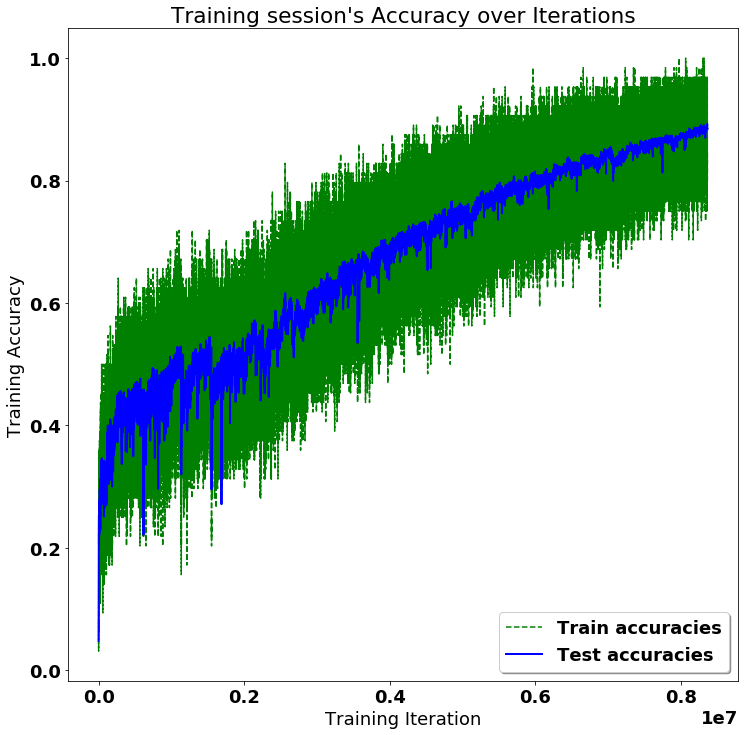

Testing Accuracy: 88.51615786552429%

Precision: 88.725277801932%
Recall: 88.51616062683644%
f1_score: 88.46958369766305%

Confusion Matrix:
Created using test set of 4084 datapoints, normalised to % of each class in the test dataset


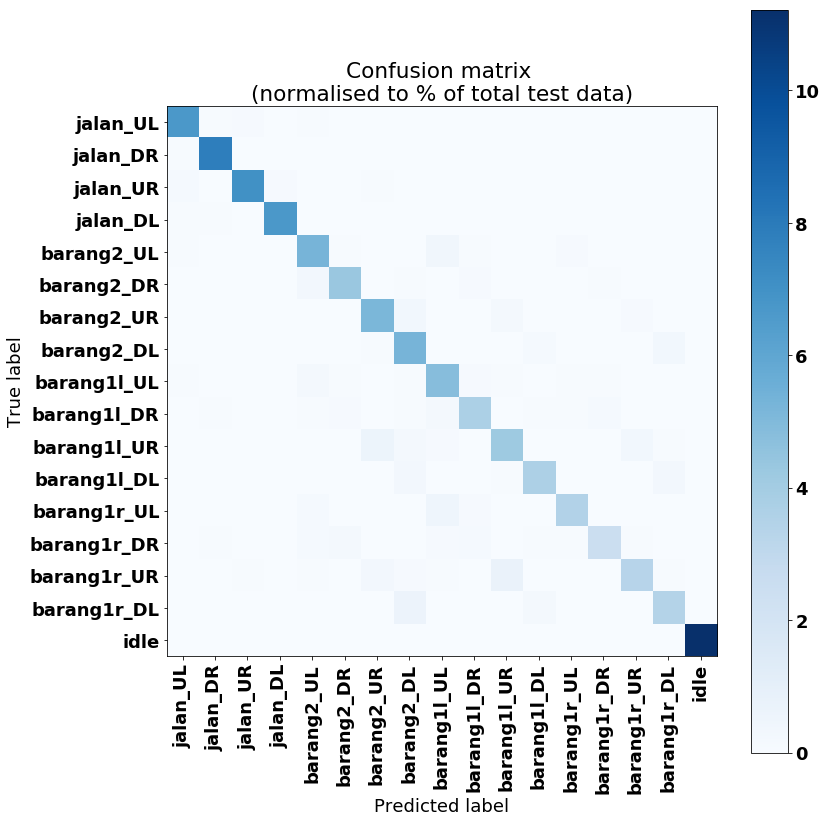

In [15]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
#plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
#plt.plot(indep_test_axis, np.array(test_losses), "b-", linewidth=2.0, label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print(len(test_accuracies))
print(len(train_accuracies))

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

plt.show()

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy_fin))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)


#print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [16]:


#
#X_val_path = DATASET_PATH + "X_val.txt"
#X_val = load_X(X_val_path)
#print X_val
#
#preds = sess.run(
#    [pred],
#    feed_dict={
#        x: X_val
#   }
#)
#
#print preds

In [17]:
#sess.close()
print(test_accuracies)

[0.047747307, 0.11532811, 0.20004897, 0.19417238, 0.20837414, 0.21376102, 0.2208619, 0.21376102, 0.25318316, 0.20641528, 0.22526935, 0.21596473, 0.26175317, 0.22282076, 0.27717924, 0.23628795, 0.26714006, 0.25857002, 0.22184134, 0.22428991, 0.25318316, 0.25954947, 0.23432909, 0.23677766, 0.248286, 0.26248777, 0.25563174, 0.2284525, 0.24191968, 0.26175317, 0.29554358, 0.27668953, 0.26028404, 0.23873654, 0.26836434, 0.2798727, 0.2791381, 0.26126346, 0.2593046, 0.253428, 0.27228206, 0.26077375, 0.28991184, 0.27179235, 0.24191968, 0.22967678, 0.24608228, 0.2504897, 0.28060725, 0.27766895, 0.31072477, 0.30044076, 0.31317335, 0.29921645, 0.30313417, 0.30435848, 0.30852106, 0.30093047, 0.27326152, 0.29333985, 0.28183153, 0.27619982, 0.2908913, 0.30582762, 0.32370225, 0.31782568, 0.29701275, 0.3104799, 0.33814886, 0.332762, 0.33080313, 0.33545545, 0.33202744, 0.32149854, 0.31268364, 0.3158668, 0.2977473, 0.29407445, 0.30093047, 0.3432909, 0.28966698, 0.33374143, 0.3357003, 0.32198825, 0.306562

## Conclusion

Final accuracy of >90% is pretty good, considering that training takes about 7 minutes.

Noticeable confusion between activities of Clapping Hands and Boxing, and between Jumping Jacks and Waving Two Hands which is understandable.

In terms of the applicability of this to a wider dataset, I would imagine that it would be able to work for any activities in which the training included a views from all angles to be tested on. It would be interesting to see it's applicability to camera angles in between the 4 used in this dataset, without training on them specifically.

 Overall, this experiment validates the idea that 2D pose can be used for at least human activity recognition, and provides verification to continue onto use of 2D pose for behaviour estimation in both people and animals
 

 ### With regards to Using LSTM-RNNs
 - Batch sampling
     - It is neccessary to ensure you are not just sampling classes one at a time! (ie y_train is ordered by class and batch chosen in order)The use of random sampling of batches without replacement from the training data resolves this.    
 
 - Architecture
     - Testing has been run using a variety of hidden units per LSTM cell, with results showing that testing accuracy achieves a higher score when using a number of hidden cells approximately equal to that of the input, ie 34. The following figure displays the final accuracy achieved on the testing dataset for a variety of hidden units, all using a batch size of 4096 and 300 epochs (a total of 1657 iterations, with testing performed every 8th iteration).
   
 
 

## Future Works

Inclusion of :

 - A pipeline for qualitative results
 - A validation dataset
 - Momentum     
 - Normalise input data (each point with respect to distribution of itself only)
 - Dropout
 - Comparison of effect of changing batch size
 

Further research will be made into the use on more subtle activity classes, such as walking versus running, agitated movement versus calm movement, and perhaps normal versus abnormal behaviour, based on a baseline of normal motion.


## References

The dataset can be found at http://tele-immersion.citris-uc.org/berkeley_mhad released under the BSD-2 license
>Copyright (c) 2013, Regents of the University of California All rights reserved.

The network used in this experiment is based on the following, available under the [MIT License](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/blob/master/LICENSE). :
> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition



In [18]:
# Let's convert this notebook to a README for the GitHub project's title page:
# !jupyter nbconvert --to markdown LSTM.ipynb
# !mv LSTM.md README.md

## 

In [19]:
#### Camera

# import argparse
# import logging
# import time

# import cv2
# import numpy as np

# from tf_pose.estimator import TfPoseEstimator
# from tf_pose.networks import get_graph_path, model_wh

# logger = logging.getLogger('TfPoseEstimator-WebCam')
# logger.setLevel(logging.DEBUG)
# ch = logging.StreamHandler()
# ch.setLevel(logging.DEBUG)
# formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
# ch.setFormatter(formatter)
# logger.addHandler(ch)

# class openpose:
#     def __init__(self, camera=0,resize='0x0',resize_out_ratio=4.0,model='mobilenet_thin',show_process=False):

#         logger.debug('initialization %s : %s' % (model, get_graph_path(model)))
#         w, h = model_wh(resize)
#         if w > 0 and h > 0:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))
#         else:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
#         logger.debug('cam read+')
#         cam = cv2.VideoCapture(camera)
#         ret_val, image = cam.read()
#         logger.info('cam image=%dx%d' % (image.shape[1], image.shape[0]))
        
#         fps_time = 0

#         while True:
#             ret_val, image = cam.read()

#             logger.debug('image process+')
#             humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)

#             logger.debug('postprocess+')
#             image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

#             logger.debug('show+')
#             cv2.putText(image,
#                         "FPS: %f" % (1.0 / (time.time() - fps_time)),
#                         (10, 10),  cv2.FONT_HERSHEY_SIMPLEX, 0.5,
#                         (0, 255, 0), 2)
#             cv2.imshow('tf-pose-estimation result', image)
#             fps_time = time.time()
#             if cv2.waitKey(1) == 27:
#                 break
#             logger.debug('finished+')

#         cv2.destroyAllWindows()

# if __name__ == '__main__':
#     openpose()
